In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
import itertools
import functools
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from torchvision.transforms.functional import resized_crop
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID, normalizer
from ngram import NGramModel
from analysis_tools.utils import *
from analysis_tools.pos_tags import *
from analysis_tools.word_categories import *
from analysis_tools.token_items_data import *
from analysis_tools.plotting import *
from analysis_tools.multimodal_visualization import *
from analysis_tools.processing import *
from analysis_tools.build_data import *


figsize = (13, 12)
sns.set_theme(
    style='white',
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.grid': False,
        'xtick.bottom': False,
        'xtick.top': False,
        'ytick.left': False,
        'ytick.right': False,
        'axes.spines.left': False,
        'axes.spines.bottom': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

np.set_printoptions(suppress=True, precision=2, linewidth=120)
pd.options.display.width = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
# load model from checkpoint

# select from list of checkpoints
all_checkpoint_paths = {
    "saycam": (
        #("lm_bs8", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=38.ckpt"),
        ("lm0", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt"),
        ("lm1", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=38.ckpt"),
        ("lm2", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=28.ckpt"),
        ("capt0", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt"),
        ("capt1", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=42.ckpt"),
        ("capt2", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=38.ckpt"),
        ("cbow0", "checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_0/epoch=31.ckpt"),
        ("cbow1", "checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_1/epoch=65.ckpt"),
        ("cbow2", "checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_2/epoch=58.ckpt"),
        #("contrastive0", "checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.1_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_True_seed_0/epoch=117.ckpt"),
        #("contrastive1", "checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.1_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_True_seed_1/epoch=109.ckpt"),
        #("contrastive2", "checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.1_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_True_seed_2/epoch=108.ckpt"),
        #("joint_bs16_0", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_16_optimizer_AdamW_lr_0.006_lr_scheduler_True_weight_decay_0.04_val_batch_size_16_eval_include_sos_eos_True_seed_0/epoch=93.ckpt"),
        #("joint_bs16_1", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_16_optimizer_AdamW_lr_0.006_lr_scheduler_True_weight_decay_0.04_val_batch_size_16_eval_include_sos_eos_True_seed_1/epoch=104.ckpt"),
        #("joint_bs16_2", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_16_optimizer_AdamW_lr_0.006_lr_scheduler_True_weight_decay_0.04_val_batch_size_16_eval_include_sos_eos_True_seed_2/epoch=119.ckpt"),
        #("joint_bs512_0", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_512_optimizer_AdamW_lr_0.01_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_eval_include_sos_eos_True_seed_0/epoch=118.ckpt"),
        #("joint_bs512_1", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_512_optimizer_AdamW_lr_0.01_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_eval_include_sos_eos_True_seed_1/epoch=103.ckpt"),
        #("joint_bs512_2", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_512_optimizer_AdamW_lr_0.01_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_eval_include_sos_eos_True_seed_2/epoch=81.ckpt"),

        #("1-gram", "1-gram"),
        #("2-gram", "2-gram"),
        #("3-gram", "3-gram"),
        #("4-gram", "4-gram"),
    ),
    "coco": (
        ("lm", "checkpoints/lm_dataset_coco_captioning_False_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=109.ckpt"),
        #("lm_bs512", "checkpoints/lm_dataset_coco_captioning_False_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=67.ckpt"),
#        ("capt", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=149.ckpt"),
        ("capt_ft", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=210.ckpt"),
        #("capt_bs512", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=65.ckpt"),
#        ("capt_attn", "checkpoints/lm_dataset_coco_captioning_True_attention_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.0003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=198.ckpt"),
#        ("capt_attn_gt", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=143.ckpt"),
        ("capt_attn_gt_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=198.ckpt"),
        #("capt_attn_gt_reg", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_True_bias_True_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=149.ckpt"),
        ("capt_attn_gt_reg_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_True_bias_True_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=211.ckpt"),
        #("capt_attn_gt_reg_untie", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_False_bias_True_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=136.ckpt"),
        ("capt_attn_gt_reg_untie_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_False_bias_True_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=187.ckpt"),

        ("cbow", "checkpoints/lm_dataset_coco_captioning_False_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_2_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.0003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=153.ckpt"),

        #("contrastive", "checkpoints/multimodal_dataset_coco_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_fix_temperature_True_temperature_0.05_batch_size_512_lr_0.0003_weight_decay_0.01_seed_0/epoch=51.ckpt"),

        #("joint", "checkpoints/joint_dataset_coco_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_fix_temperature_True_temperature_0.05_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=191.ckpt"),
    ),
}

ori_names, ori_checkpoint_paths = map(list, zip(*all_checkpoint_paths["saycam"]))

ori_models = []

data = None

for checkpoint_path in ori_checkpoint_paths:
    if "gram" in checkpoint_path:
        ngram_model = build_ngram_model(int(checkpoint_path.split('-')[0]), vocab_size, data.train_dataloader())
        model = ngram_model

    else:
        print_dict_args = False
        if print_dict_args:
            ckpt = torch.load(checkpoint)
            print(ckpt['hyper_parameters']['args'])

        print(f"load model from {checkpoint_path}")
        lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint_path, map_location=device)
        #print(lit_model.args)
        lit_model.to(device)

        if data is None:
            # build data and vocab according to the model
            data, args = build_data(args=lit_model.args, return_args=True)
            dataset_name = args.dataset

            word2idx = lit_model.text_encoder.word2idx
            idx2word = lit_model.text_encoder.idx2word

            vocab = lit_model.text_encoder.vocab
            vocab_size = len(vocab)
            print(f'vocab_size = {vocab_size}')
            # check consistency between vocab and idx2word
            for idx in range(vocab_size):
                assert idx in idx2word

        else:
            assert lit_model.args["dataset"] == dataset_name, f"checkpoint {checkpoint_path} ran on a different dataset {args.dataset}"

        lit_model.eval()
        model = lit_model

    ori_models.append(model)


# each name represents a group of models that we want to use their mean predictions;
# for example, if 'lm' is in this list, then predictions of all model with name 'lm*' is aggregated into 'lm'
names = ['lm', 'capt', 'cbow', 'contrastive', 'joint_bs16', 'joint_bs512'][:-3] if True else ori_names
groups = []
models = []
for name in names:
    group = [i for i, ori_name in enumerate(ori_names) if ori_name.startswith(name)]
    assert group, f"no models corresponds to {name}"
    groups.append(group)
    models.append(ori_models[group[0]])

load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt


/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


Using base transforms
Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created. Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!
vocab_size = 2350
load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=38.ckpt
load model from checkpoints/lm_dataset_sayca

In [4]:
# get sum values (counts, vector representations, losses) across the training set

split_items = {}

used_splits = ['train', 'val']


def print_items(items, n=20):
    for index, row in items.iloc[:n].iterrows():
        print(row_str(row, names))

    print()

    columns = ['cnt'] + names
    tot_values = items.loc[items.index.map(lambda index: index[0] != PAD_TOKEN_ID), columns].sum(axis=0)
    tot = pd.Series(tot_values, index=items.columns)
    tot[token_field] = 'ppl'
    print(row_str(tot, names))
    tot_values -= items.loc[(SOS_TOKEN_ID,), columns].sum(axis=0)
    tot = pd.Series(tot_values, index=items.columns)
    tot[token_field] = 'ppl_wo_sos'
    print(row_str(tot, names))
    tot_values -= items.loc[(EOS_TOKEN_ID,), columns].sum(axis=0)
    tot = pd.Series(tot_values, index=items.columns)
    tot[token_field] = 'ppl_wo_sos_eos'
    print(row_str(tot, names))


def remove_foils_wrapper(dataloader):
    for x, y, y_len, raw_y in dataloader:
        yield x[:, 0], y, y_len, raw_y

my_batch_size = 256
dataloader_fns = {
    'train': lambda: data.train_dataloader(batch_size=my_batch_size, shuffle=False, drop_last=False),
    'val': lambda: data.val_dataloader(batch_size=my_batch_size)[0],
    'test': lambda: data.test_dataloader(batch_size=my_batch_size)[0],
    'eval_val': lambda: remove_foils_wrapper(data.val_dataloader()[1]),
    'eval_test': lambda: remove_foils_wrapper(data.test_dataloader()[1]),
}

for split in used_splits:
    dataloader_fn = dataloader_fns[split]

    pos_tags = get_pos_tags(dataloader_fn(), dataset_name, split)

    ori_model_items = [
        torch_cache(checkpoint_path + f'.{split}.cache.pt')(get_model_items)(
            model, dataloader_fn(), pos_tags, ignore_all_token_items=(split == 'train'))
        for model, checkpoint_path in zip(ori_models, ori_checkpoint_paths)]
    model_items = [mean_model_items([ori_model_items[i] for i in group], idx=-1) for group in groups]
    items = ModelItems(*[stack_items(items_list, names, idx2word) for items_list in list(zip(*model_items))])
    extend_items(items.token_items, names, idx2word)
    extend_items(items.token_pos_items, names, idx2word)
    if items.all_token_items is not None:
        extend_items(items.all_token_items, names, idx2word)
    split_items[split] = items

    print_items(items.token_items)

    if split_items[split].all_token_items is not None:
        for name, group in zip(names, groups):
            ori_probs = []
            for i in group:
                model = ori_models[i]
                if isinstance(model, NGramModel):
                    continue
                probs = get_model_probs(model, dataloader_fns[split](), pos_tags)
                ori_probs.append(probs)
            probs = mean_probs(ori_probs)
            split_items[split].all_token_items[f'{name} probs'] = probs

load cached pos tags: dataset_cache/saycam/train.pos.cache
load from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt.train.cache.pt
load from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=38.ckpt.train.cache.pt
load from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=28.ckpt.train.cache.pt
load from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt.train.cache.pt
load from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.65it/s]


load cached pos tags: dataset_cache/saycam/train.pos.cache
load cached pos tags: dataset_cache/saycam/val.pos.cache
load cached pos tags: dataset_cache/saycam/test.pos.cache
train #examples: 33737
val   #examples:  1874
test  #examples:  1875
train #tokens: 292475
val   #tokens:  16103
test  #tokens:  16168
train .               #tokens: 122736  41.96%
train adjective       #tokens:   8190   2.80%
train adverb          #tokens:  13679   4.68%
train cardinal number #tokens:   1247   0.43%
train function word   #tokens:  75610  25.85%
train noun            #tokens:  27132   9.28%
train verb            #tokens:  43881  15.00%
val   .               #tokens:   6882  42.74%
val   adjective       #tokens:    419   2.60%
val   adverb          #tokens:    757   4.70%
val   cardinal number #tokens:     81   0.50%
val   function word   #tokens:   4117  25.57%
val   noun            #tokens:   1446   8.98%
val   verb            #tokens:   2401  14.91%
test  .               #tokens:   6733  41.64%
t

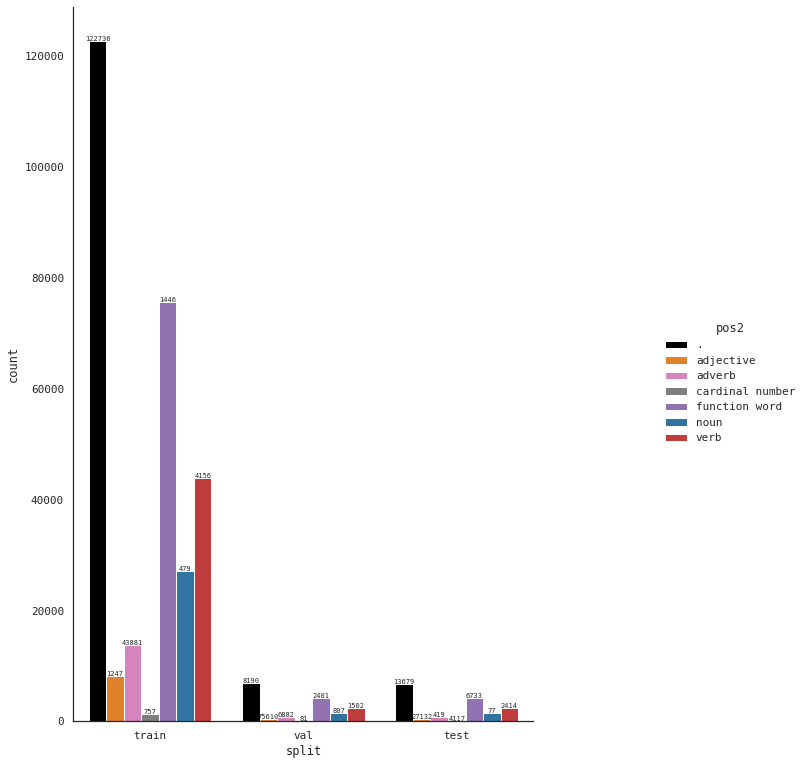

In [5]:
# plot statistics of syntactic categories

pos_tag_dfs = []

splits = ['train', 'val', 'test']

for split in splits:
    dataloader_fn = dataloader_fns[split]
    pos_tags = get_pos_tags(dataloader_fn(), dataset_name, split)

    pos_tag_df = pd.DataFrame(data=list(itertools.chain.from_iterable(pos_tags)), columns=['pos'])
    pos_tag_df['split'] = split
    pos_tag_dfs.append(pos_tag_df)

pos_tag_df = pd.concat(pos_tag_dfs)

for pos_field, pos_mapping in pos_mappings:
    pos_tag_df[pos_field] = pos_tag_df['pos'].map(pos_mapping).astype('category')

pos_field = 'pos2'

g = sns.catplot(kind='count', data=pos_tag_df, x='split', hue=pos_field, palette=pos_palette)
g.figure.set_size_inches(*figsize)

for split in splits:
    print(f'{split:5s} #examples: {len(data.datasets[split]):5d}')

for split in splits:
    split_cnt = len(pos_tag_df[(pos_tag_df['split'] == split)])
    print(f'{split:5s} #tokens: {split_cnt:6d}')

for (split, pos), bar in zip(itertools.product(splits, pos_tag_df.dtypes[pos_field].categories), g.ax.patches):
    split_cnt = len(pos_tag_df[(pos_tag_df['split'] == split)])
    split_pos_cnt = len(pos_tag_df[(pos_tag_df['split'] == split) & (pos_tag_df[pos_field] == pos)])
    print(f'{split:5s} {pos:15s} #tokens: {split_pos_cnt:6d} {split_pos_cnt / split_cnt :7.2%}')
    g.ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 40, f'{split_pos_cnt:d}', ha="center", fontsize='xx-small')

plt.show()

In [6]:
test_model_ns = [model_n for model_n, model in enumerate(models) if model.text_encoder.regressional and not model.text_encoder.captioning and 'contrastive' not in names[model_n]]


# use arbitrary image x as a placeholder
x = next(examples_from_dataloader(dataloader_fns['val']()))[0]

def test(prefix):
    prefix = prefix.lower().split()
    y = [SOS_TOKEN_ID] + [word2idx.get(word, UNK_TOKEN_ID) for word in prefix] + [EOS_TOKEN_ID]
    print('converted:', ' '.join(idx2word[idx] for idx in y))
    y = torch.tensor(y, dtype=torch.long)
    y_len = len(y)
    y_len = torch.tensor(y_len, dtype=torch.long)

    for model_n in test_model_ns:
        model, name = models[model_n], names[model_n]
        print(f'{name}:')
        outputs, losses, logits, attns, labels = run_model(model, x, y, y_len, single_example=True, return_all=True)
        probs = logits.softmax(-1)
        print_top_values(probs, idx2word, steps=[len(probs) - 1], value_formatter=prob_formatter)


for prefix in [
    "the horse ran past",
    "the horse ran past the",
    "the doggy ran past the",
    "the birdie flew past the",
    "what the truck has to",
    "what the truck is",
    "the girl the boys like",
]:
    test(prefix)

converted: <sos> the horse ran past <eos>
lm:
 22.8% ,         16.8% the       10.1% .          7.9% and        3.9% to      
converted: <sos> the horse ran past the <eos>
lm:
  6.0% clock      5.9% <unk>      3.0% farm       2.8% boat       2.8% hole    
converted: <sos> the doggy ran past the <eos>
lm:
 10.8% clock      8.0% car        7.0% <unk>      3.8% boat       3.3% sea     
converted: <sos> the birdie flew past the <eos>
lm:
 13.1% boat       5.4% tree       5.3% <unk>      4.3% sky        3.2% mouse   
converted: <sos> what the truck has to <eos>
lm:
 42.1% be         9.3% play       7.2% put        5.6% do         4.3% get     
converted: <sos> what the truck is <eos>
lm:
 17.0% on        14.4% in         9.3% there      7.9% ?          6.4% ,       
converted: <sos> the girl the boys like <eos>
lm:
 19.2% the        6.1% that       5.3% a          5.1% to         3.7% looking 


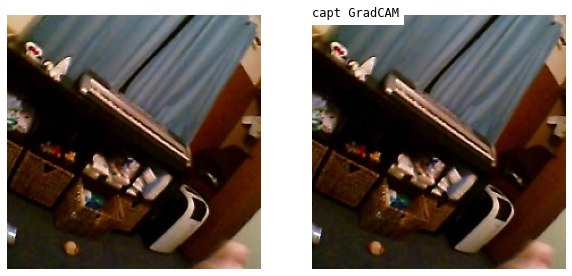

i know .


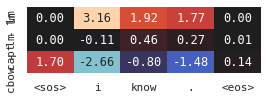

lm:

capt:

cbow:
 18.2% <sos>    |  18.2% <sos>      9.7% think      8.8% know       5.2% ,          5.1% 'm      



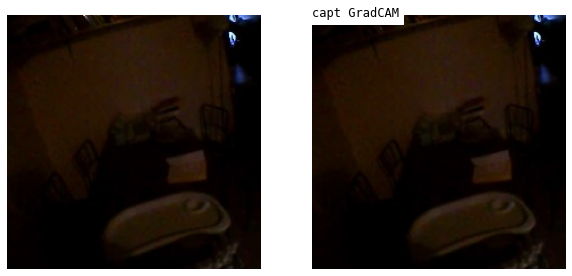

we should turn on some lights , huh ?


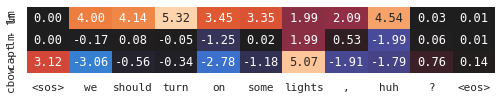

lm:

capt:

cbow:
  4.4% <sos>    |   6.1% should     5.3% go         4.4% <sos>      4.4% can        4.2% have    



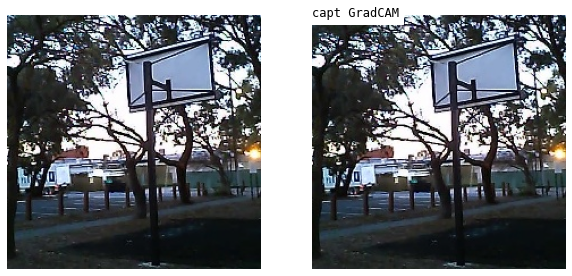

yeahh .


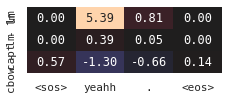

lm:

capt:

cbow:
 56.8% <sos>    |  56.8% <sos>     21.8% <eos>     11.6% ,          1.5% ..         1.4% "       



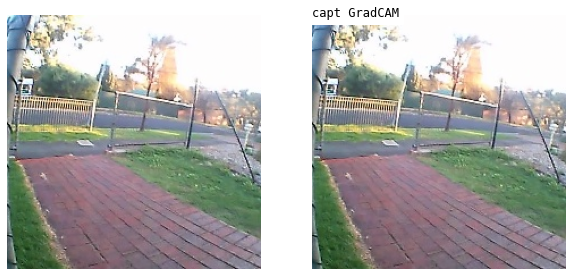

here , let me show you .


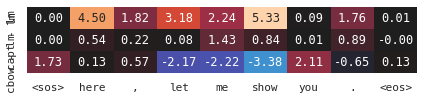

lm:

capt:

cbow:
 17.8% <sos>    |  17.8% <sos>     10.4% ,          7.8% 's         4.7% is         4.2% over    



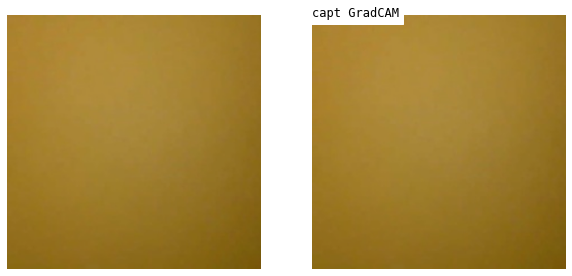

yeah it 's this this one that 's really


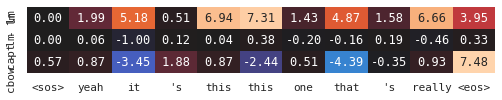

lm:

capt:

cbow:
 56.4% <sos>    |  56.4% <sos>     17.7% <eos>     17.5% ,          0.6% ...        0.4% "       



In [7]:
searched_word = None
visualize_models = True
n_print_example = 5
textgen_model_ns = [model_n for model_n, (name, model) in enumerate(zip(names, models)) if 'attn' in name] if False else []
multiple_views = False
all_steps = False

gradcam_model_ns = [model_n for model_n, model in enumerate(models) if model.text_encoder.captioning or model.text_encoder.has_attention]
attn_model_ns = [model_n for model_n, model in enumerate(models) if model.text_encoder.has_attention]
if not visualize_models:
    gradcam_model_ns = []
    attn_model_ns = []
n_visualized_models = len(gradcam_model_ns) + len(attn_model_ns)

if searched_word:
    if searched_word is True:
        searched_word = input("search word: ")
    searched_token_id = word2idx.get(searched_word, UNK_TOKEN_ID)
    if searched_token_id == UNK_TOKEN_ID:
        print(f"mapping {searched_word} to UNK")


def get_views(x, grid=(2, 2)):
    """Get multiple views of image x.
    """
    img = n_inv(x)
    views = [img]
    h = img.size(-2) // grid[0]
    w = img.size(-1) // grid[1]
    for grid_i in range(grid[0]):
        for grid_j in range(grid[1]):
            x = grid_i * h
            y = grid_j * w
            views.append(resized_crop(img, x, y, h, w, img.shape[-2:]))
    views = list(map(normalizer, views))
    return views


show_image = functools.partial(plot_image, overlying=True, blur=False, interpolation='nearest')


def visualize_example(x, y, y_len, raw_y, steps=None, model_first=True, prepend_x=False, use_losses=None):
    """Visualize an example.
    Inputs:
        steps: list of steps to visualize; None for all steps
        model_first: if True, then the axes are of n_visualized_models * len(steps), else it is transposed
        prepend_x: if True, prepend raw image x before the models
        use_losses: use the designated losses; must be a list of losses, where each losses is a list of loss at each step;
            for example, split_items[split].losses[example_i]; if None, use the losses generated by running the models
    """
    img = torch_to_numpy_image(n_inv(x))
    y_labels = [idx2word[y_id.item()] for y_id in y]
    if steps is None:
        steps = list(range(y_len.item()))

    n_rows, n_cols = int(prepend_x) + n_visualized_models, len(steps)
    if not model_first:
        n_rows, n_cols = n_cols, n_rows
    n_axes = n_rows * n_cols
    ax_size = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(ax_size * n_cols, ax_size * n_rows), squeeze=False)
    if not model_first:
        axes = [[axes[j][i] for j in range(n_rows)] for i in range(n_cols)]
    axes_iter = itertools.chain.from_iterable(axes)

    if prepend_x:
        for step_i, step in enumerate(steps):
            show_image(next(axes_iter), img)

    for model_n in gradcam_model_ns:
        model, name = models[model_n], names[model_n]
        gradcams = gradCAM_for_captioning_lm(model, x, y, y_len, steps=steps)
        prefix = f'{name} GradCAM'
        for step_i, (step, gradcam) in enumerate(zip(steps, gradcams)):
            if step == 0:
                show_image(next(axes_iter), img, text=prefix)
            else:
                text = y_labels[step]
                if step_i == 0:
                    text = prefix + ' ' + text
                show_image(next(axes_iter), img, gradcam, text=text)

    for model_n in attn_model_ns:
        model, name = models[model_n], names[model_n]
        attns = attention_for_attention_lm(model, x, y, y_len, steps=steps)
        prefix = f'{name} attn'
        for step_i, (step, attn) in enumerate(zip(steps, attns)):
            text = y_labels[step]
            if step_i == 0:
                text = prefix + ' ' + text
            show_image(next(axes_iter), img, attn, text=text)

    for ax in axes_iter:
        ax.axis("off")
    plt.show()

    if use_losses is None:
        with torch.no_grad():
            rets = [run_model(model, x, y, y_len, single_example=True, return_all=True) for model in models]
            losses = [ret[1].cpu().numpy() for ret in rets]
    else:
        losses = use_losses
    print(raw_y[0])
    names_, losses_ = zip(*[(name, loss) for name, loss in zip(names, losses) if 'contrastive' not in name])
    plot_model_y_value_heatmap(names_, losses_, y_labels)
    
    if use_losses is None:
        for name, model, ret in zip(names, models, rets):
            if not isinstance(model, MultiModalLitModel) or 'contrastive' in name:
                continue
            print(f'{name}:')
            if model.language_model.text_encoder.regressional:
                steps_ = [step - 1 for step in steps if step > 0]
            else:
                steps_ = steps
            logits, labels = ret[2], ret[4]
            probs = logits.softmax(-1)
            print_top_values(probs, idx2word, labels, steps=steps_, value_formatter=prob_formatter)
            print()


examples = examples_from_dataloader(dataloader_fns['val']())

example_i = 0
print_example_i = 0

for example_i, (x, y, y_len, raw_y) in enumerate(examples):
    y = y[:y_len]

    if searched_word:
        searched_word_steps = [idx for idx, y_id in enumerate(y) if y_id == searched_token_id]
        if not searched_word_steps:
            continue

    if all_steps:
        steps = None
    else:
        steps = searched_word_steps if searched_word else [0]

    for x_view_i, x_view in enumerate(get_views(x) if multiple_views else [x]):
        visualize_example(x_view, y, y_len, raw_y, steps=steps, model_first=all_steps, prepend_x=not all_steps)

    for model_n in textgen_model_ns:
        name = names[model_n]
        print(f"generating text from {name}:")
        model = models[model_n]
        image_features, image_feature_map = model.model.encode_image(x.unsqueeze(0).to(device))
        beam_seq, log_prob = model.language_model.beam_search_decode(
            batch_size=1,
            beam_width=model.beam_width,
            decode_length=model.decode_length,
            length_penalty_alpha=model.length_penalty_alpha,
            image_features=image_features if model.language_model.text_encoder.captioning else None,
            image_feature_map=image_feature_map if model.language_model.text_encoder.has_attention else None,
        )
        gen_text_ids = beam_seq[0, 0]
        gen_text_len = len(gen_text_ids)
        while gen_text_len > 0 and gen_text_ids[gen_text_len - 1] == PAD_TOKEN_ID:
            gen_text_len -= 1
        gen_text_len = torch.tensor(gen_text_len, device=device)
        gen_text_labels = [idx2word[y_id.item()] for y_id in gen_text_ids]
        gen_text = ' '.join(gen_text_labels)
        visualize_example(x, gen_text_ids, gen_text_len, [gen_text], steps=None, model_first=True, prepend_x=False)

    print_example_i += 1
    if print_example_i >= n_print_example:
        break

In [8]:
vector_attr = ['mean_vector', 'embedding'][1]

cosine matrices:



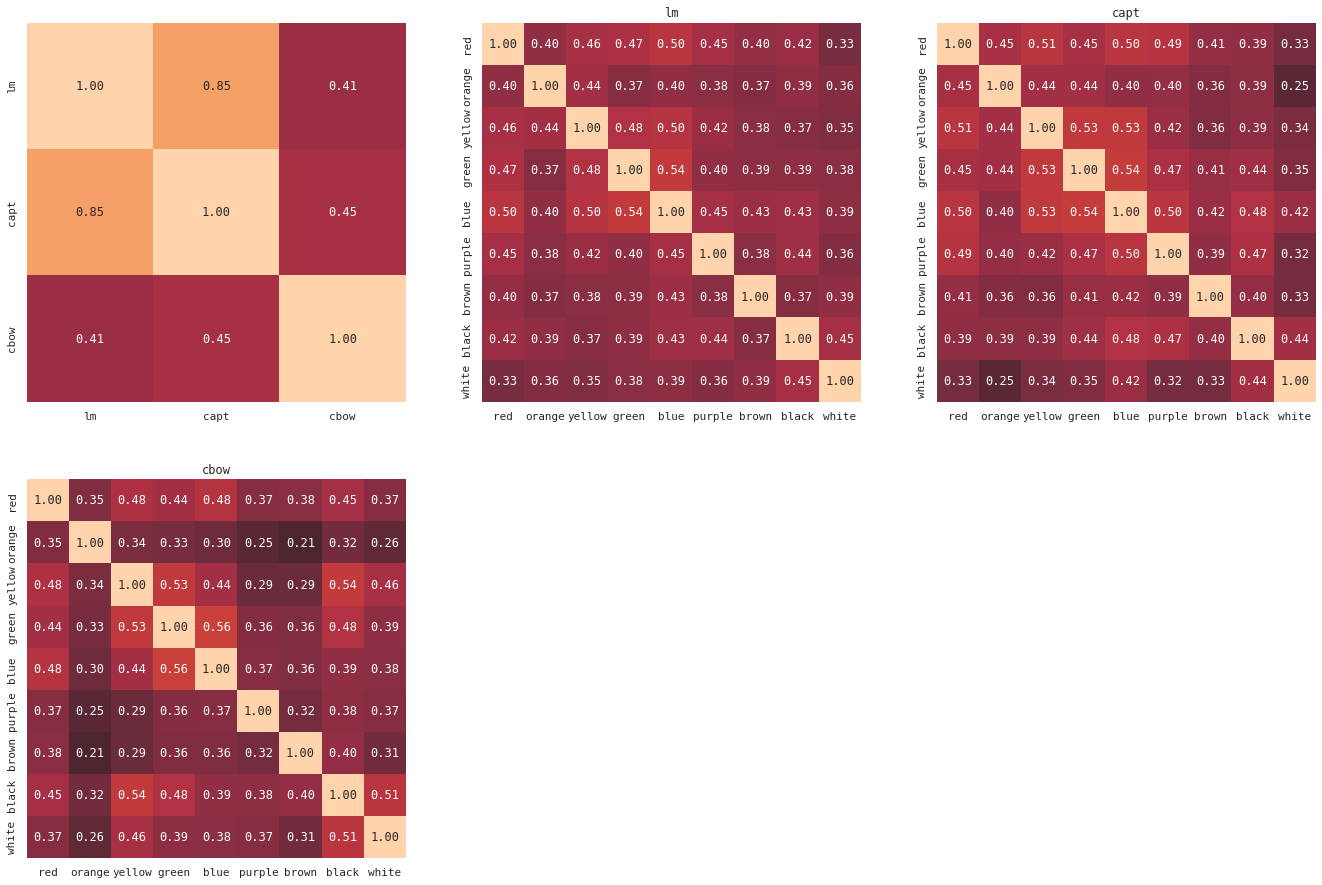

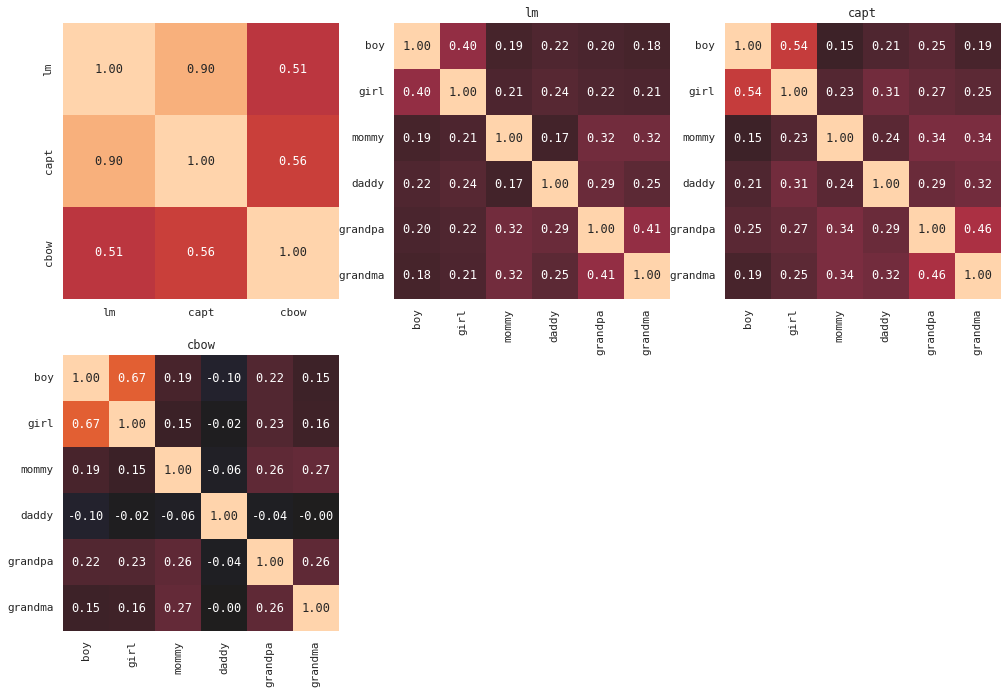

cosine matrices for the differentiations:

mapping eats to UNK
mapping flies to UNK
mapping drives to UNK
mapping drove to UNK
mapping stood to UNK
mapping crawled to UNK


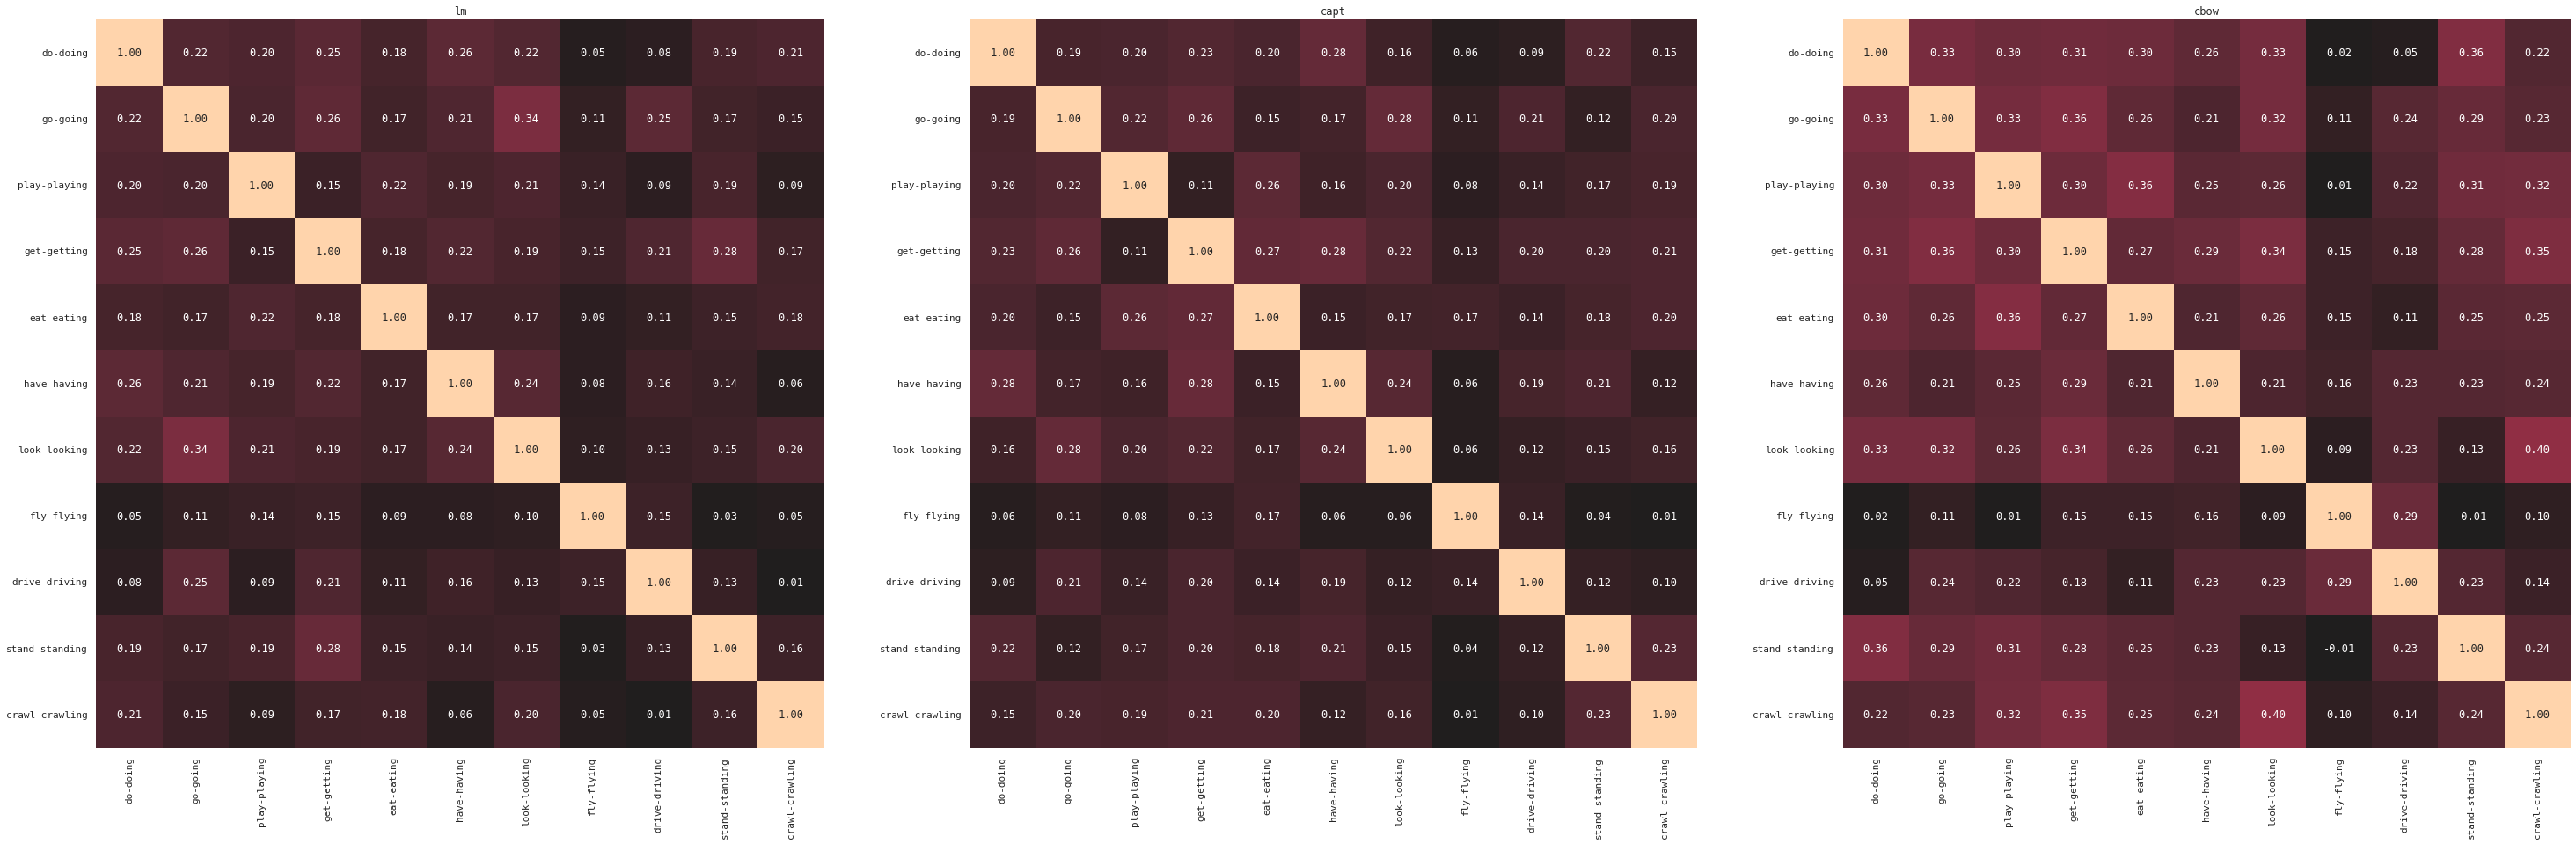

mapping doesn't to UNK
mapping didn't to UNK
mapping shouldn't to UNK
mapping hasn't to UNK
mapping haven't to UNK
mapping won't to UNK


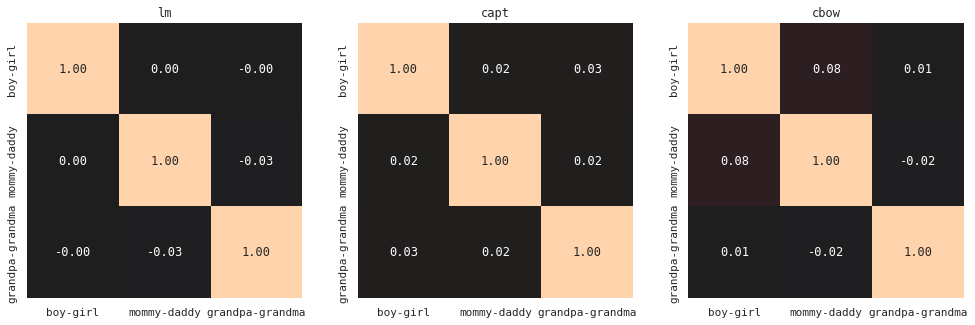

In [9]:
# cosine matrices for some tested words

def split_tokens(inp):
    tokens = inp.split()
    token_ids = []
    for token in tokens:
        token_id = word2idx.get(token, UNK_TOKEN_ID)
        if token_id == UNK_TOKEN_ID:
            print(f'mapping {token} to UNK')
        token_ids.append(token_id)
    return token_ids

def get_items_from_inp(inp, token_items=split_items['train'].token_items):
    token_ids = split_tokens(inp)
    if UNK_TOKEN_ID in token_ids:
        raise KeyError
    return token_items.loc[token_ids]


# cosine matrices
print('cosine matrices:')
print()
for inp in [
    "red orange yellow green blue purple brown black white",
    "boy girl mommy daddy grandpa grandma",
]:
    try:
        items = get_items_from_inp(inp)
    except KeyError:
        continue
    plot_vector_sim_heatmap(items, names, vector_attr=vector_attr, one_figure=True)

# cosine matrices for the differentiations (vector1 - vector0)
print('cosine matrices for the differentiations:')
print()
for inp in [
    "do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives",
    "do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled",
    "do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling",
    "do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't",
    "boy girl mommy daddy grandpa grandma",
]:
    try:
        items = get_items_from_inp(inp)
    except KeyError:
        continue
    plot_vector_sim_heatmap(items, names, diff=True, vector_attr=vector_attr, one_figure=True)

In [10]:
for split in used_splits:
    token_items = split_items[split].token_items

    for n, name in enumerate(names):
        print(f'{name}:')
        get_tsne_points(token_items[name], get_attr=vector_attr)
        extend_point_items(token_items, name, 'tsne')
        get_eigen_points(token_items[name], get_attr=vector_attr)
        extend_point_items(token_items, name, 'eigen')

lm:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
capt:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
cbow:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
lm:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
capt:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
cbow:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.


In [11]:
split_pos_items, split_pos_pos_items, split_all_pos_items = {}, {}, {}

for split in used_splits:
    print(f'{split} split:')

    top_token_items = split_items[split].token_items.sort_values('cnt', ascending=False, kind='stable')   # sort by cnt
    top_token_items = top_token_items[~top_token_items[token_field].isin(untypical_words)]  # remove untypical words
    pos_field = 'pos2'
    used_poses = top_token_items.dtypes[pos_field].categories
    pos_items = {pos: top_token_items[top_token_items[pos_field] == pos] for pos in used_poses}
    split_pos_items[split] = pos_items
    for pos in used_poses:
        items = pos_items[pos]
        print(f'number of {pos}s: {len(items)}')
        for _, row in items[:50].iterrows():
            print(row_str(row, names))

    interleaving_step = 1

    pos_pos_items = {}
    for i_pos in range(len(used_poses)):
        for j_pos in range(len(used_poses)):
            if i_pos != j_pos:
                pos_i = used_poses[i_pos]
                pos_i_items = pos_items[pos_i]
                pos_j = used_poses[j_pos]
                pos_j_items = pos_items[pos_j]
                interleaved_dfs = []
                i = -interleaving_step
                for i in range(0, min(len(pos_i_items), len(pos_j_items)), interleaving_step):
                    interleaved_dfs.append(pos_i_items[i:i+interleaving_step])
                    interleaved_dfs.append(pos_j_items[i:i+interleaving_step])
                else:
                    i += interleaving_step
                    interleaved_dfs.append(pos_i_items[i:])
                    interleaved_dfs.append(pos_j_items[i:])
                pos_pos_items[(pos_i, pos_j)] = pd.concat(interleaved_dfs)
    split_pos_pos_items[split] = pos_pos_items

    interleaved_dfs = []
    for i in range(0, max(map(len, pos_items.values())), interleaving_step):
        for pos in used_poses:
            items = pos_items[pos]
            interleaved_dfs.append(items[i:i+interleaving_step])
    all_pos_items = pd.concat(interleaved_dfs)
    split_all_pos_items[split] = all_pos_items

    # check some items
    for _, row in top_token_items[:100].iterrows():
        print(row_str(row, names))
    print()
    for word in ['look', 'need', 'draw']:
        try:
            token_id = word2idx[word]
            for _, row in top_token_items.loc[token_id].iterrows():
                print(row_str(row, names))
        except KeyError:
            pass

train split:
number of .s: 222
<sos>      .     33737:     1.000     1.000     9.869
<eos>      .     33370:     1.462     1.409     2.862
.          .     16566:     3.050     2.802     1.817
,          ,      9479:     5.927     5.832     6.801
?          .      8420:     2.382     2.105     3.315
yeah       UH     4923:     8.659     8.512     4.786
"          ``     2043:    13.632     5.386    20.110
!          .      1819:    12.186     9.430    12.480
okay       UH     1760:    26.081    25.654    18.520
oh         UH     1272:    30.678    31.567    16.537
ok         UH      812:    62.735    53.224    52.453
...        ,       748:    45.401    35.485   125.832
no         UH      668:    67.770    52.507    50.516
alright    UH      642:    75.060    69.066    38.375
-          ,       486:    18.118    13.404    23.628
huh        UH      253:    13.403    10.324    28.507
well       UH      250:    82.771    70.561   112.284
yea        UH      244:   149.527    51.817    55.7

<sos>      .     33737:     1.000     1.000     9.869
<eos>      .     33370:     1.462     1.409     2.862
.          .     16566:     3.050     2.802     1.817
,          ,      9479:     5.927     5.832     6.801
you        PRP    9235:     5.436     5.131     3.463
?          .      8420:     2.382     2.105     3.315
the        DT     5841:     5.862     5.071     3.255
yeah       UH     4923:     8.659     8.512     4.786
to         TO     4540:     2.349     2.202     2.492
a          DT     4539:     6.554     5.162     3.592
it         PRP    4435:     9.466     8.726     8.141
<unk>      NN     4364:    27.586    24.645    37.825
and        CC     3813:    10.125     8.347     9.804
that       DT     3742:    17.595    15.068     9.711
we         PRP    3273:    12.192    10.776     5.585
i          PRP    3032:    19.200    18.311     4.120
there      EX     2921:    18.062    14.930    12.888
do         VBP    2850:    17.917    16.139     8.508
want       VBP    2816:     

<sos>      .      1874:     1.000     1.000     9.994
<eos>      .      1857:     1.556     1.526     3.042
.          .       941:     3.684     3.575     1.886
,          ,       543:     7.732     8.272     8.293
you        PRP     512:     5.923     5.827     3.533
?          .       452:     2.990     2.758     3.444
the        DT      311:     8.950     8.374     4.620
<unk>      NN      295:    35.634    34.953    38.935
yeah       UH      251:     9.072     9.071     4.668
it         PRP     242:    11.236    10.751     9.312
a          DT      238:     7.951     6.829     3.719
that       DT      226:    24.554    22.002    10.493
to         TO      220:     3.882     3.904     3.425
and        CC      220:    16.097    15.848    14.038
we         PRP     190:    16.151    14.660     5.782
there      EX      167:    24.307    20.305    13.323
i          PRP     162:    21.951    21.078     4.043
do         VBP     153:    21.250    20.322    10.201
"          ``      129:    2

noun_verb:


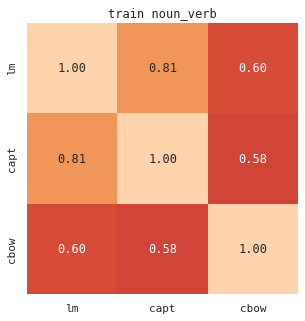

lm:


/home/ww2135/.local/lib/python3.9/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


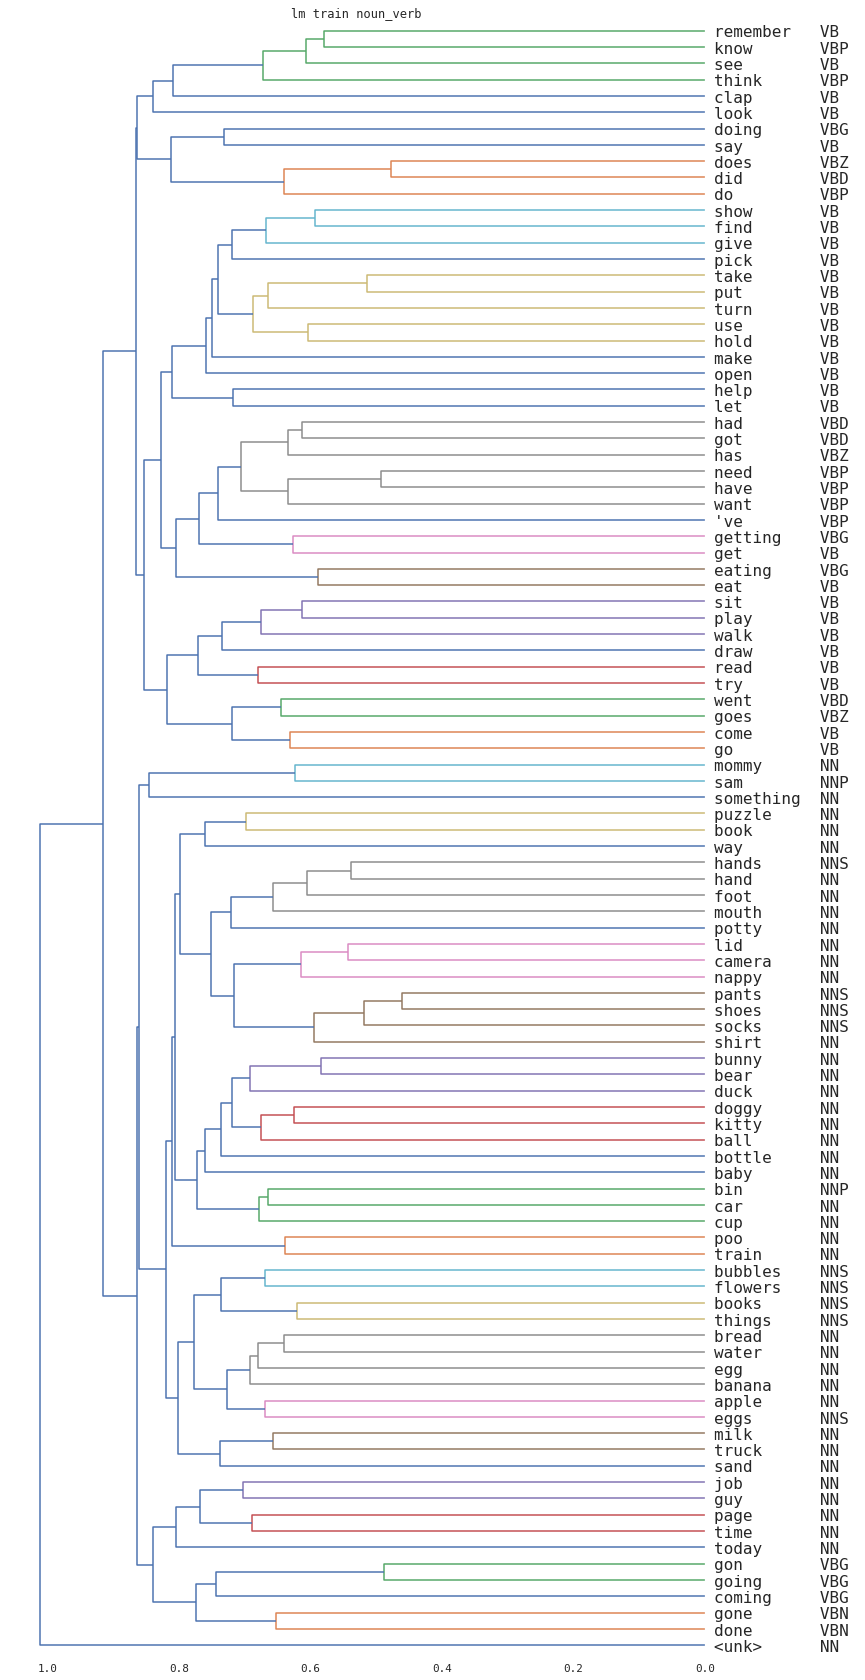

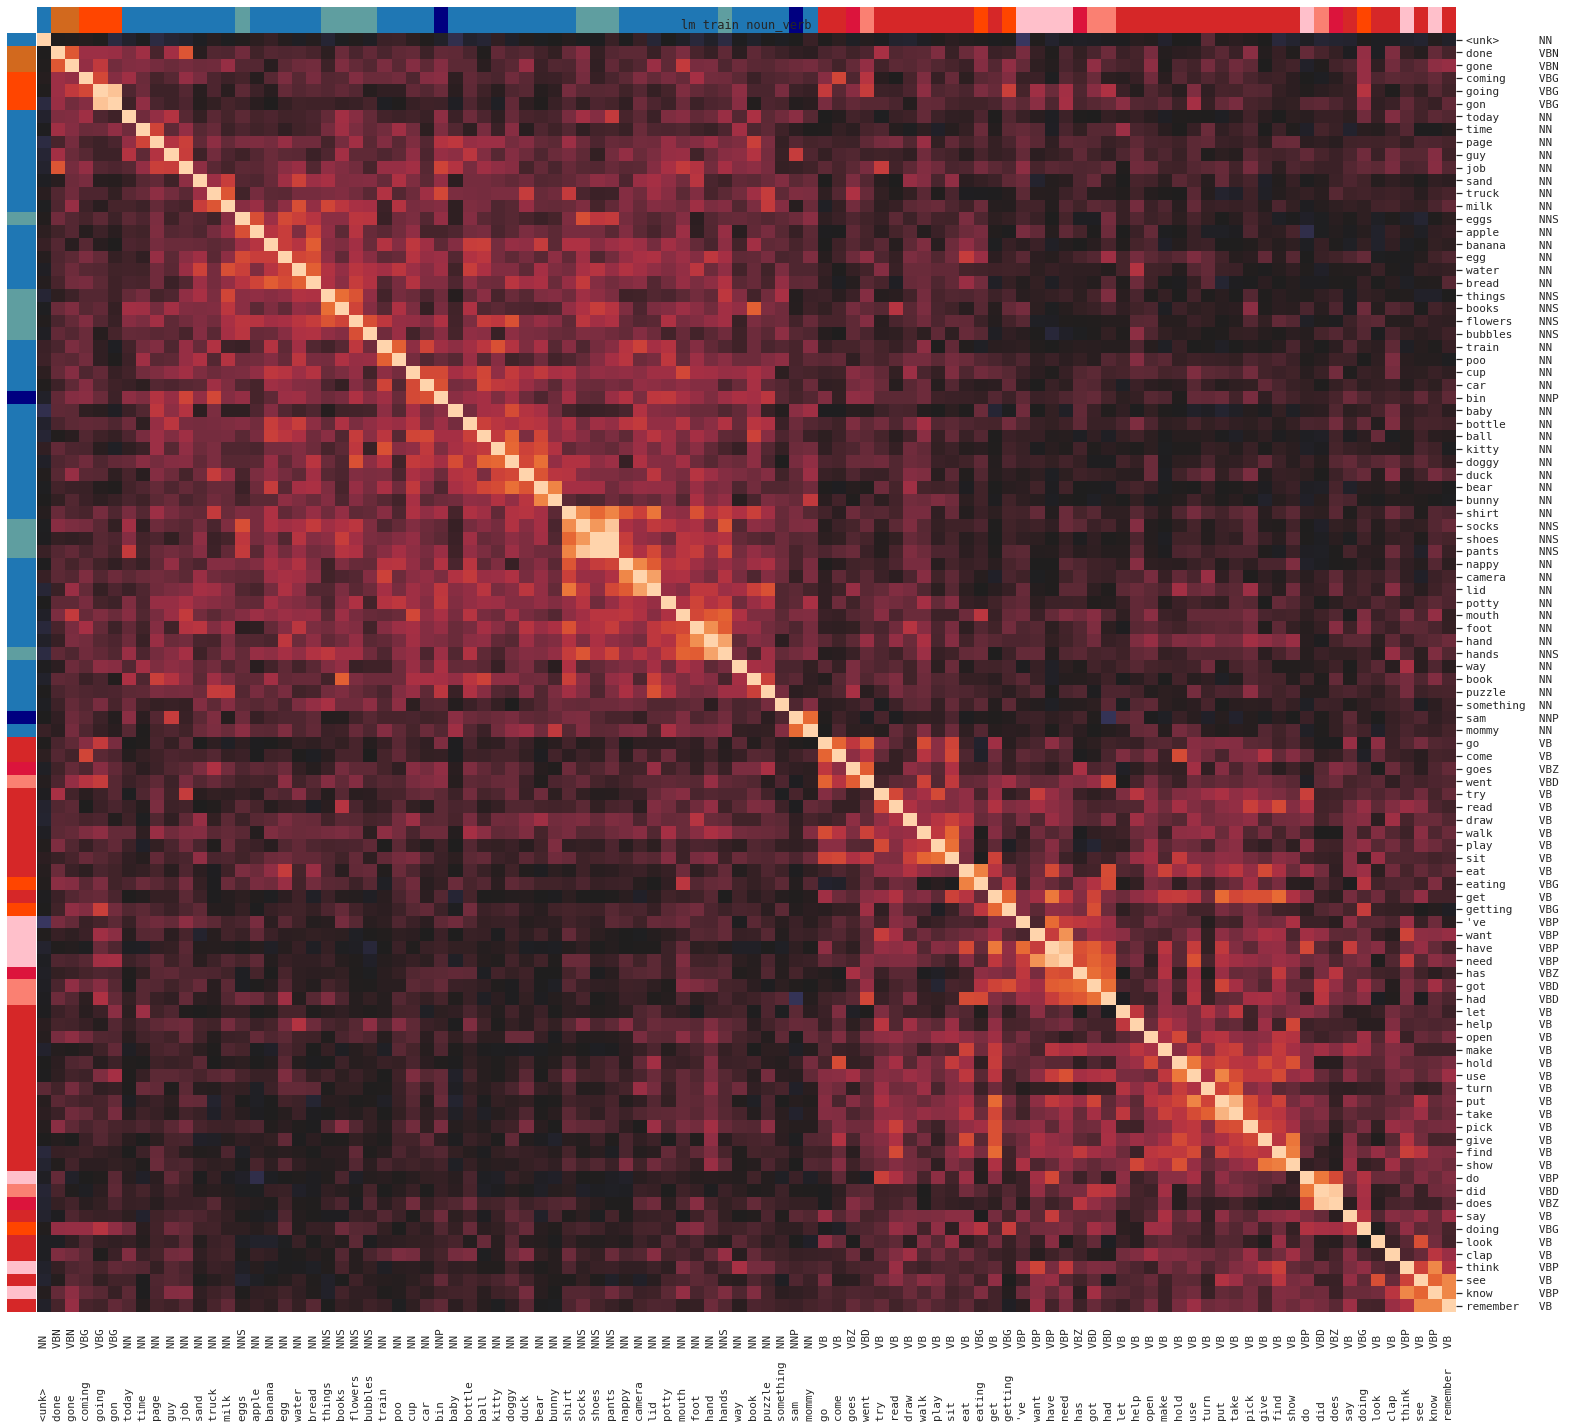

capt:


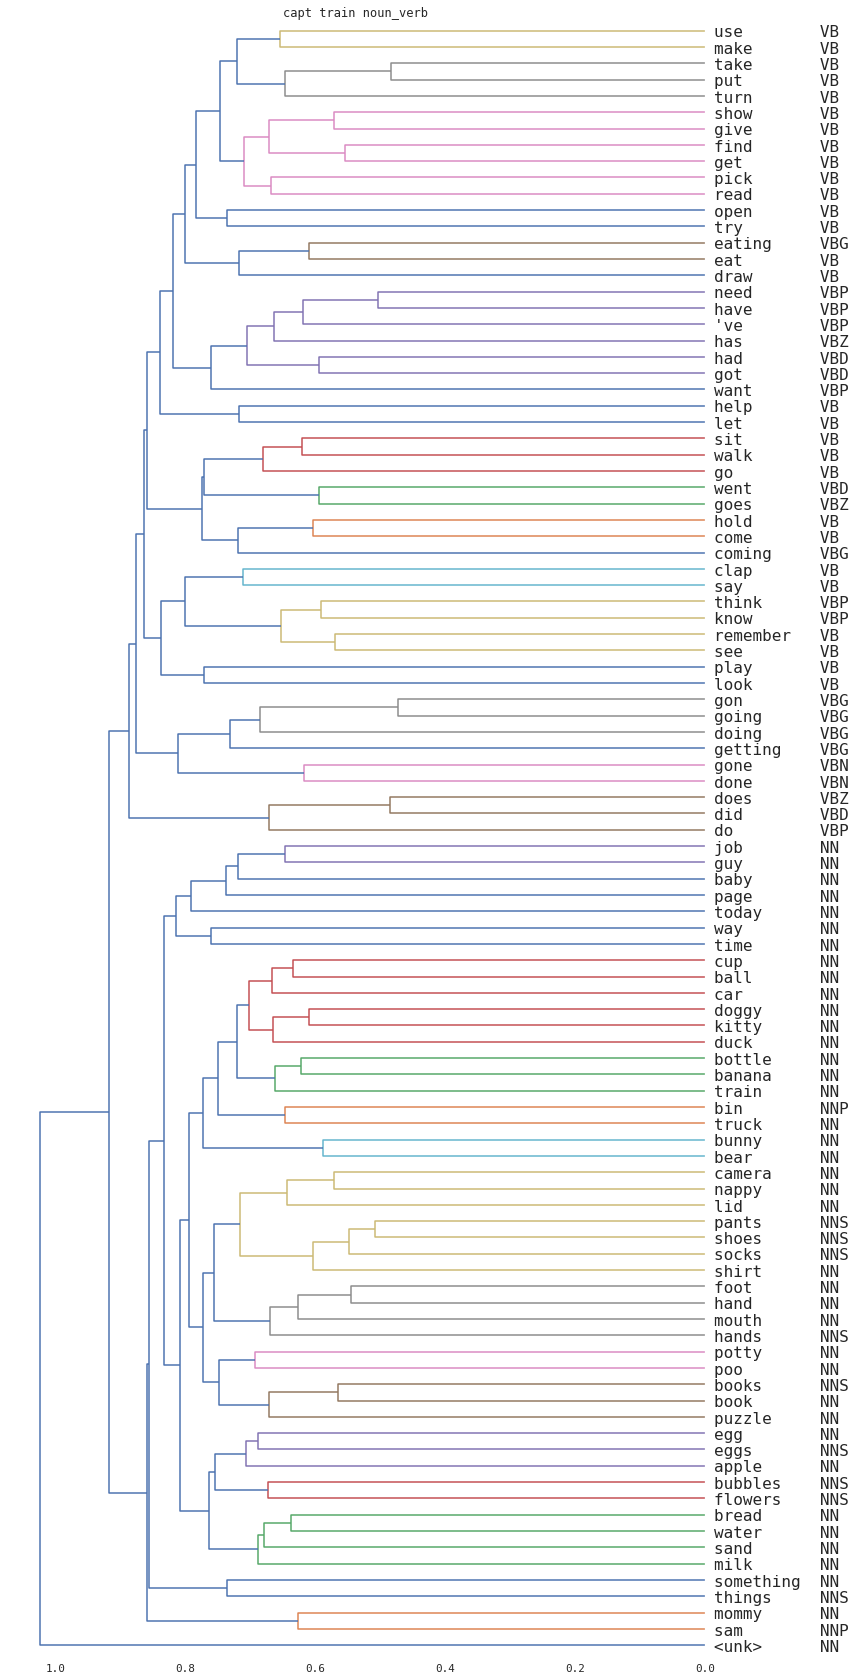

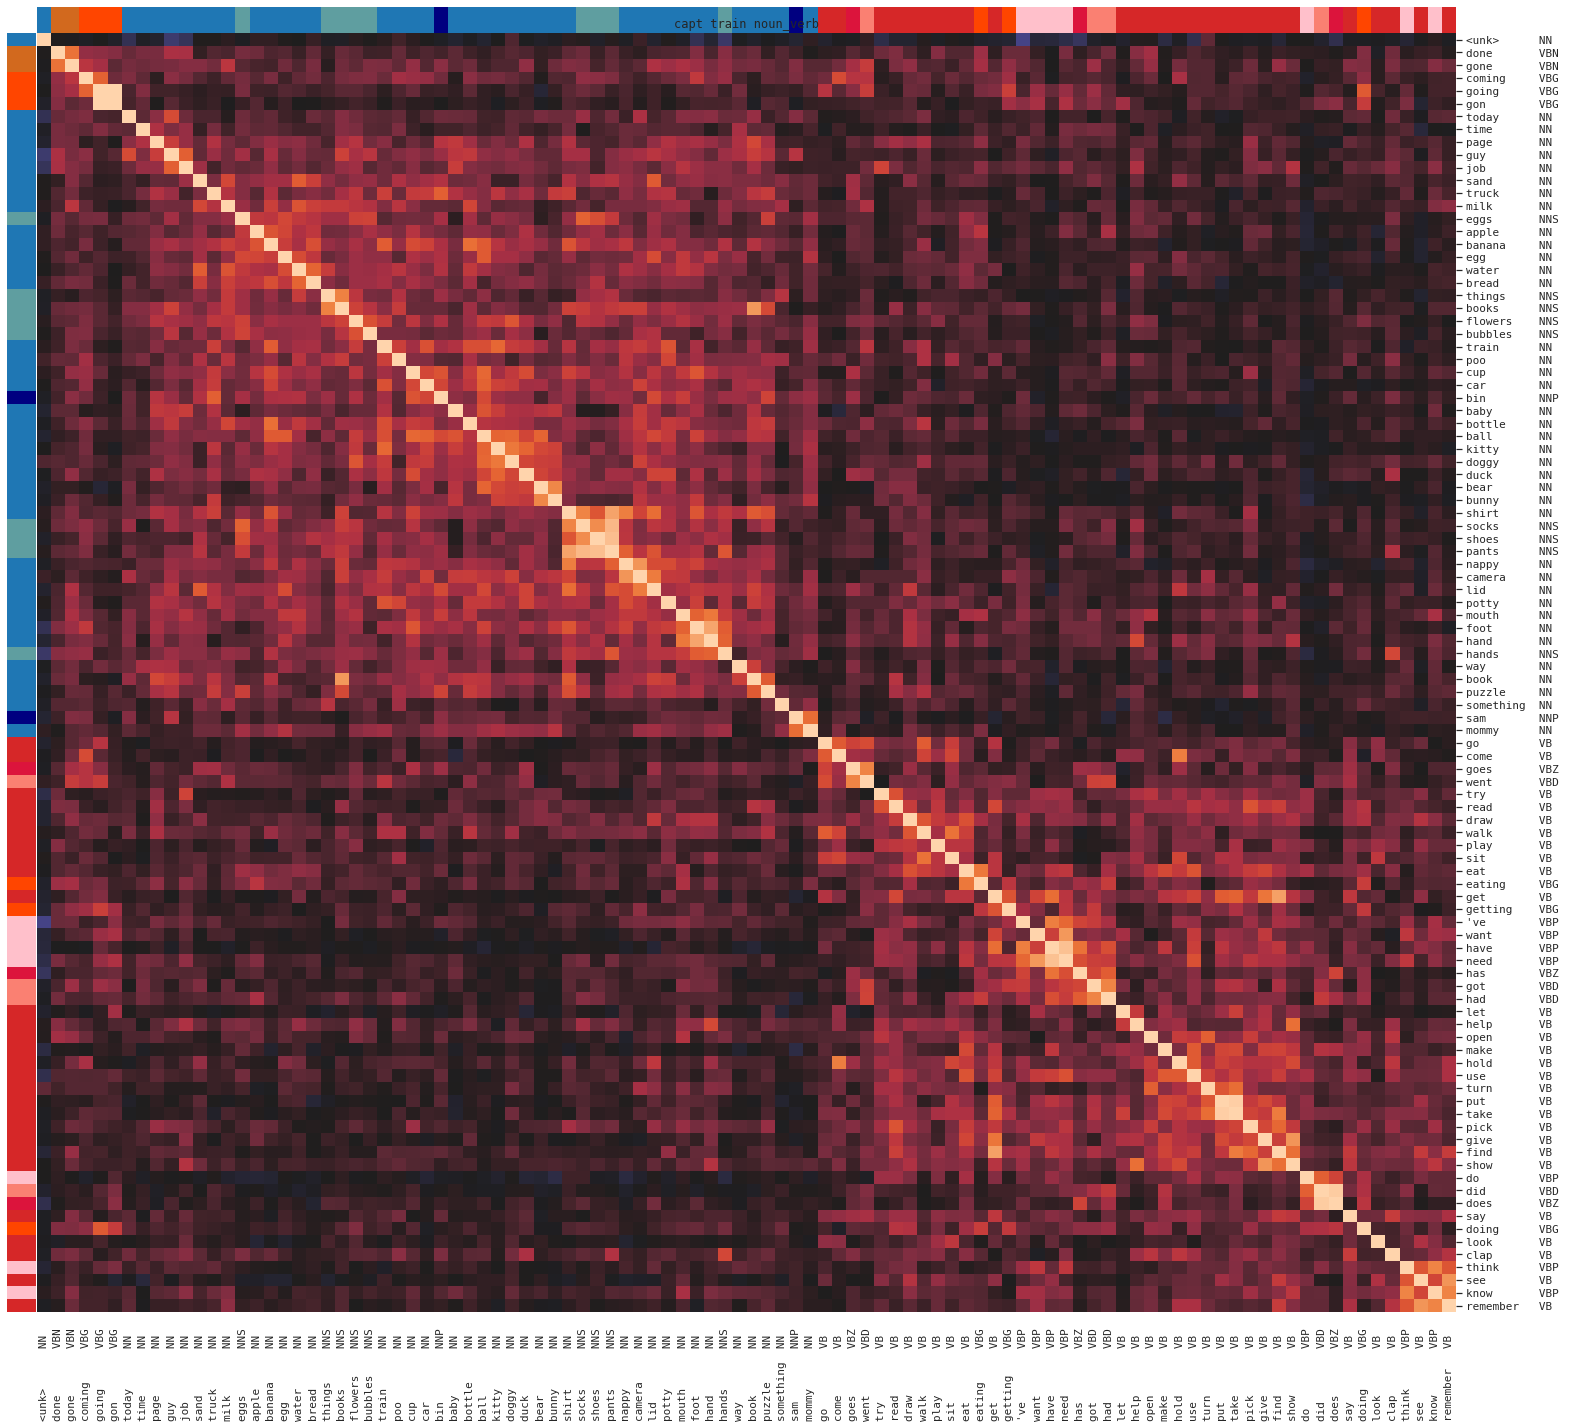

cbow:


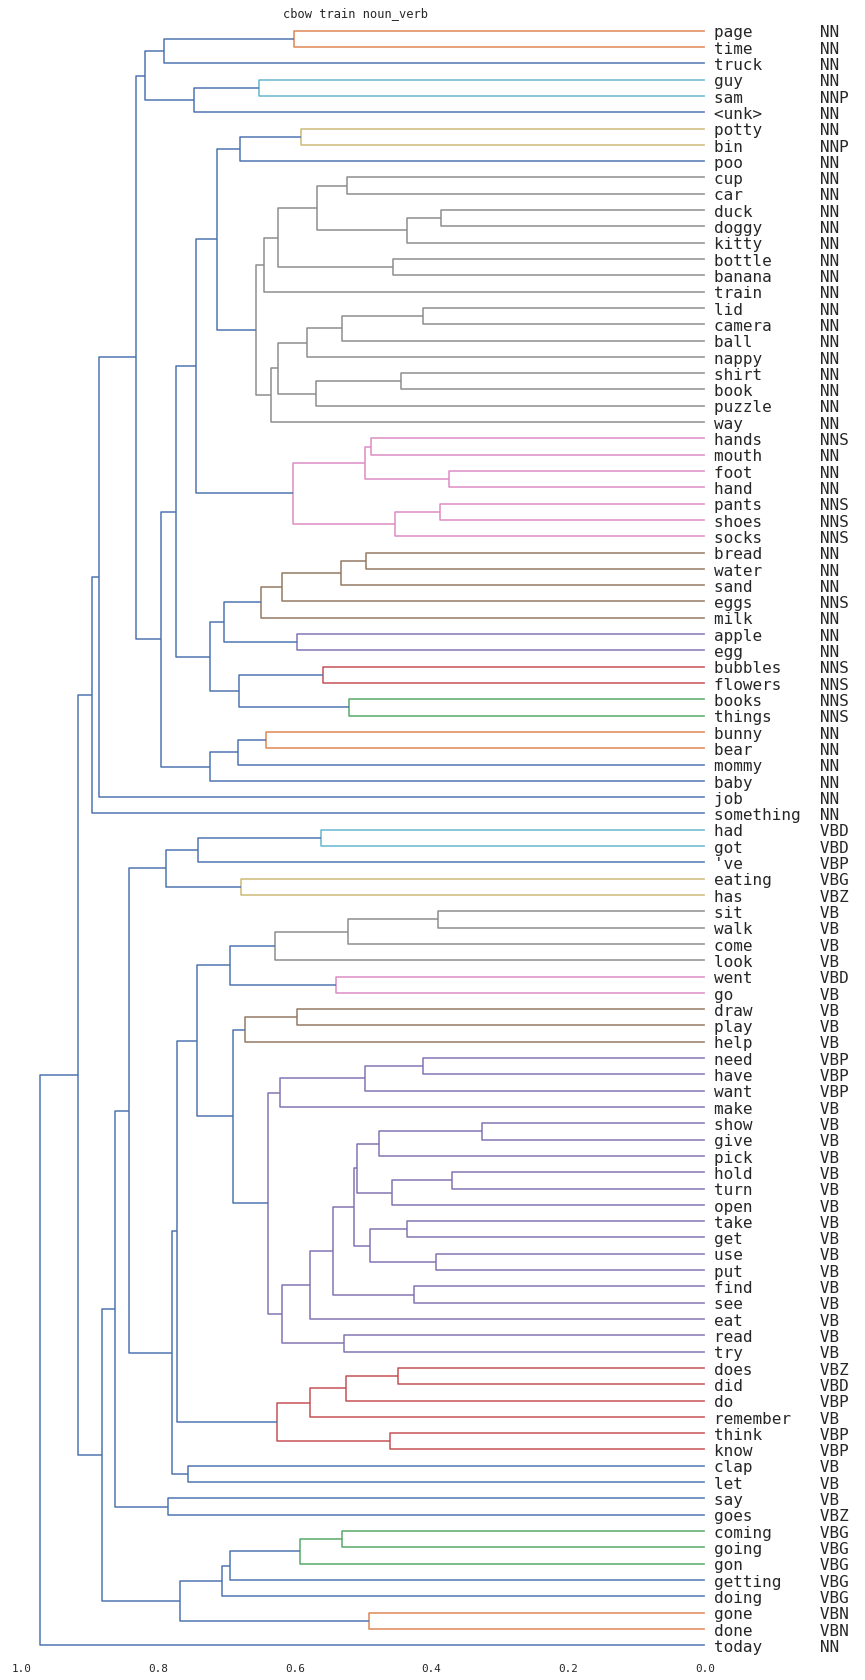

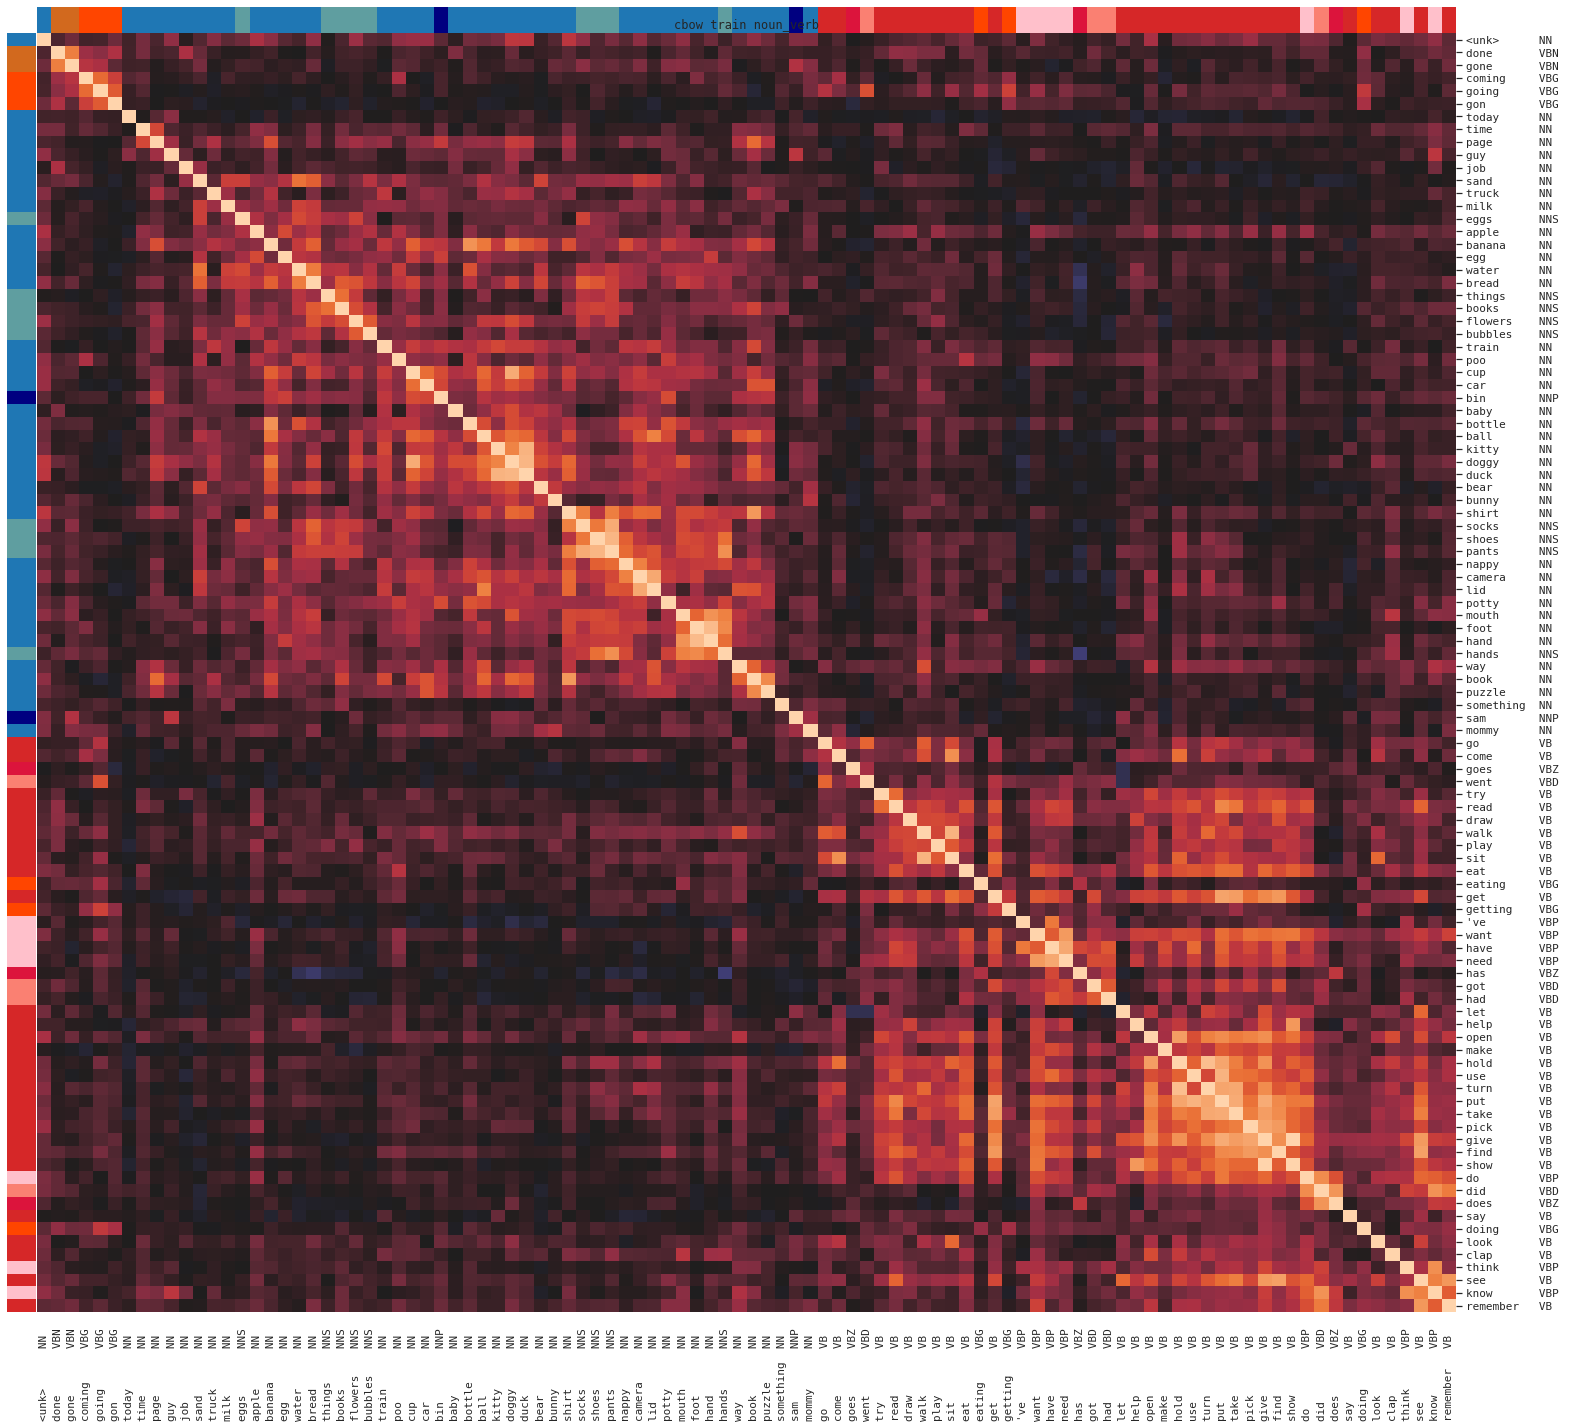

noun:


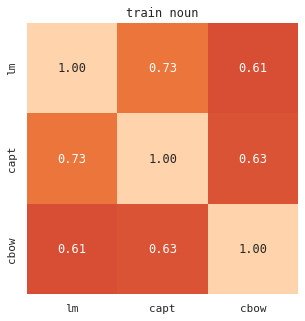

lm:


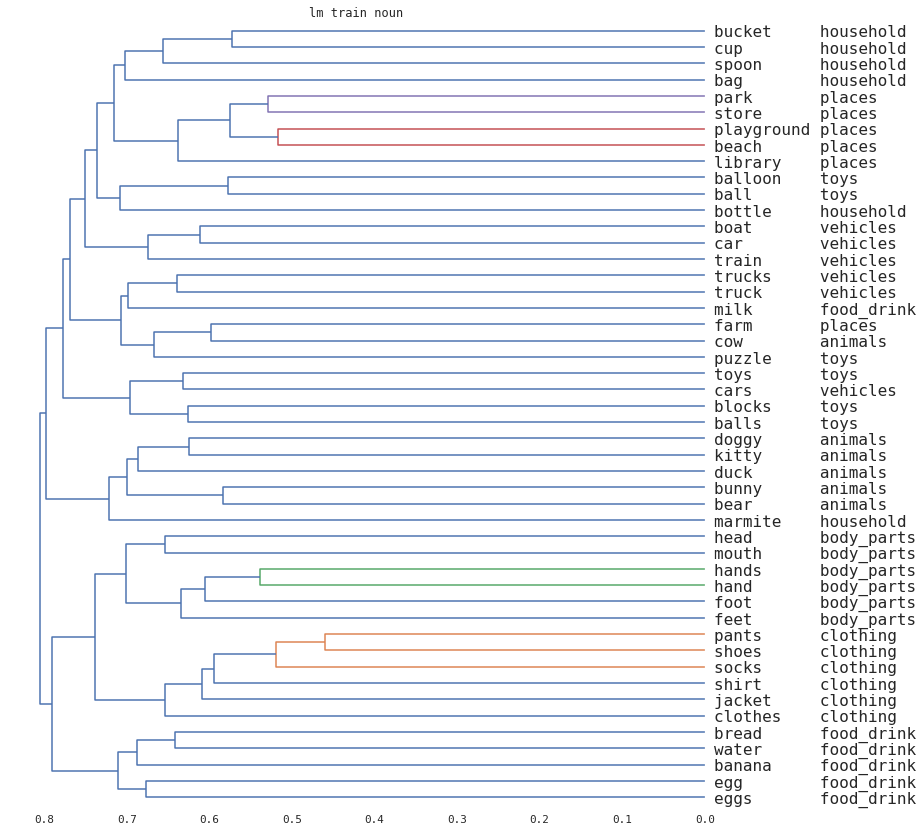

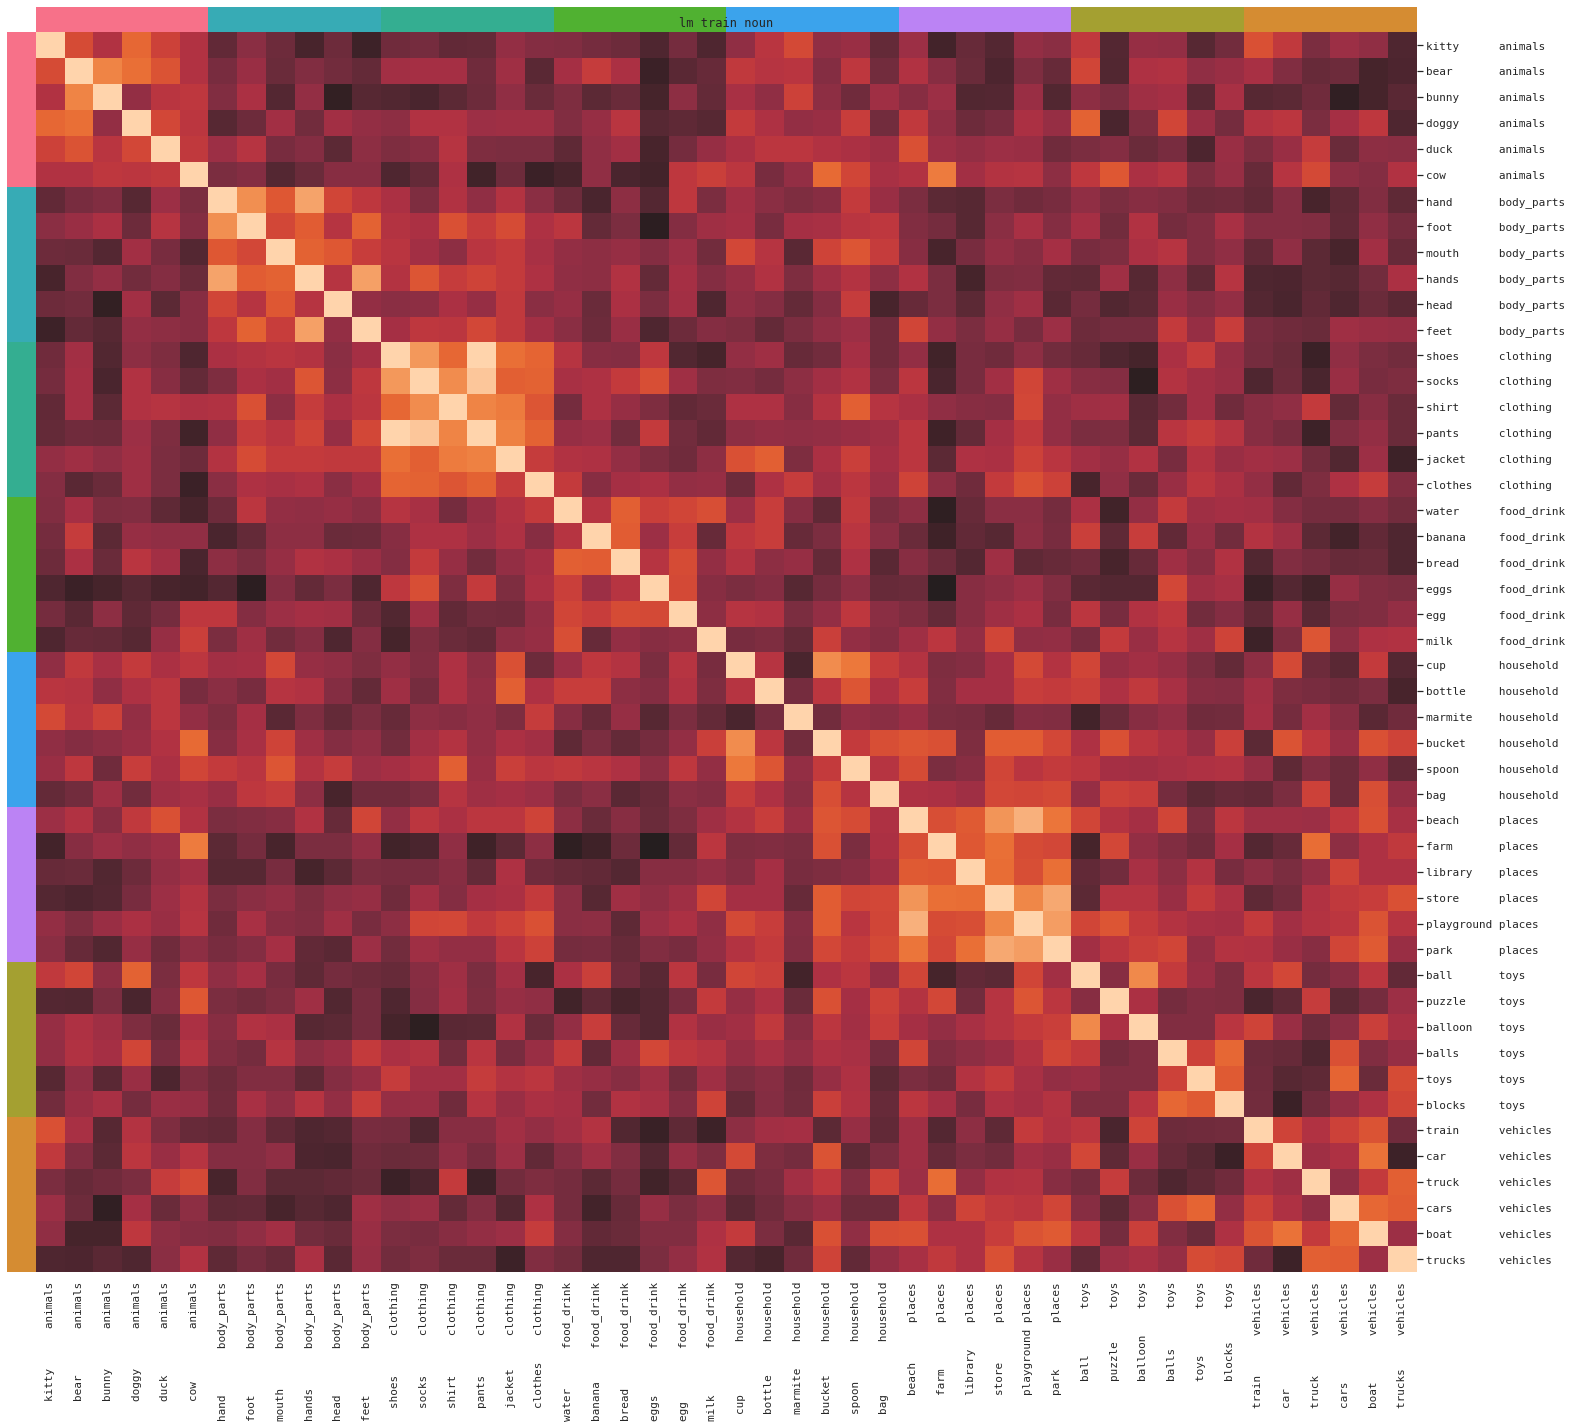

capt:


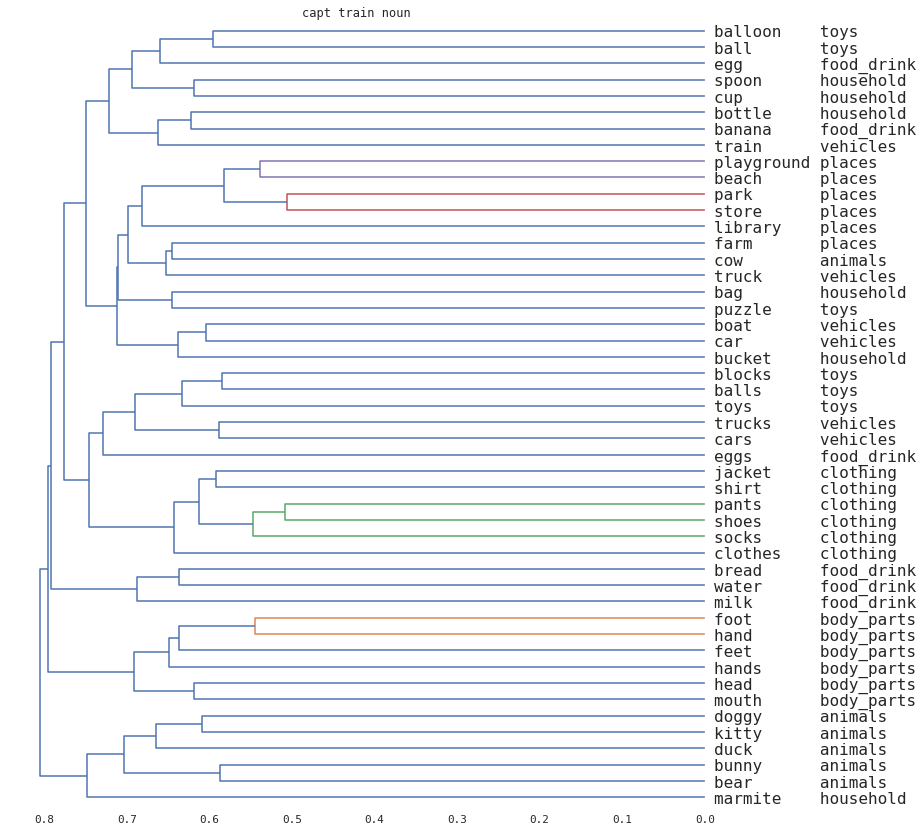

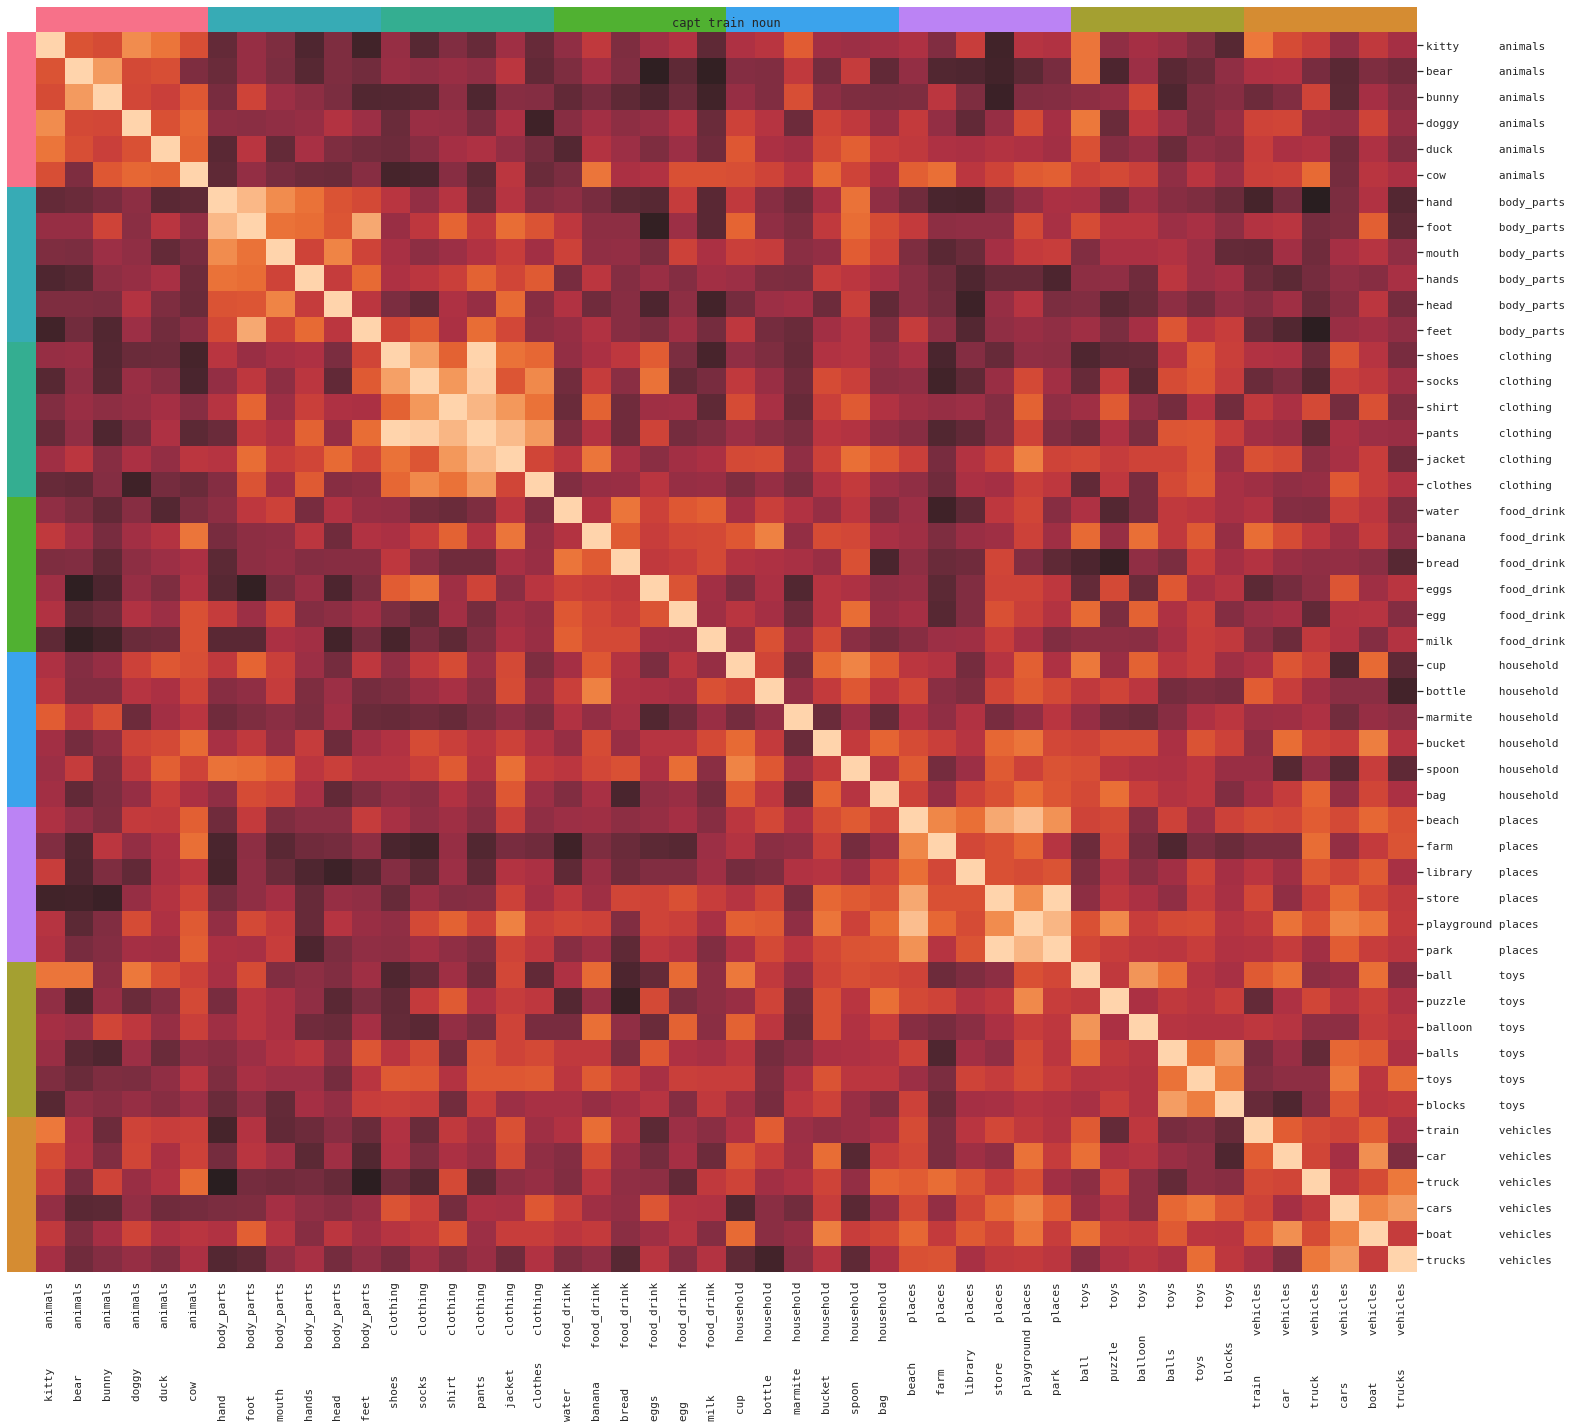

cbow:


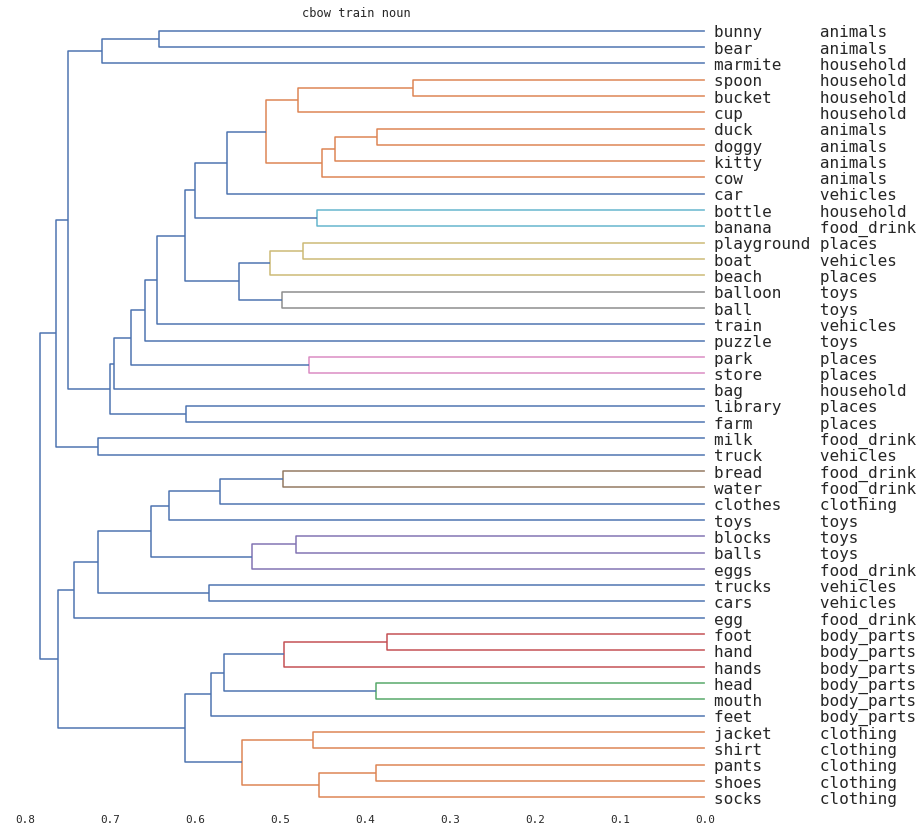

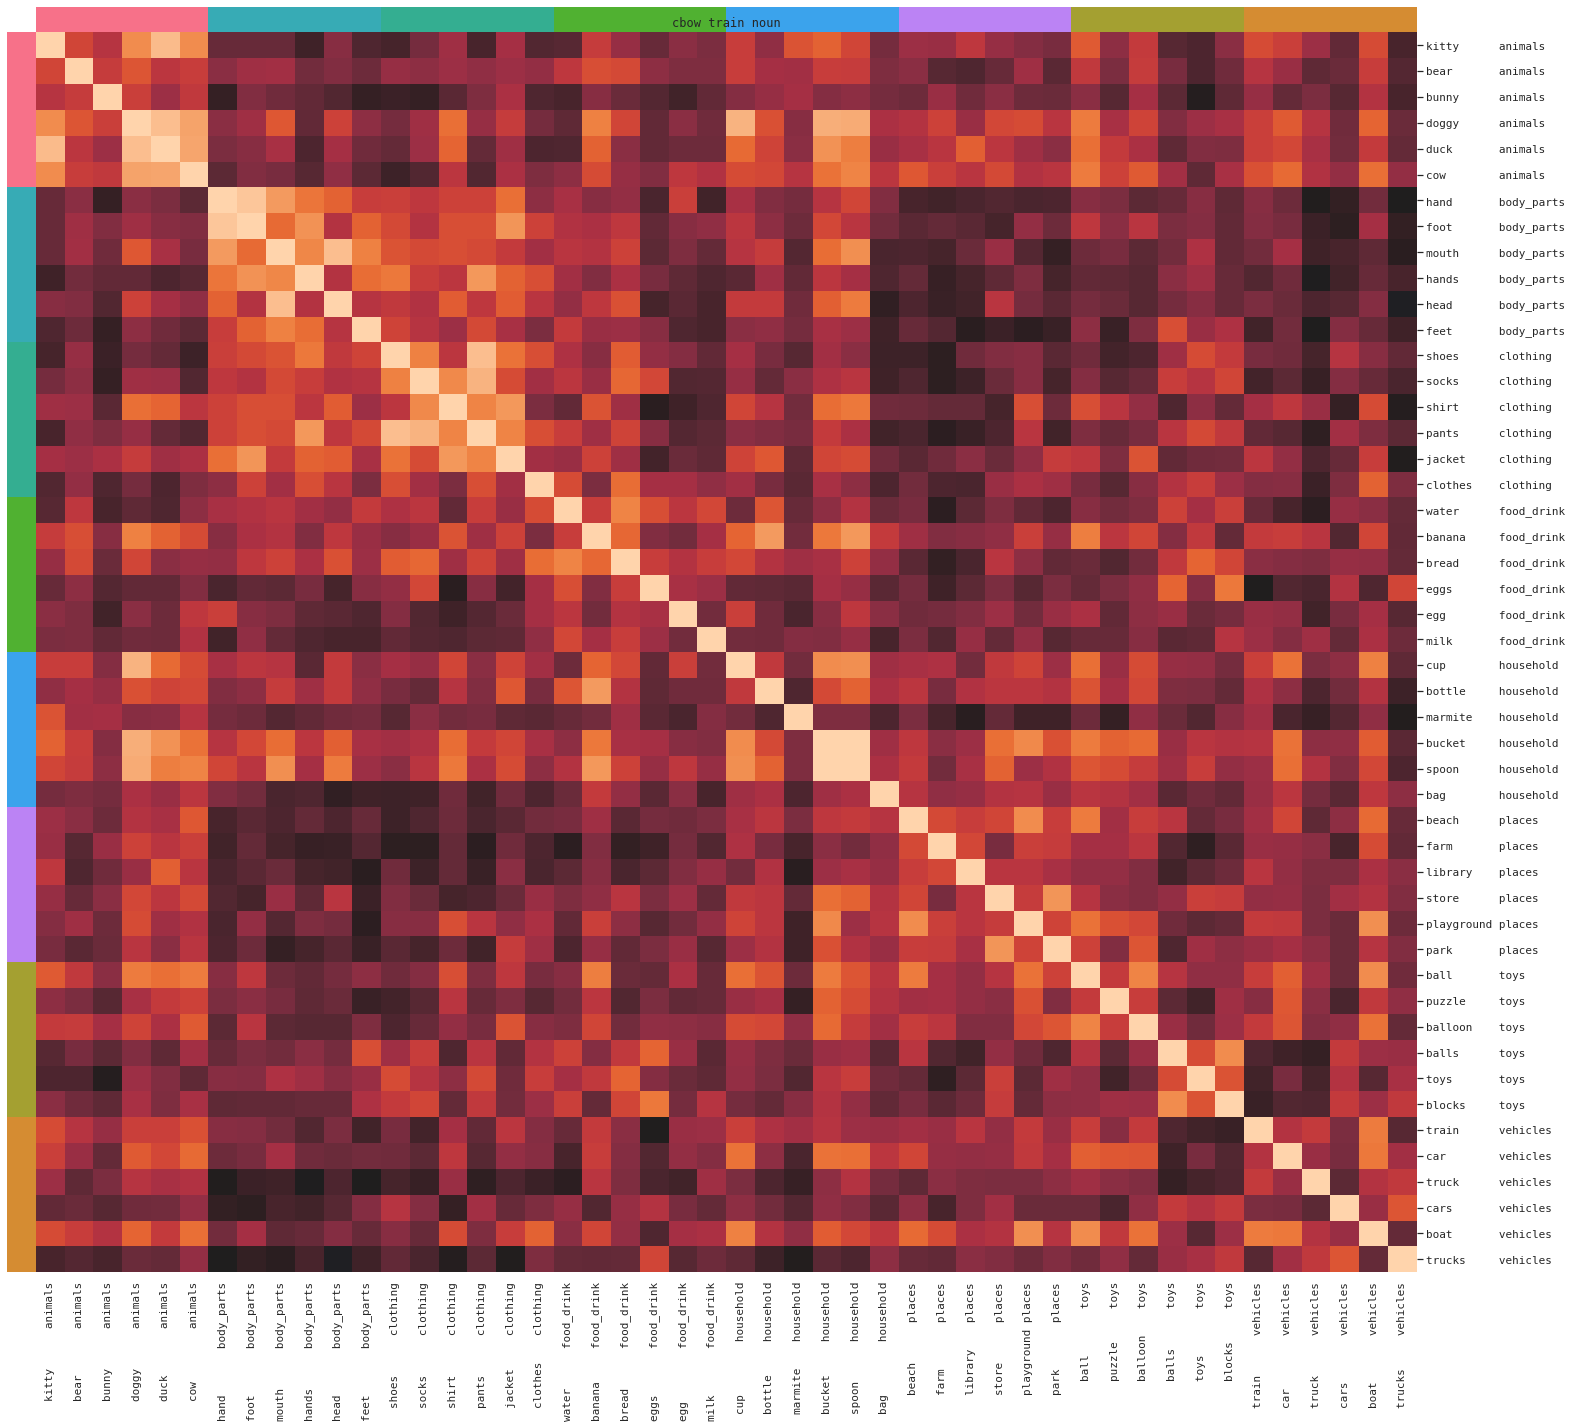

verb:


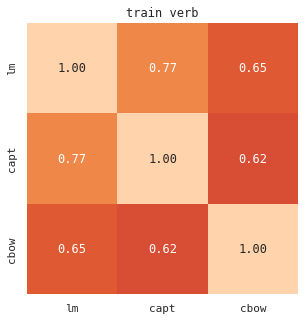

lm:


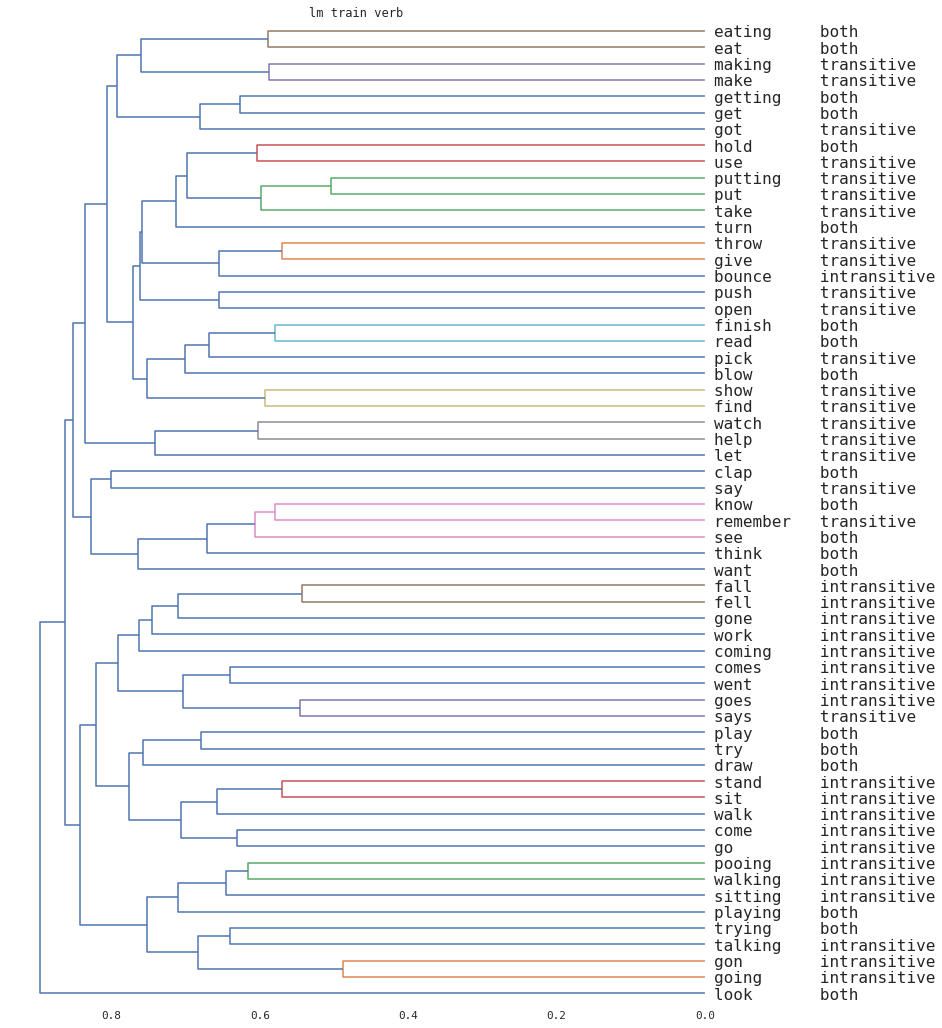

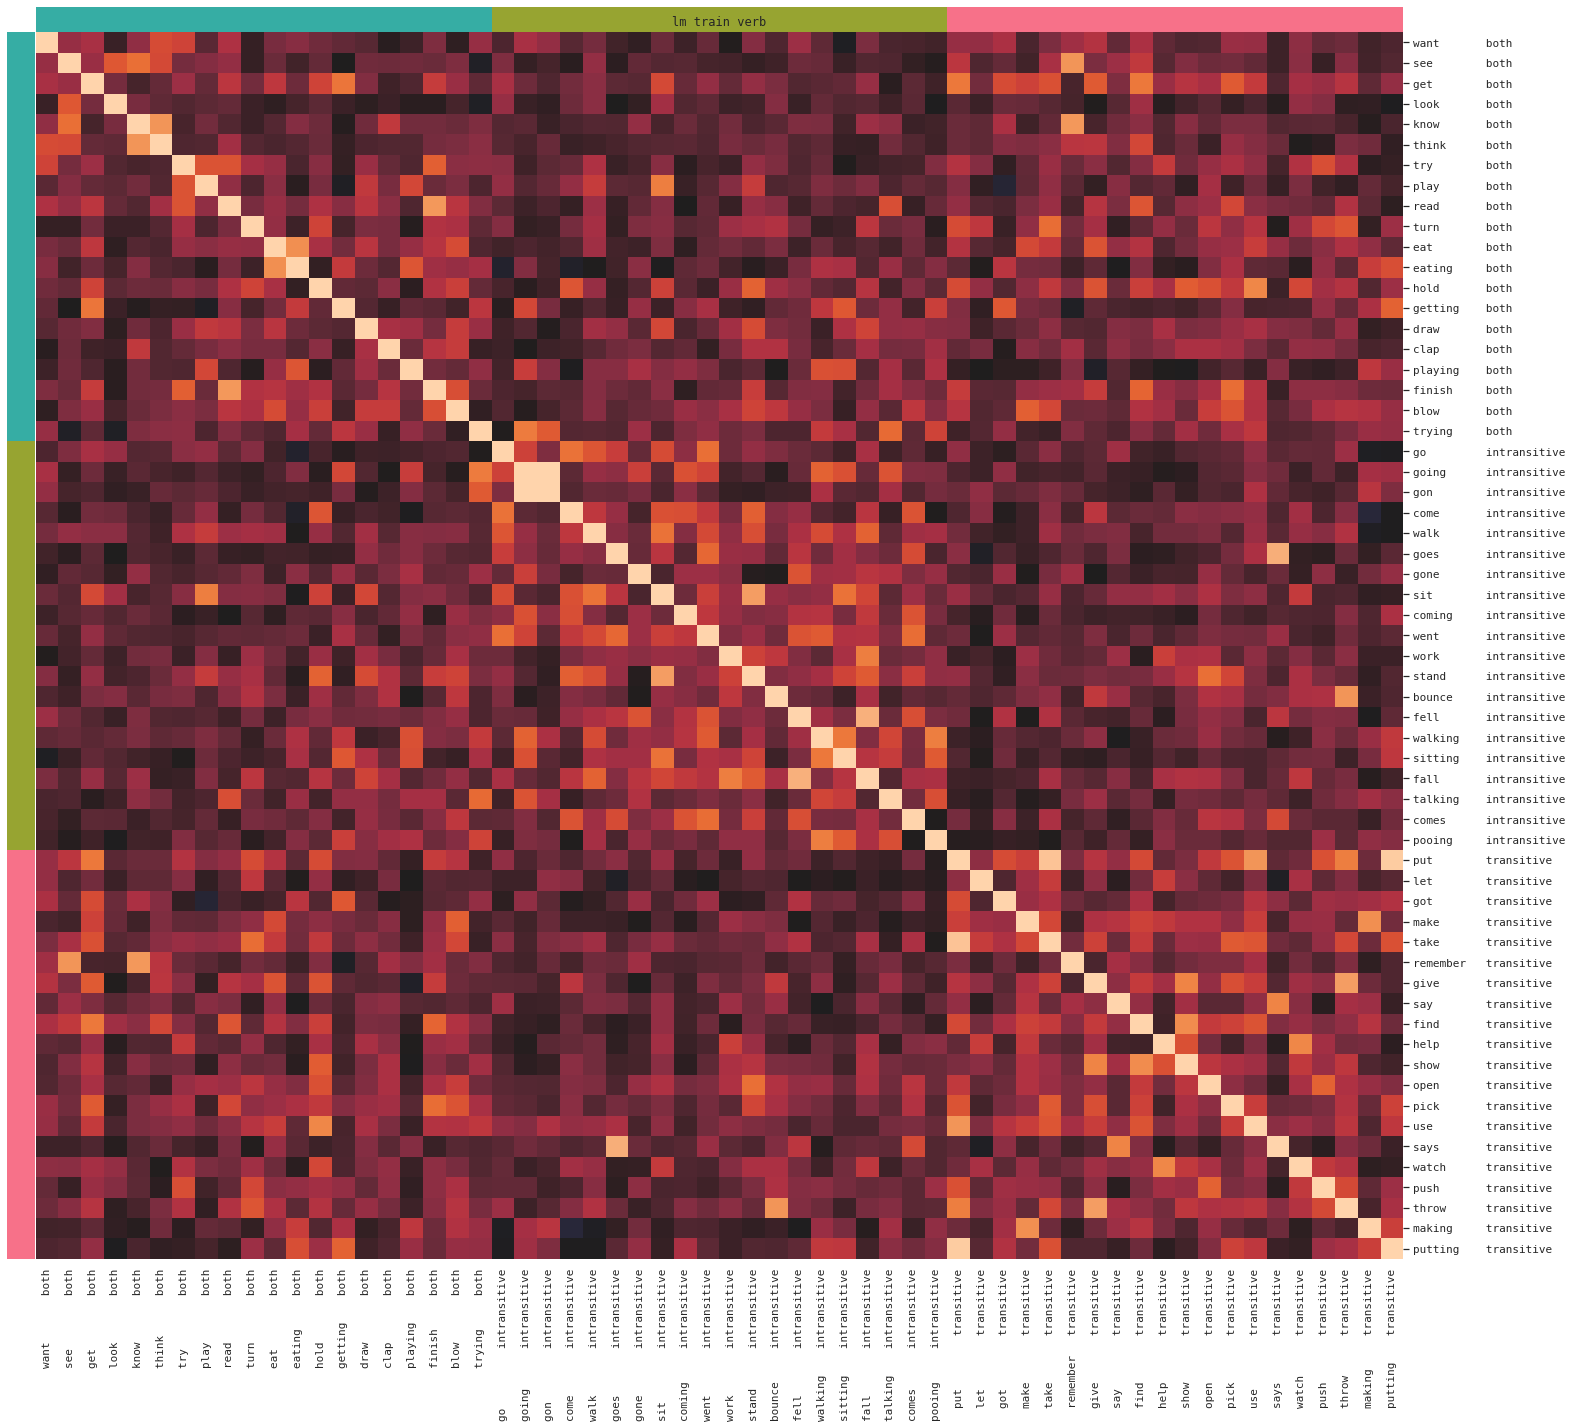

capt:


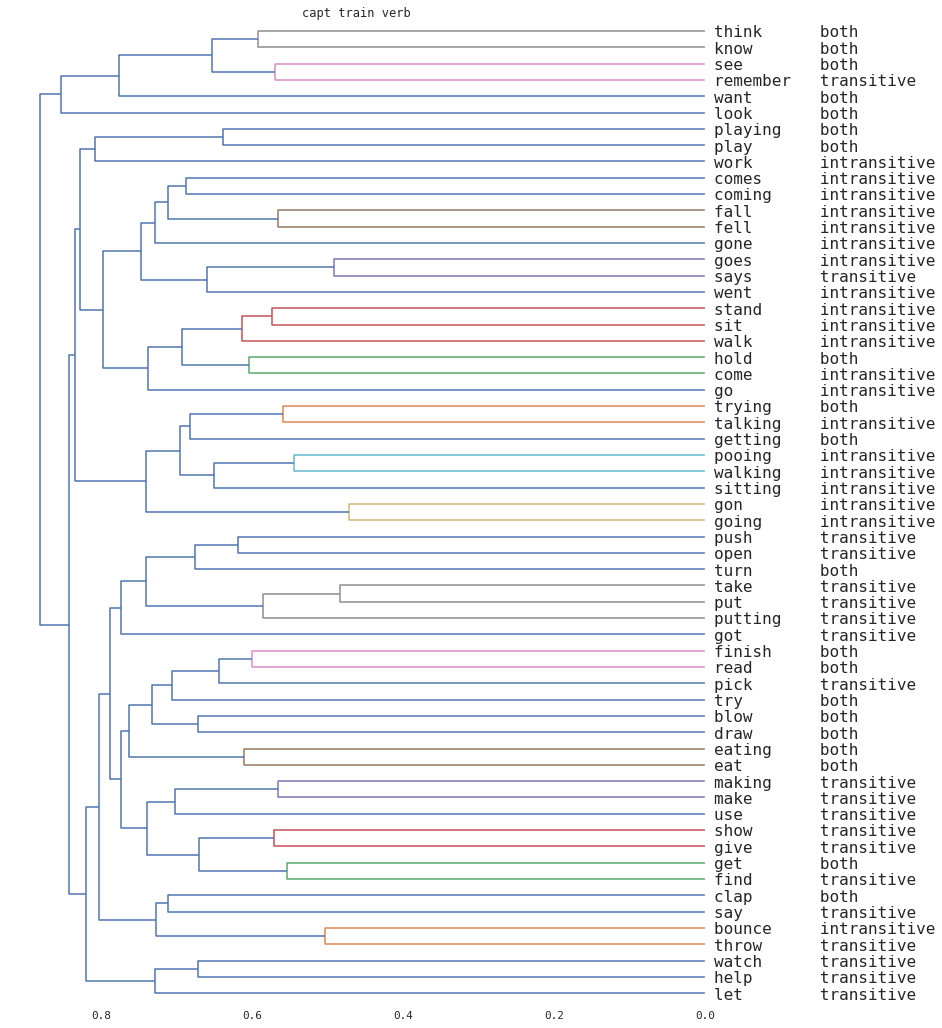

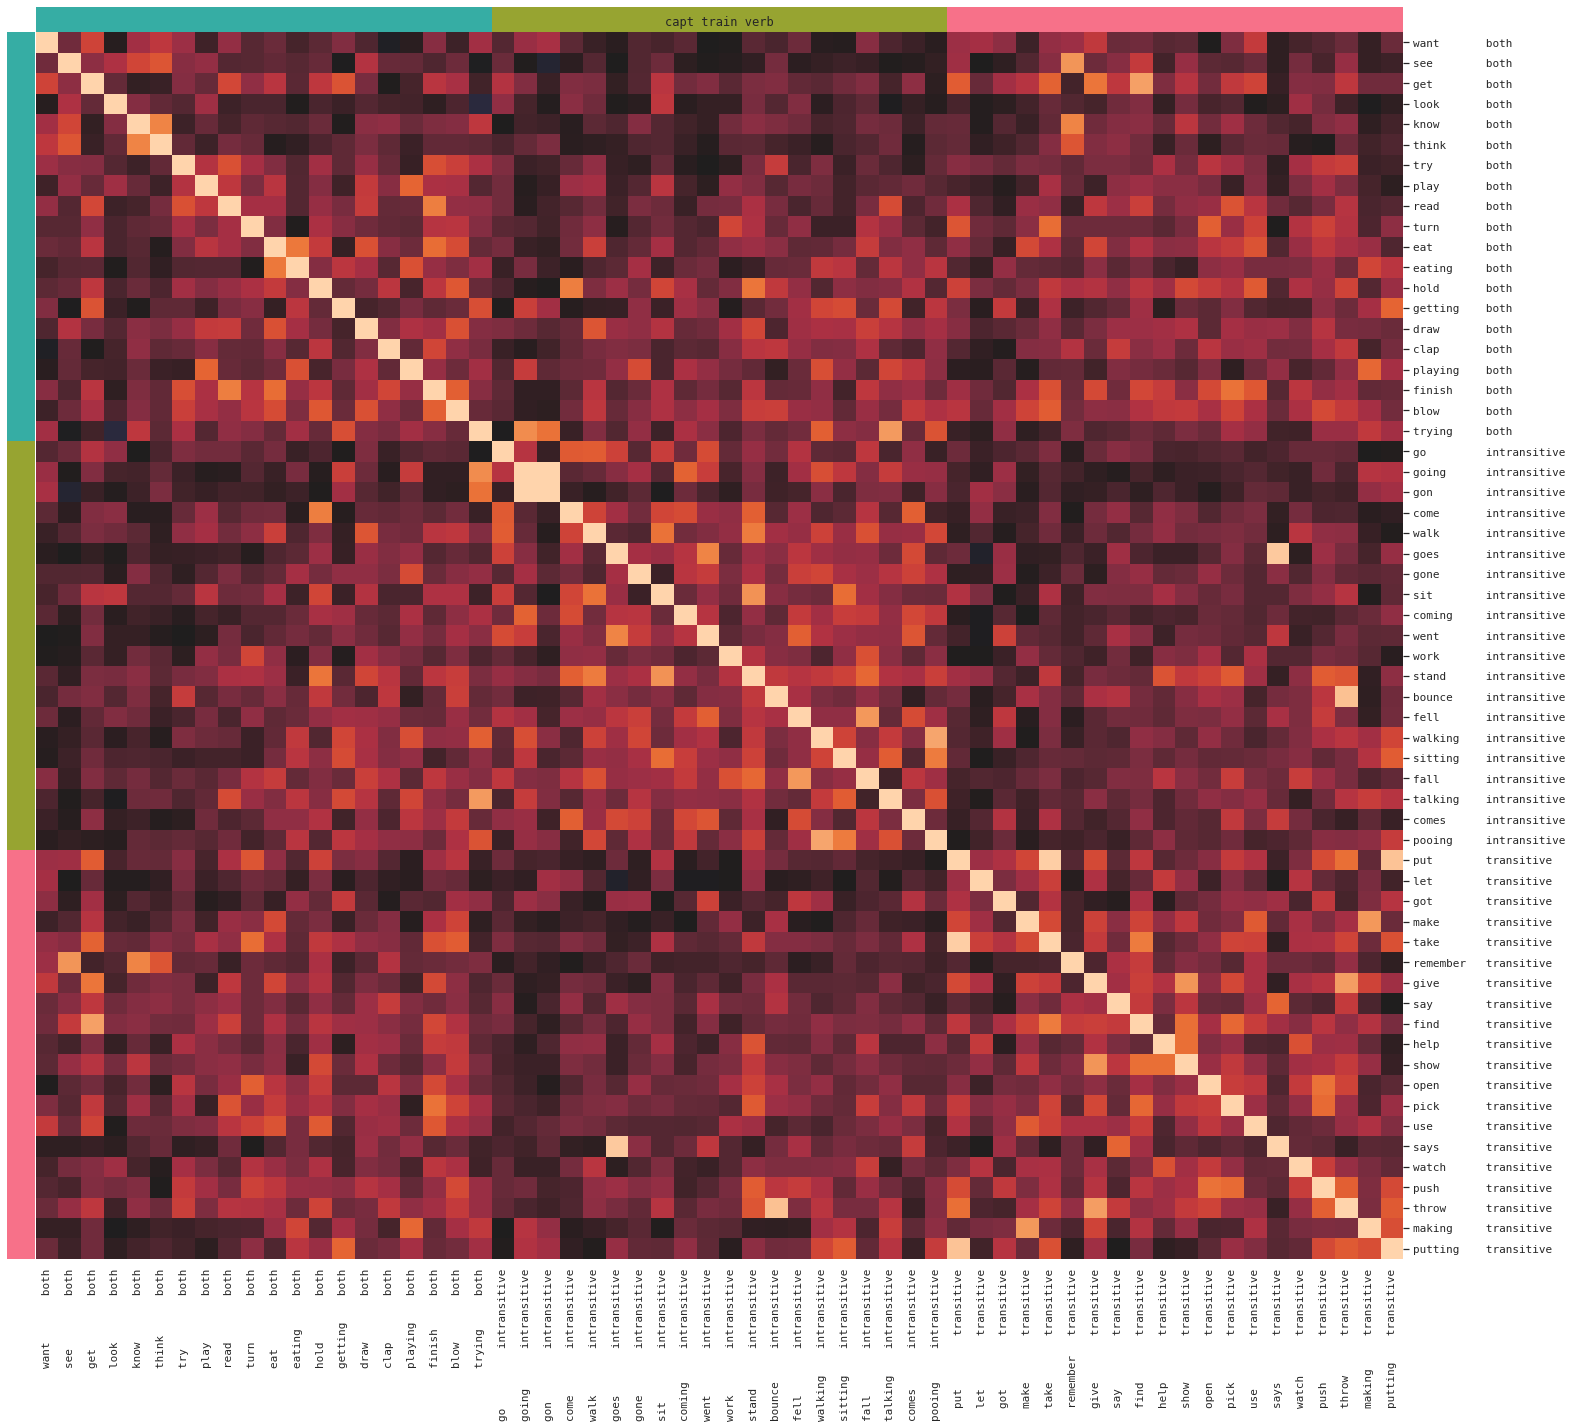

cbow:


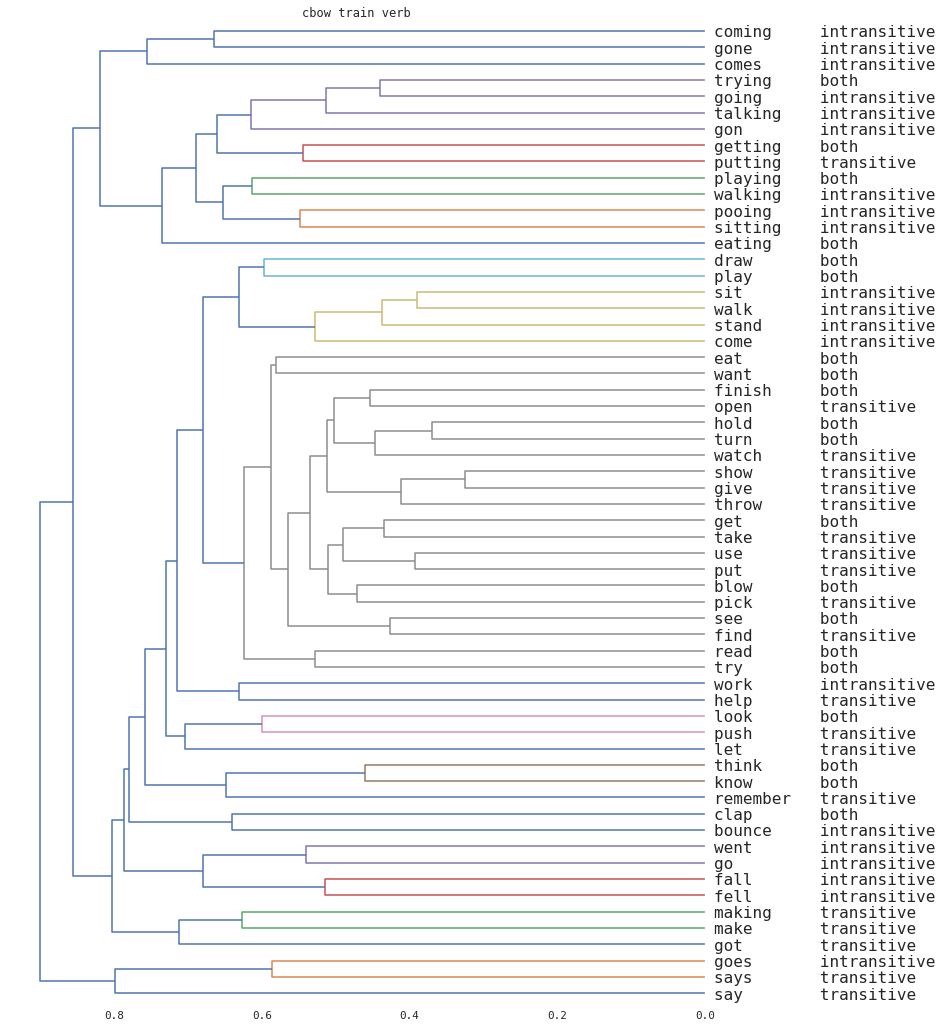

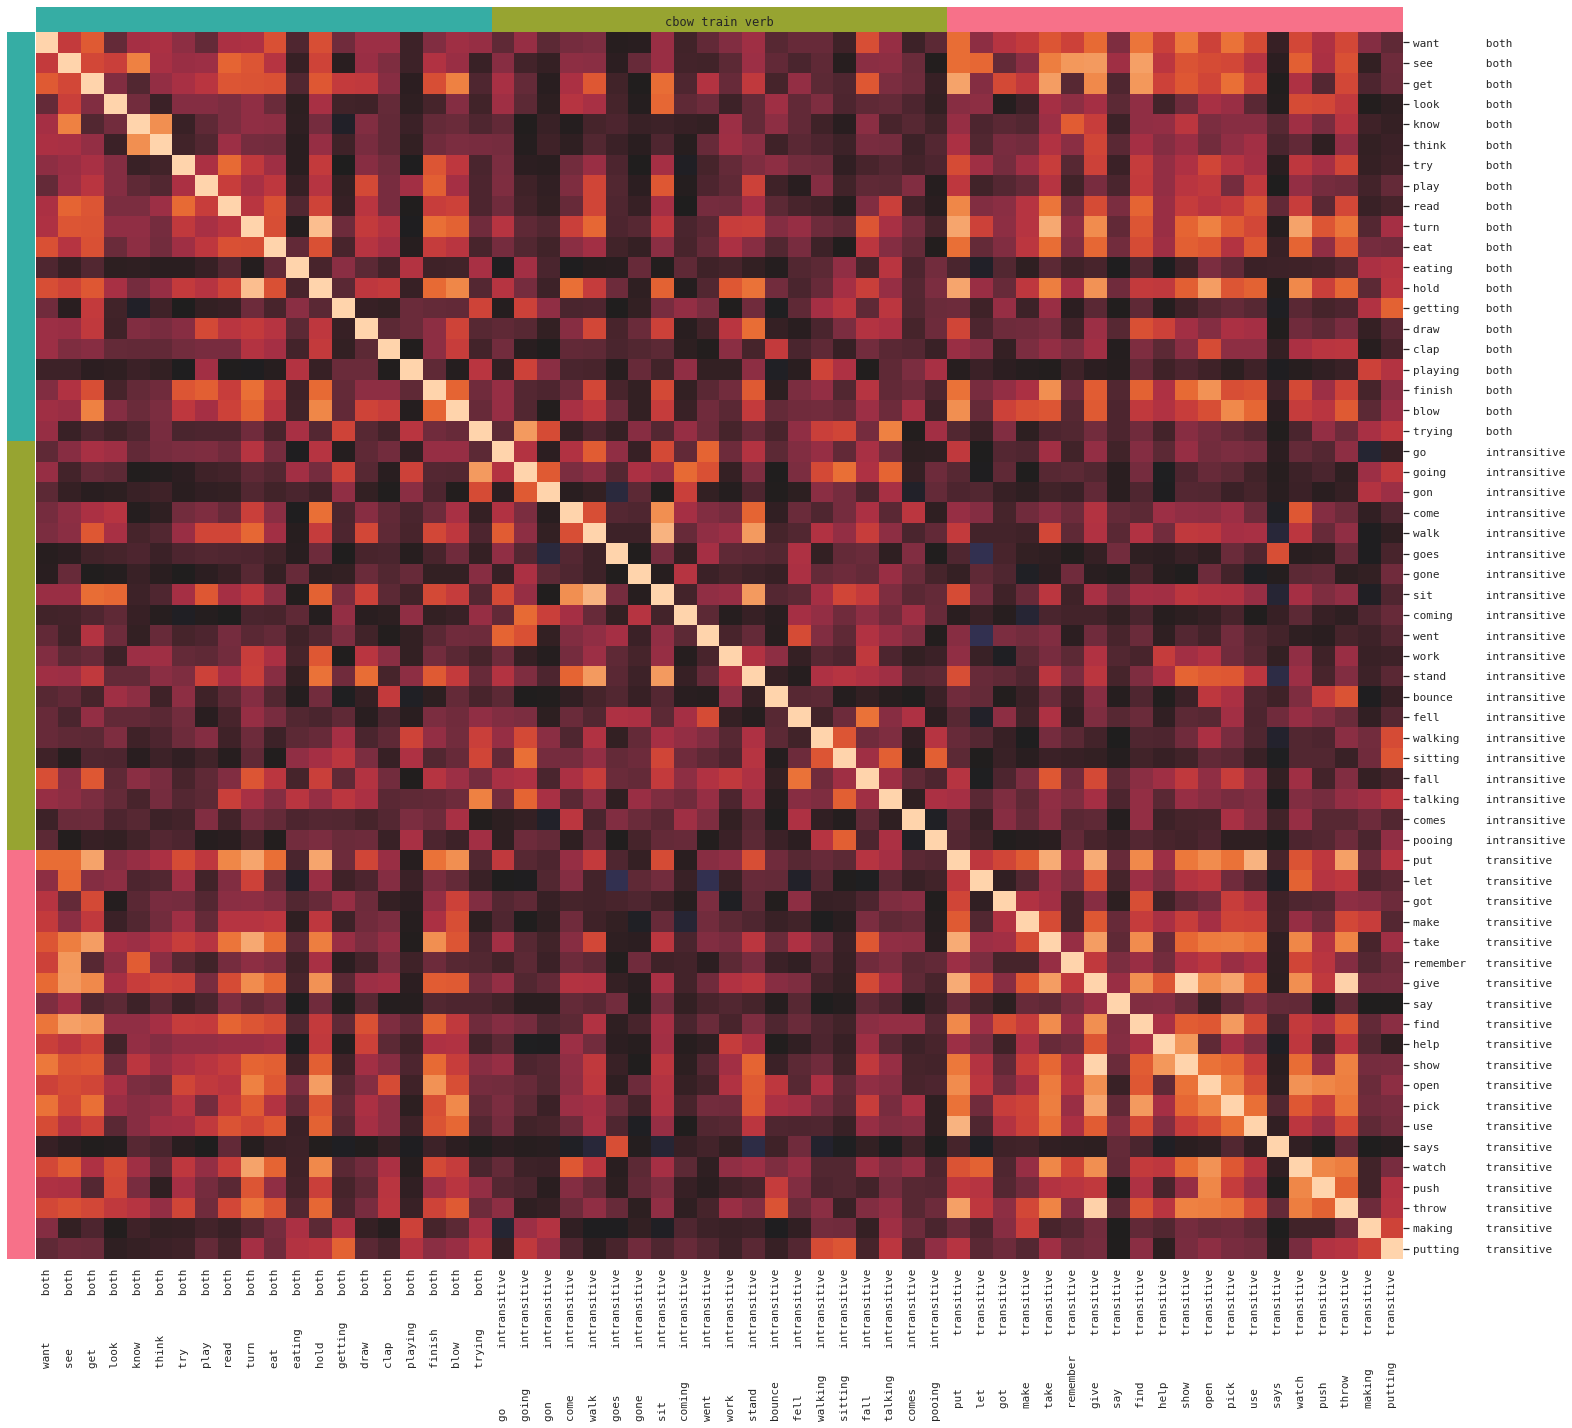

In [12]:
sns.set_theme(
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.grid': False,
        'axes.facecolor': 'white',
    }
)


def get_subcat_items(items, pos, n_items_from_each_cat=None):
    if n_items_from_each_cat is None:
        n_items_from_each_cat = {'noun': 6, 'verb': 20}[pos]
    dfs = []
    for cat_name, words in pos_subcats[pos]:
        df = items[items[token_field].isin(words)].copy()
        if len(df) >= n_items_from_each_cat:
            dfs.append(df[:n_items_from_each_cat])
    items = pd.concat(dfs)
    items[subcat_field] = items[token_field].map(word2subcat).astype('category')
    return items


for split in ['train']:
    for name, items, tag_field, ll_tag_field, heatmap_linkage in (
        ('token', split_all_pos_items[split][:100], 'pos0', 'pos', 'first'),
        ('noun_verb', split_pos_pos_items[split][('noun', 'verb')][:100], 'pos0', 'pos', 'first'),
        ('noun', get_subcat_items(split_pos_items[split]['noun'], 'noun'), subcat_field, subcat_field, 'tag'),
        ('verb', get_subcat_items(split_pos_items[split]['verb'], 'verb'), subcat_field, subcat_field, 'tag'),
    )[1:]:
        print(f'{name}:')
        plot_dendrogram(
            items,
            names,
            heatmap=True,
            heatmap_linkage=heatmap_linkage,
            title=f'{split} {name}',
            vector_attr=vector_attr,
            tag_field=tag_field,
            ll_tag_field=ll_tag_field,
            ll_with_cnt=False,
            ll_with_ppl=False,
        )

.               #: 65
adjective       #: 44
adverb          #: 45
cardinal number #: 11
function word   #: 82
noun            #: 220
verb            #: 150
plotting 1234/1234 = 100.00% items...


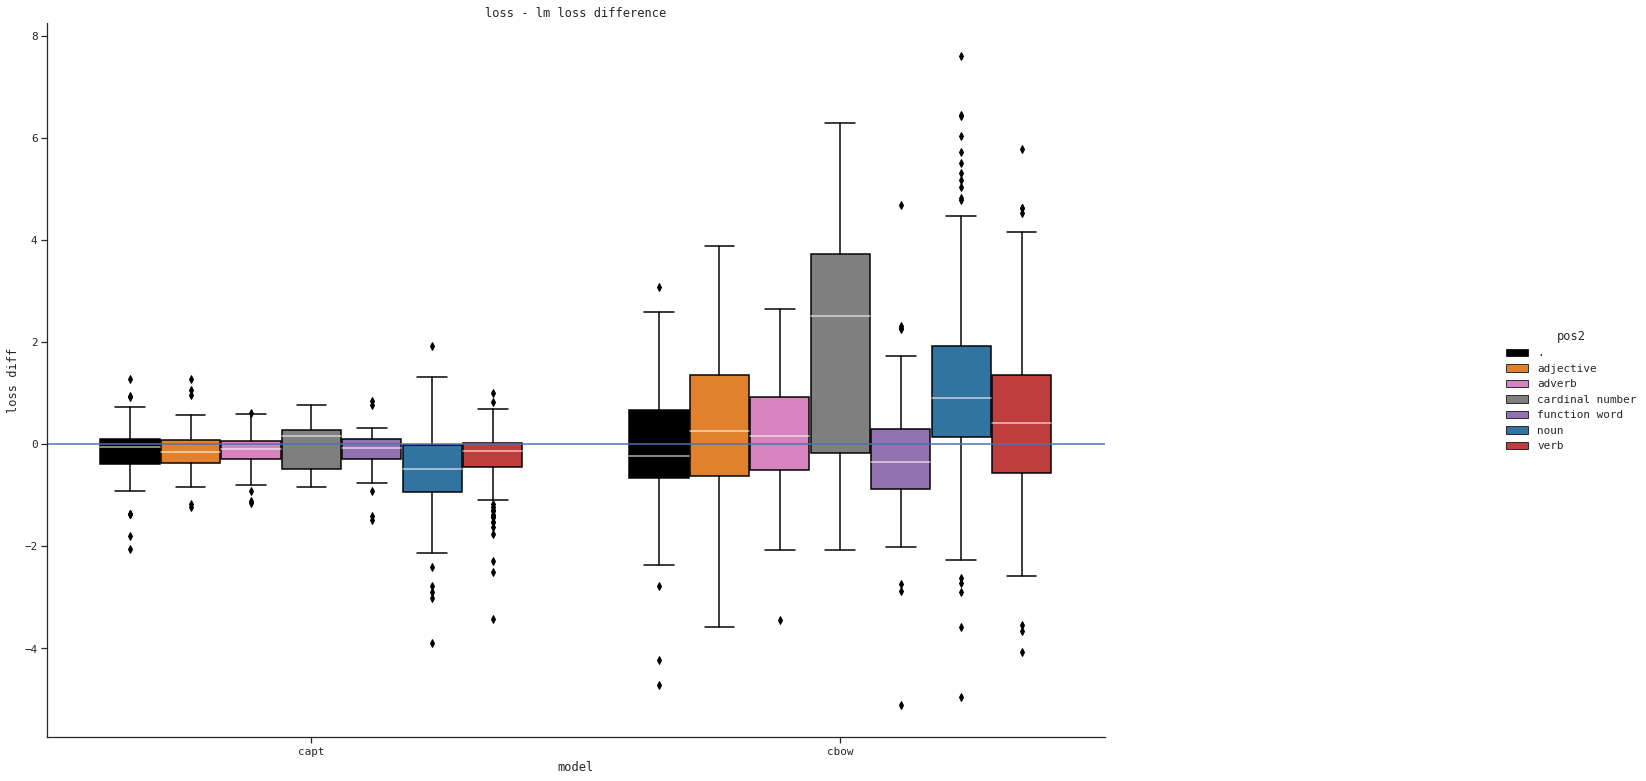

capt:
plotting 617/617 = 100.00% items...


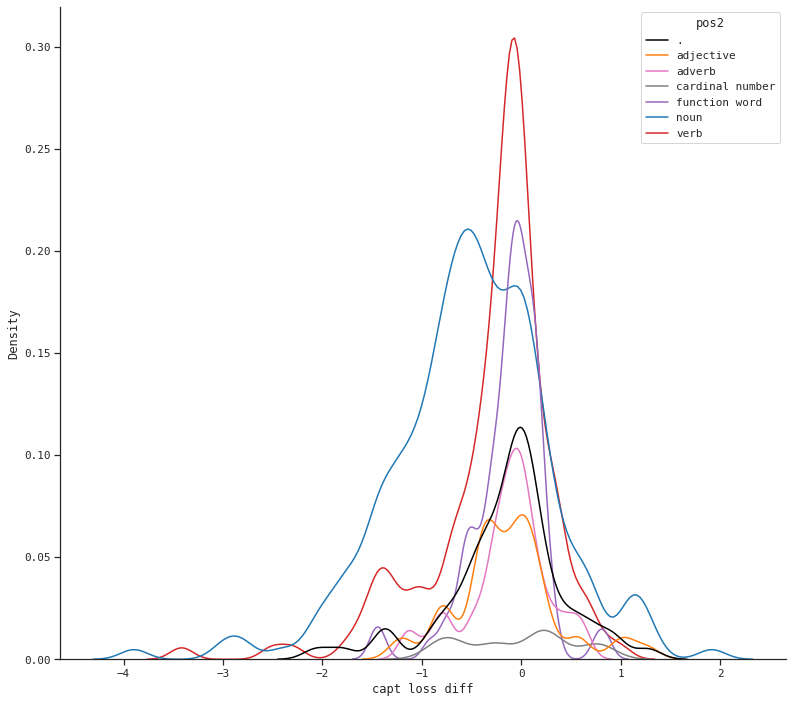

.               #examples:    65 mean: -0.155763 t-test result: statistic:  -2.09 pvalue: 0.040257
adjective       #examples:    44 mean: -0.136634 t-test result: statistic:  -1.75 pvalue: 0.086912
adverb          #examples:    45 mean: -0.135714 t-test result: statistic:  -2.23 pvalue: 0.030758
cardinal number #examples:    11 mean: -0.031279 t-test result: statistic:  -0.18 pvalue: 0.859079
function word   #examples:    82 mean: -0.130262 t-test result: statistic:  -3.25 pvalue: 0.001673
noun            #examples:   220 mean: -0.512436 t-test result: statistic:  -9.44 pvalue: 0.000000
verb            #examples:   150 mean: -0.285722 t-test result: statistic:  -5.58 pvalue: 0.000000
all tokens      #examples:   617 mean: -0.306099 t-test result: statistic: -11.42 pvalue: 0.000000
cbow:
plotting 617/617 = 100.00% items...


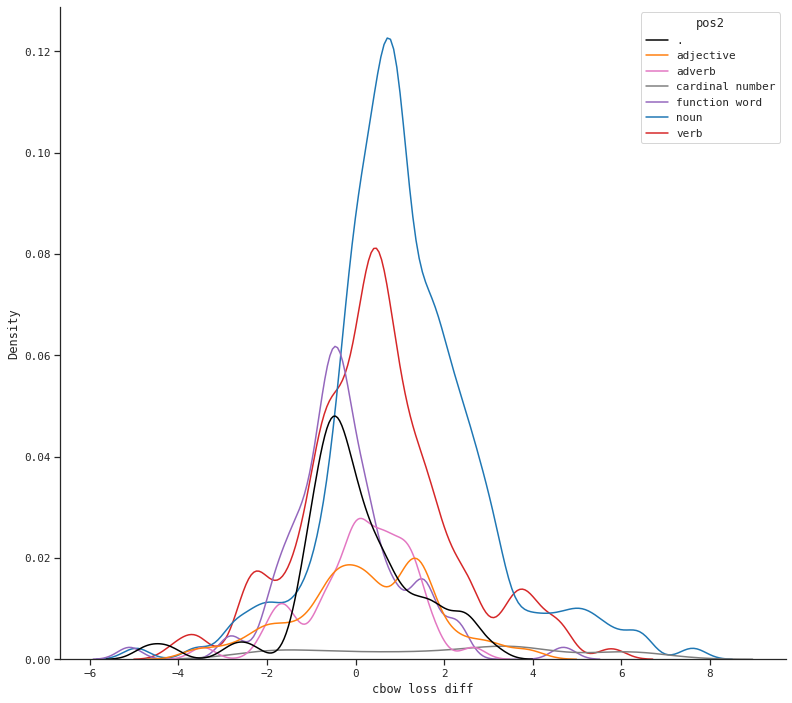

.               #examples:    65 mean: -0.032155 t-test result: statistic:  -0.18 pvalue: 0.853947
adjective       #examples:    44 mean:  0.244316 t-test result: statistic:   1.02 pvalue: 0.312841
adverb          #examples:    45 mean:  0.111819 t-test result: statistic:   0.63 pvalue: 0.529048
cardinal number #examples:    11 mean:  2.089115 t-test result: statistic:   2.40 pvalue: 0.037471
function word   #examples:    82 mean: -0.265710 t-test result: statistic:  -1.82 pvalue: 0.072510
noun            #examples:   220 mean:  1.131919 t-test result: statistic:   9.58 pvalue: 0.000000
verb            #examples:   150 mean:  0.491474 t-test result: statistic:   3.54 pvalue: 0.000542
all tokens      #examples:   617 mean:  0.547207 t-test result: statistic:   7.92 pvalue: 0.000000
.               #: 6818
adjective       #: 413
adverb          #: 740
cardinal number #: 80
function word   #: 4042
noun            #: 1406
verb            #: 2346
plotting 31690/31690 = 100.00% items...


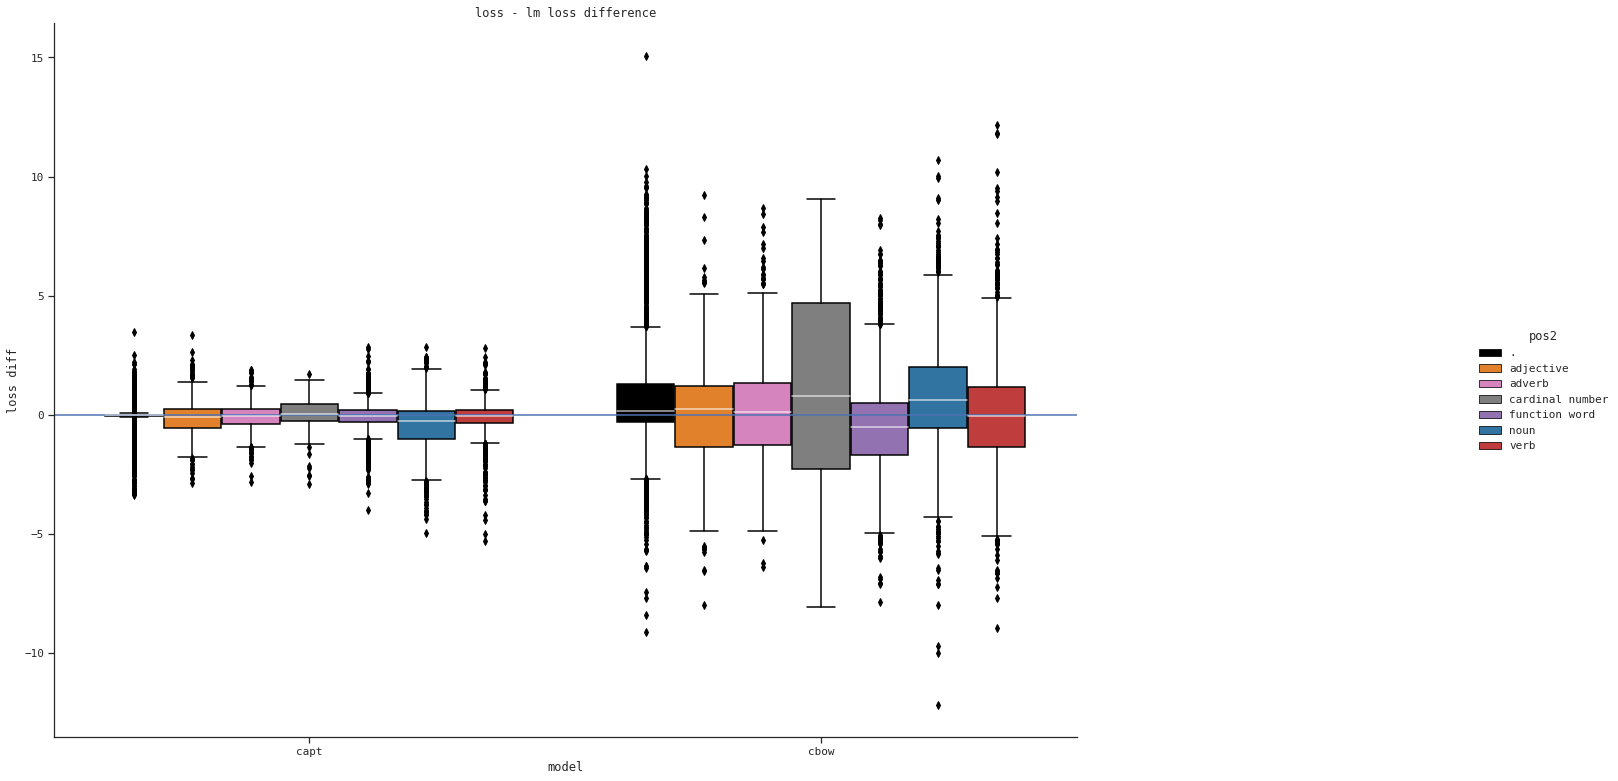

capt:
.               #examples:  6818 mean: -0.031600 t-test result: statistic:  -6.76 pvalue: 0.000000
adjective       #examples:   413 mean: -0.147666 t-test result: statistic:  -3.53 pvalue: 0.000457
adverb          #examples:   740 mean: -0.068404 t-test result: statistic:  -3.14 pvalue: 0.001736
cardinal number #examples:    80 mean: -0.058789 t-test result: statistic:  -0.58 pvalue: 0.561255
function word   #examples:  4042 mean: -0.059458 t-test result: statistic:  -7.00 pvalue: 0.000000
noun            #examples:  1406 mean: -0.422224 t-test result: statistic: -14.96 pvalue: 0.000000
verb            #examples:  2346 mean: -0.114733 t-test result: statistic:  -8.64 pvalue: 0.000000
all tokens      #examples: 15845 mean: -0.090558 t-test result: statistic: -19.27 pvalue: 0.000000
cbow:
.               #examples:  6818 mean:  0.695907 t-test result: statistic:  29.18 pvalue: 0.000000
adjective       #examples:   413 mean:  0.057357 t-test result: statistic:   0.49 pvalue: 0.62542

In [13]:
from scipy.stats import ttest_rel


def get_best_split_accuracy(label_0, label_1):
    n_label_0 = label_0.value_counts()[True]
    n_label_1 = label_1.value_counts()[True]

    i = 0
    count_0 = 0
    count_1 = n_label_1

    best_i, best_n = i, count_0 + count_1

    for label_i_0, label_i_1 in zip(label_0, label_1):
        count_0 += label_i_0
        count_1 -= label_i_1
        i += 1

        if count_0 + count_1 > best_n:
            best_i, best_n = i, count_0 + count_1

    print(f'n_label_0: {n_label_0}, n_label_1: {n_label_1}, best_accuracy: {best_n / (n_label_0 + n_label_1):.2%}')
    return best_i, best_n / (n_label_0 + n_label_1)


def plot_ROC(y_true, y_score, pos_label=None, label="", **kwargs):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{label} (AUC = {roc_auc:0.2f})",
        **kwargs,
    )


def plot_ROC_end(title="", **kwargs):
    plt.plot([0, 1], [0, 1], **kwargs)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} ROC")
    plt.legend(loc="lower right")
    plt.show()


def ttest(a, label, alternative):
    result = ttest_rel(a, np.zeros_like(a), alternative=alternative)
    print(f'{label:15} #examples: {len(a):5} mean: {np.mean(a):9.6f} t-test result: statistic: {result.statistic:6.2f} pvalue: {result.pvalue:8.6f}')


sns.set_theme(
    style="ticks",
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)


def analyze_value_diff(
    value_diff_items,
    value_attr,
    names,
    baseline_name=None,
    cat_field="pos2",
    palette=pos_palette,
    find_best_threshold=False,
    plotting=True,
    ROC=False,
    ttest_alternative='less',
):
    """
    value_diff_items: items
    value_attr: column in value_diff_items; e.g., 'loss', 'prob'
    names: names of the models to analyze
    baseline_name: name of the model as the baseline
    cat_field: the category field
    palette: the palette for the categories; a dict mapping each category name to a color
    """

    for cat in value_diff_items.dtypes[cat_field].categories:
        items = value_diff_items[value_diff_items[cat_field] == cat]
        if len(items) > 0:
            print(f'{cat:15} #: {len(items)}')
    value_diff_items_long = value_diff_items.melt(id_vars=[cat_field], value_vars=[f'{name} {value_attr} diff' for name in names[1:] if 'contrastive' not in name], var_name='model', value_name=f'{value_attr} diff')
    value_diff_items_long['model'] = value_diff_items_long['model'].map(lambda s: s[:-len(f' {value_attr} diff')])
    plot(sns.catplot, value_diff_items_long, x='model', y=f'{value_attr} diff', hue=cat_field, palette=palette, hlines=[0], kind="box", figsize=(26, 12), medianprops=dict(color="white", alpha=0.7), title=f"{value_attr} - lm {value_attr} difference")

    # use the first name as the baseline by default
    if baseline_name is None:
        baseline_name = names[0]

    for name in filter(lambda name: name != baseline_name and 'contrastive' not in name, names):
        print(f'{name}:')
        value_diff_field = f"{name} {value_attr} diff"
        items = value_diff_items.sort_values(value_diff_field)

        if find_best_threshold:
            assert cat_field == "pos2"
            label_0 = items[cat_field].isin(["noun"])
            label_1 = ~label_0 #items[cat_field].isin(["function word", "adjective", "adverb", "cardinal number"])
            best_split_i, best_split_acc = get_best_split_accuracy(label_0, label_1)
            print(f'best_split_accuracy: {best_split_acc:.2%}')
            threshold = items.iloc[min(best_split_i, len(items)-1)][value_diff_field]

        if plotting:
            plot(sns.kdeplot, items, x=value_diff_field, hue=cat_field, palette=palette, bw_adjust=.5, figsize=figsize)

            if ROC:
                for cat in items.dtypes[cat_field].categories:
                    plot_ROC(items[cat_field], -items[value_diff_field], pos_label=cat, label=f"{cat} vs others", color=palette[cat])
                plot_ROC_end(title=value_diff_field)

        for cat in items.dtypes[cat_field].categories:
            ttest(items.loc[items[cat_field] == cat, value_diff_field], cat, ttest_alternative)
        ttest(items[value_diff_field], "all tokens", ttest_alternative)


value_field = 'loss'
ttest_alternative = 'two-sided'

for split in ['val']:
    token_items = split_items[split].token_items
    analyze_value_diff(token_items[token_items['cnt'] >= 2], value_field, names, ttest_alternative=ttest_alternative)

    all_token_items = split_items[split].all_token_items
    if all_token_items is not None:
        print('=' * 100)
        analyze_value_diff(all_token_items.reset_index(drop=True), value_field, names, plotting=False, ttest_alternative=ttest_alternative)

#: 409
animals         #: 99
body_parts      #: 35
clothing        #: 44
food_drink      #: 76
games_routines  #: 4
household       #: 40
places          #: 10
toys            #: 55
vehicles        #: 46
plotting 818/818 = 100.00% items...


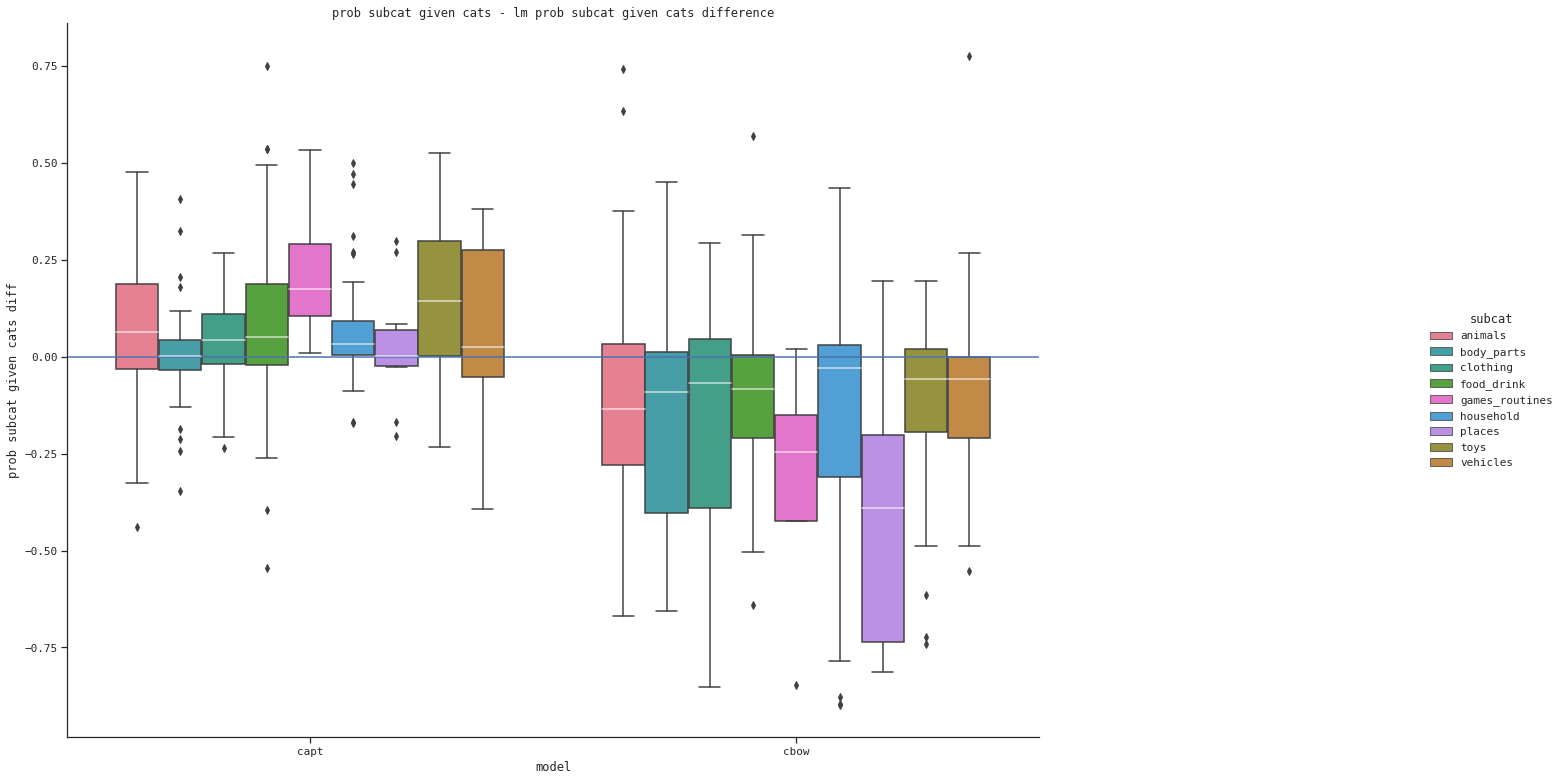

capt:
plotting 409/409 = 100.00% items...


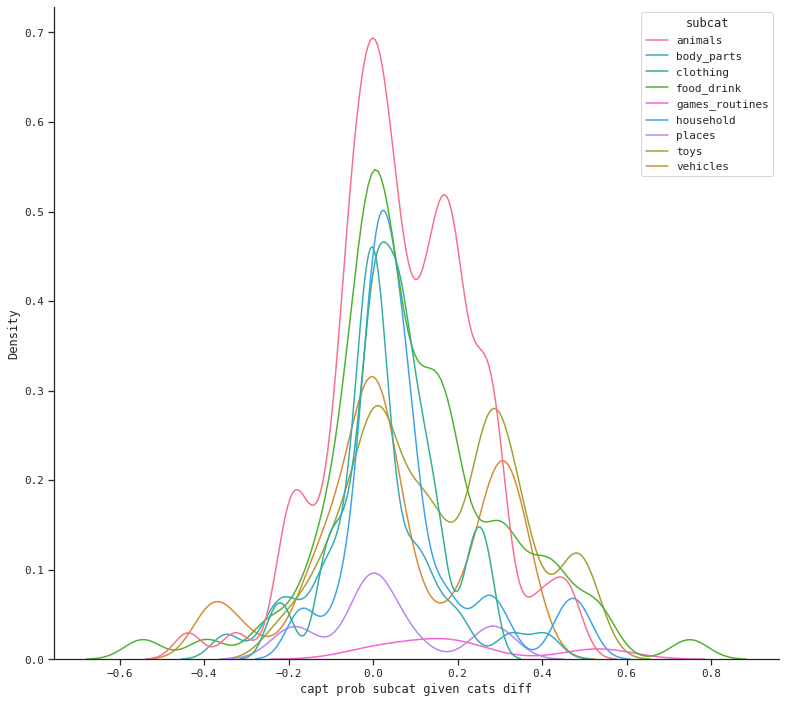

animals         #examples:    99 mean:  0.073859 t-test result: statistic:   4.41 pvalue: 0.000026
body_parts      #examples:    35 mean:  0.003529 t-test result: statistic:   0.14 pvalue: 0.885866
clothing        #examples:    44 mean:  0.045241 t-test result: statistic:   2.65 pvalue: 0.011190
food_drink      #examples:    76 mean:  0.094956 t-test result: statistic:   3.92 pvalue: 0.000196
games_routines  #examples:     4 mean:  0.223038 t-test result: statistic:   2.00 pvalue: 0.138843
household       #examples:    40 mean:  0.079414 t-test result: statistic:   3.35 pvalue: 0.001815
places          #examples:    10 mean:  0.026836 t-test result: statistic:   0.53 pvalue: 0.610873
toys            #examples:    55 mean:  0.155338 t-test result: statistic:   5.93 pvalue: 0.000000
vehicles        #examples:    46 mean:  0.056527 t-test result: statistic:   1.86 pvalue: 0.069655
all tokens      #examples:   409 mean:  0.078542 t-test result: statistic:   8.81 pvalue: 0.000000
cbow:
plot

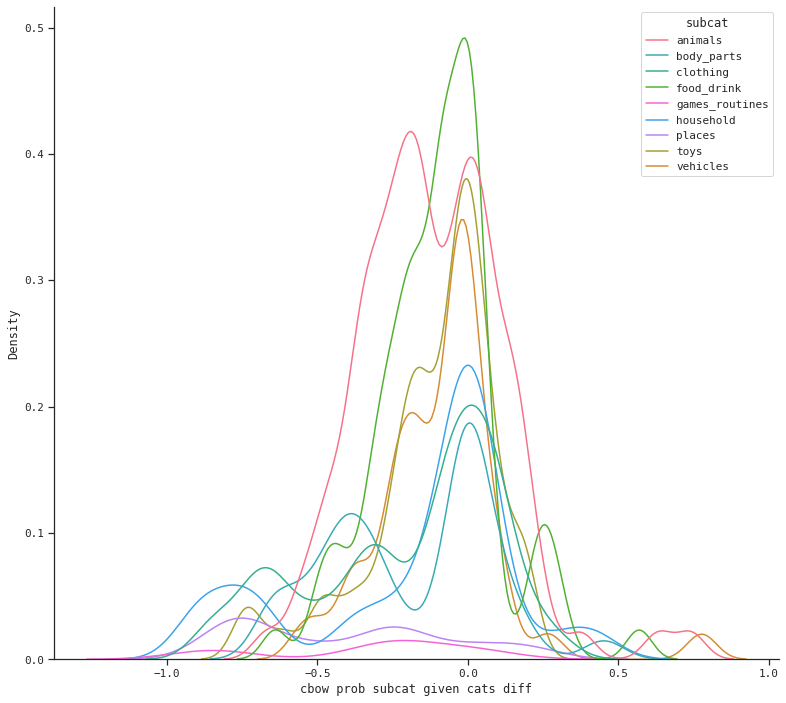

animals         #examples:    99 mean: -0.116594 t-test result: statistic:  -4.89 pvalue: 0.000004
body_parts      #examples:    35 mean: -0.184429 t-test result: statistic:  -4.00 pvalue: 0.000320
clothing        #examples:    44 mean: -0.196682 t-test result: statistic:  -4.23 pvalue: 0.000119
food_drink      #examples:    76 mean: -0.096373 t-test result: statistic:  -4.19 pvalue: 0.000075
games_routines  #examples:     4 mean: -0.329044 t-test result: statistic:  -1.78 pvalue: 0.172375
household       #examples:    40 mean: -0.172877 t-test result: statistic:  -3.11 pvalue: 0.003488
places          #examples:    10 mean: -0.403432 t-test result: statistic:  -3.59 pvalue: 0.005818
toys            #examples:    55 mean: -0.112885 t-test result: statistic:  -3.95 pvalue: 0.000228
vehicles        #examples:    46 mean: -0.090691 t-test result: statistic:  -2.91 pvalue: 0.005554
all tokens      #examples:   409 mean: -0.138441 t-test result: statistic: -10.81 pvalue: 0.000000
#: 2113
bo

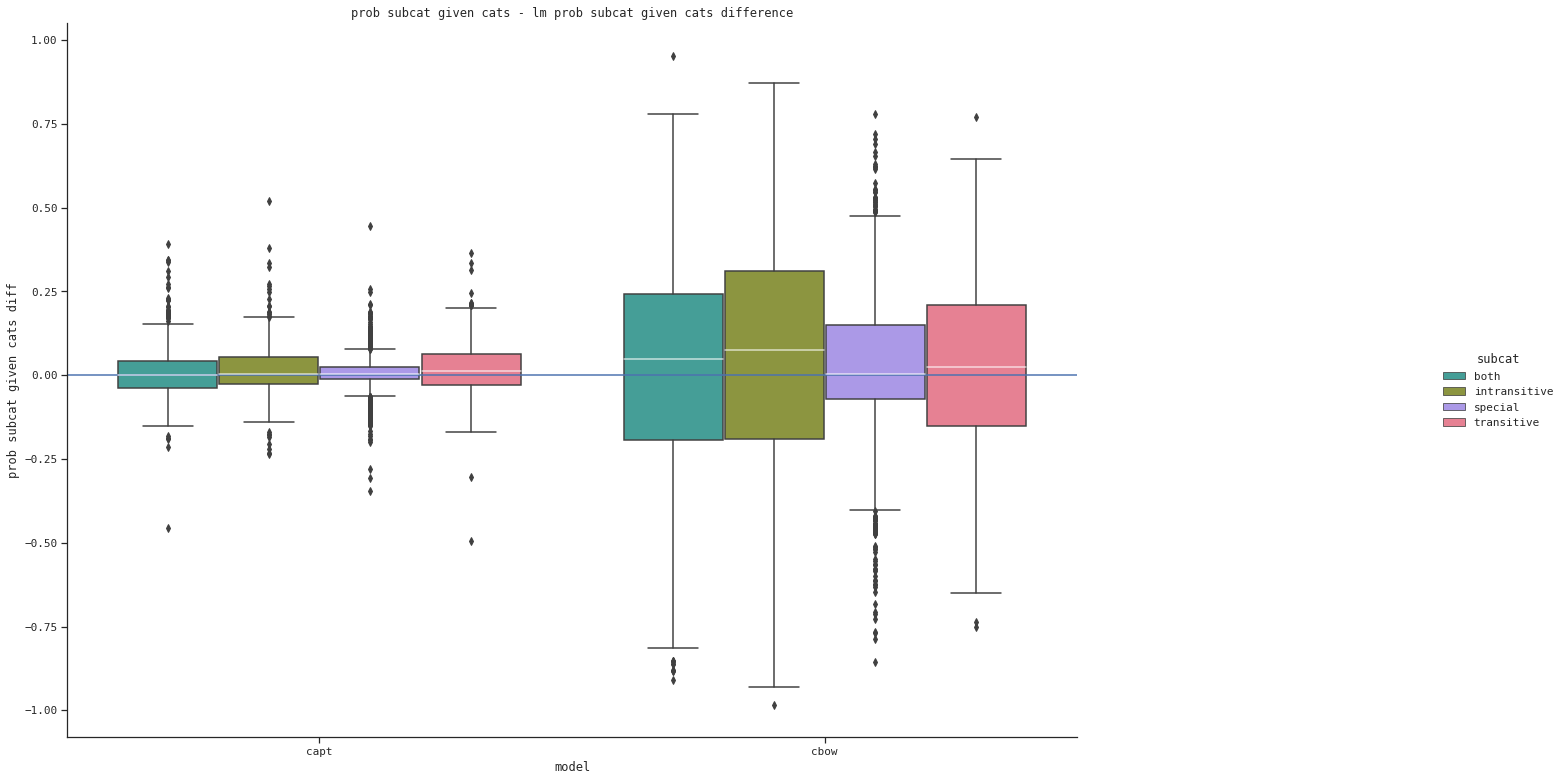

capt:
plotting 2113/2113 = 100.00% items...


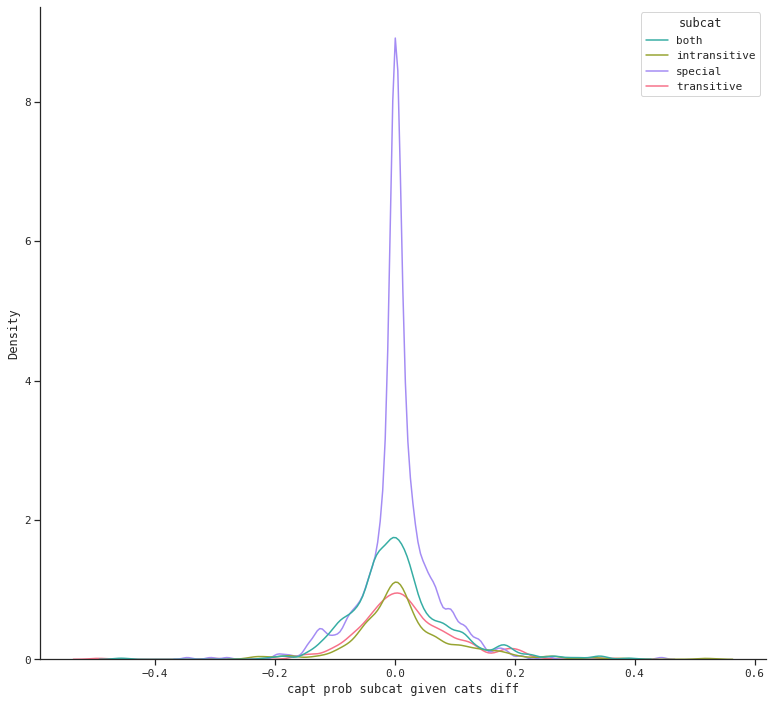

both            #examples:   520 mean:  0.008990 t-test result: statistic:   2.40 pvalue: 0.016567
intransitive    #examples:   281 mean:  0.018766 t-test result: statistic:   3.43 pvalue: 0.000697
special         #examples:  1000 mean:  0.005851 t-test result: statistic:   3.08 pvalue: 0.002133
transitive      #examples:   312 mean:  0.019955 t-test result: statistic:   3.98 pvalue: 0.000085
all tokens      #examples:  2113 mean:  0.010423 t-test result: statistic:   6.29 pvalue: 0.000000
cbow:
plotting 2113/2113 = 100.00% items...


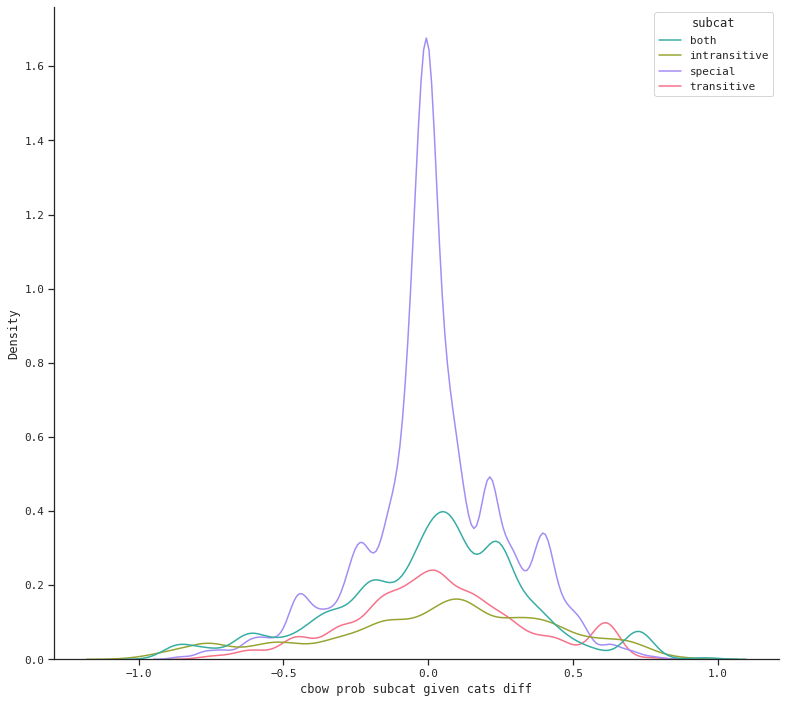

both            #examples:   520 mean:  0.012027 t-test result: statistic:   0.82 pvalue: 0.411939
intransitive    #examples:   281 mean:  0.033107 t-test result: statistic:   1.37 pvalue: 0.170632
special         #examples:  1000 mean:  0.021855 t-test result: statistic:   2.84 pvalue: 0.004610
transitive      #examples:   312 mean:  0.036707 t-test result: statistic:   2.16 pvalue: 0.031663
all tokens      #examples:  2113 mean:  0.023126 t-test result: statistic:   3.53 pvalue: 0.000417


In [14]:
def analyze_subcat_value_diff(all_items, pos, baseline_name=names[0], given_subcat=False, plotting_subcats=False, ttest_alternative='two-sided'):
    subcats = pos_subcats[pos]
    subcat2word_ids = {
        subcat_name: [word2idx[word] for word in subcat_words if word in word2idx]
        for subcat_name, subcat_words in subcats
    }
    all_subcat_words = list(filter(
        lambda word: word in word2idx,
        itertools.chain.from_iterable(subcat_words for subcat_name, subcat_words in subcats)))
    all_subcat_word_ids = [word2idx[word] for word in all_subcat_words]

    p_field = 'prob'
    ps_field = 'probs'
    subcat_field = 'subcat'

    items = all_items[all_items['pos2'].isin([pos]) & all_items[token_field].isin(all_subcat_words)].copy()
    items[subcat_field] = items[token_field].map(word2subcat).astype('category')
    print(f'#: {len(items)}')

    p_cats_field = 'prob cats'
    p_subcat_field = 'prob subcat'
    p_subcat_given_cats_field = 'prob subcat given cats'
    for name in names:
        name_ps_field = f'{name} {ps_field}'
        name_p_cats_field = f'{name} {p_cats_field}'
        name_p_subcat_field = f'{name} {p_subcat_field}'
        name_p_subcat_given_cats_field = f'{name} {p_subcat_given_cats_field}'
        items[name_p_cats_field] = items[name_ps_field].map(lambda p: np.sum(p[all_subcat_word_ids]))
        items[name_p_subcat_field] = items.apply(lambda item: np.sum(item[name_ps_field][subcat2word_ids[item[subcat_field]]]), axis=1)
        items[name_p_subcat_given_cats_field] = items[name_p_subcat_field] / items[name_p_cats_field]
        if name != baseline_name:
            extend_items_value_diff(items, name, baseline_name, p_subcat_given_cats_field)
    analyze_value_diff(
        items.reset_index(drop=True),
        p_subcat_given_cats_field,
        names,
        baseline_name=baseline_name,
        cat_field=subcat_field,
        palette=subcat_palette,
        ttest_alternative=ttest_alternative,
    )

    if given_subcat:
        for subcat_name, subcat_words in subcats:
            items = all_items[all_items['pos2'].isin(['noun']) & all_items[token_field].isin(subcat_words)].copy()
            items[token_field] = items[token_field].astype('category')
            print(f'{subcat_name:14} #: {len(items)}')
            palette = sns.color_palette('tab20')
            palette = {word: palette[i % len(palette)] for i, word in enumerate(subcat_words)}
            p_subcat_field = f'prob {subcat_name}'
            p_given_subcat_field = f'prob given {subcat_name}'
            for name in names:
                name_p_field = f'{name} {p_field}'
                name_ps_field = f'{name} {ps_field}'
                name_p_subcat_field = f'{name} {p_subcat_field}'
                name_p_given_subcat_field = f'{name} {p_given_subcat_field}'
                items[name_p_subcat_field] = items[name_ps_field].map(lambda p: np.sum(p[subcat2word_ids[subcat_name]]))
                items[name_p_given_subcat_field] = items[name_p_field] / items[name_p_subcat_field]
                if name != baseline_name:
                    extend_items_value_diff(items, name, baseline_name, p_given_subcat_field)
            analyze_value_diff(
                items.reset_index(drop=True),
                p_given_subcat_field,
                names,
                baseline_name=baseline_name,
                cat_field=token_field,
                palette=palette,
                plotting=plotting_subcats,
                ttest_alternative=ttest_alternative,
            )


for split in ['val']:
    for pos in sorted(pos_subcats.keys()):
        analyze_subcat_value_diff(split_items[split].all_token_items, pos)

lm:
noun_verb:
plotting 50/1597 = 3.13% items...


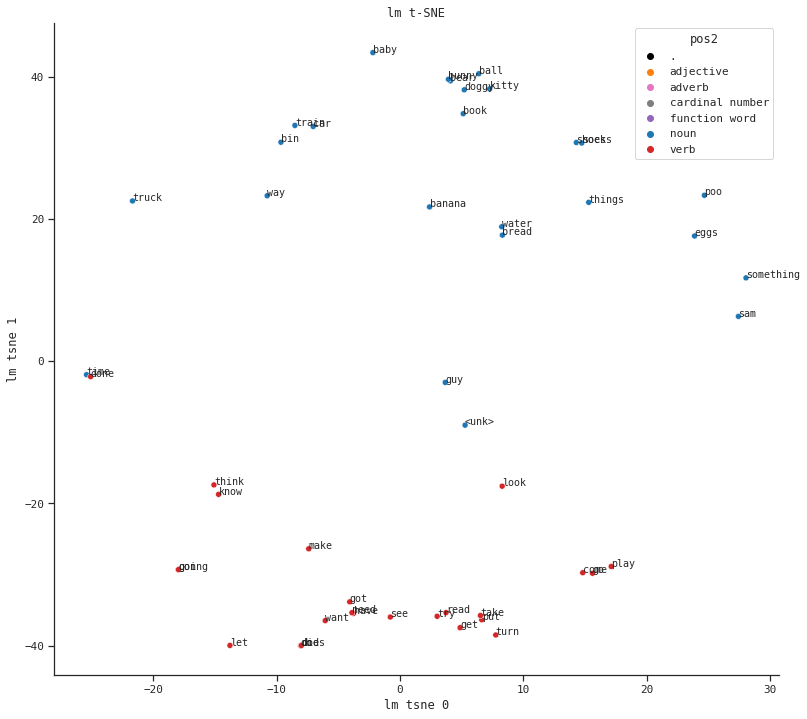

plotting 50/1597 = 3.13% items...


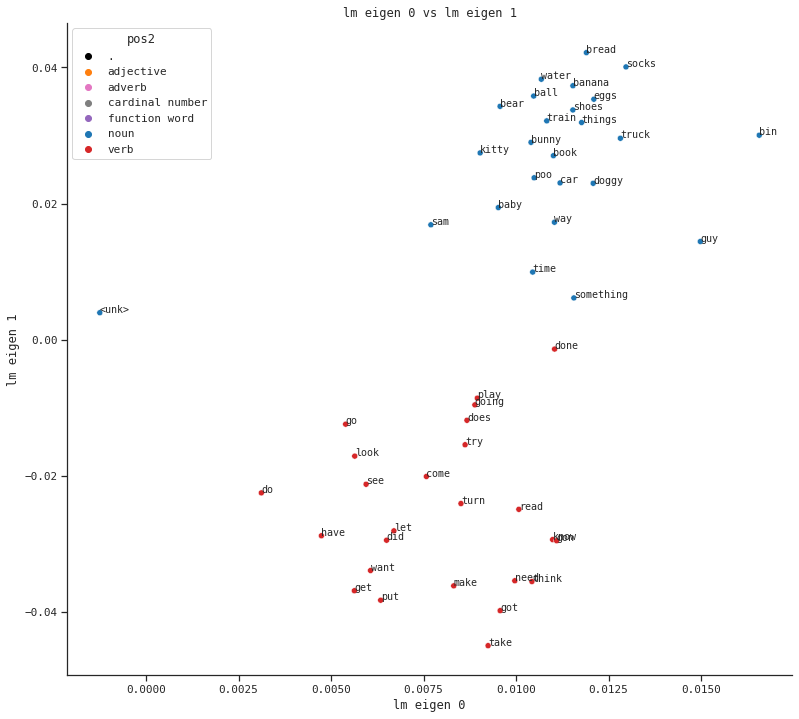

noun:
plotting 48/48 = 100.00% items...


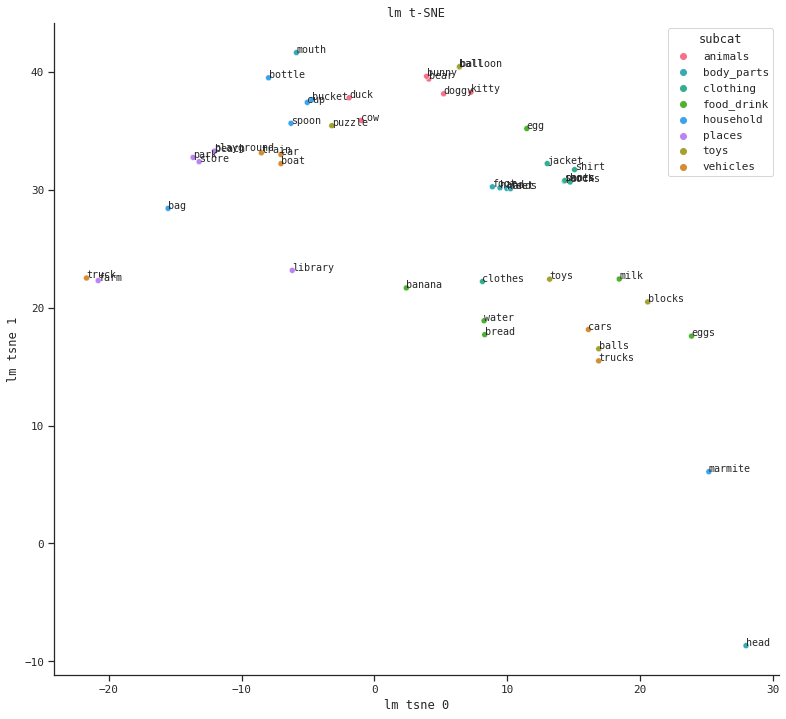

plotting 48/48 = 100.00% items...


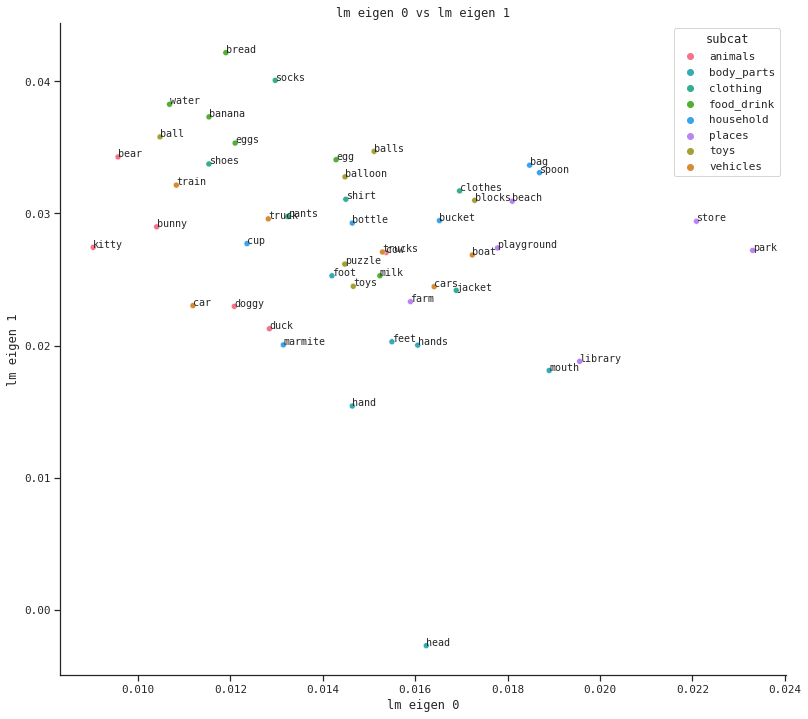

verb:
plotting 60/60 = 100.00% items...


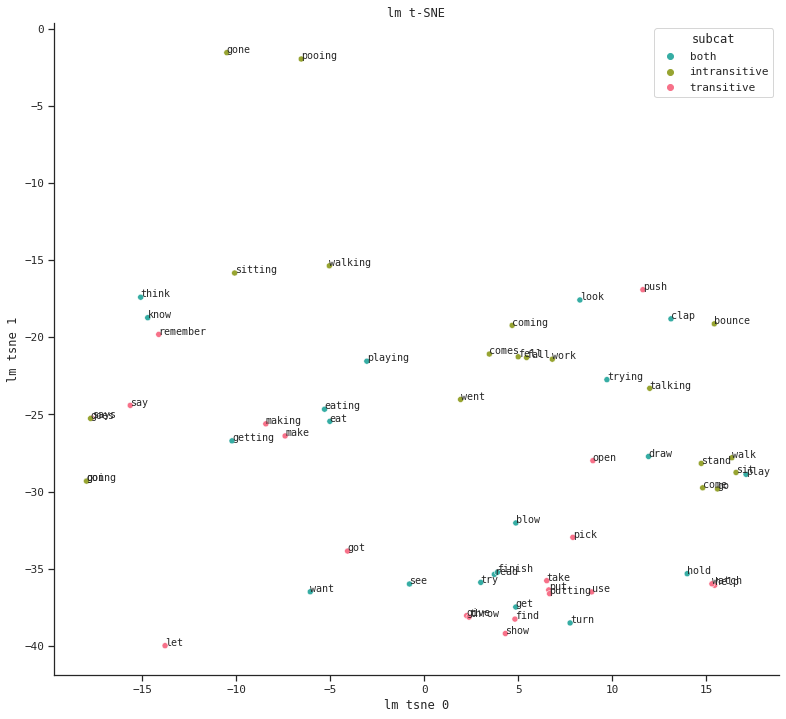

plotting 60/60 = 100.00% items...


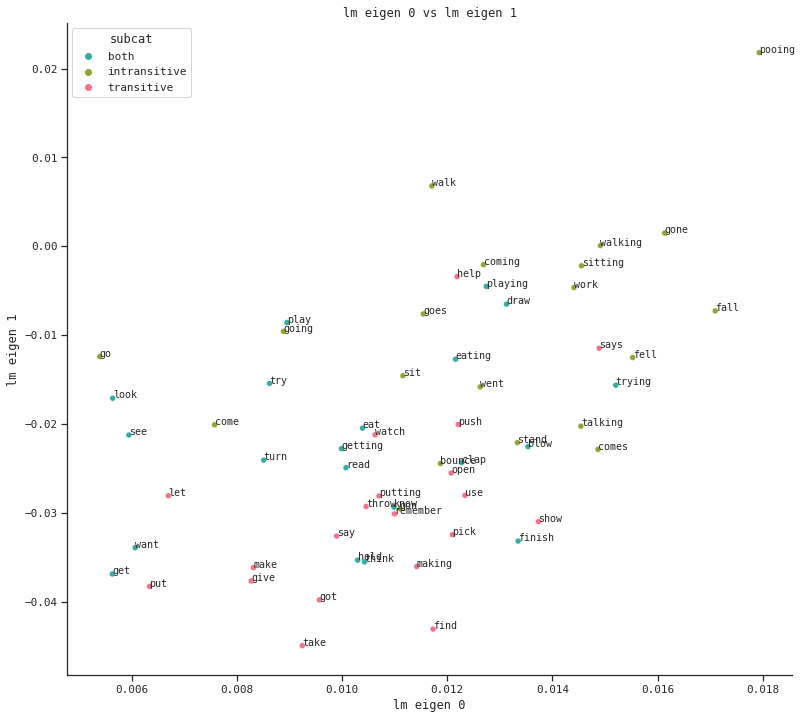

capt:
noun_verb:
plotting 50/1597 = 3.13% items...


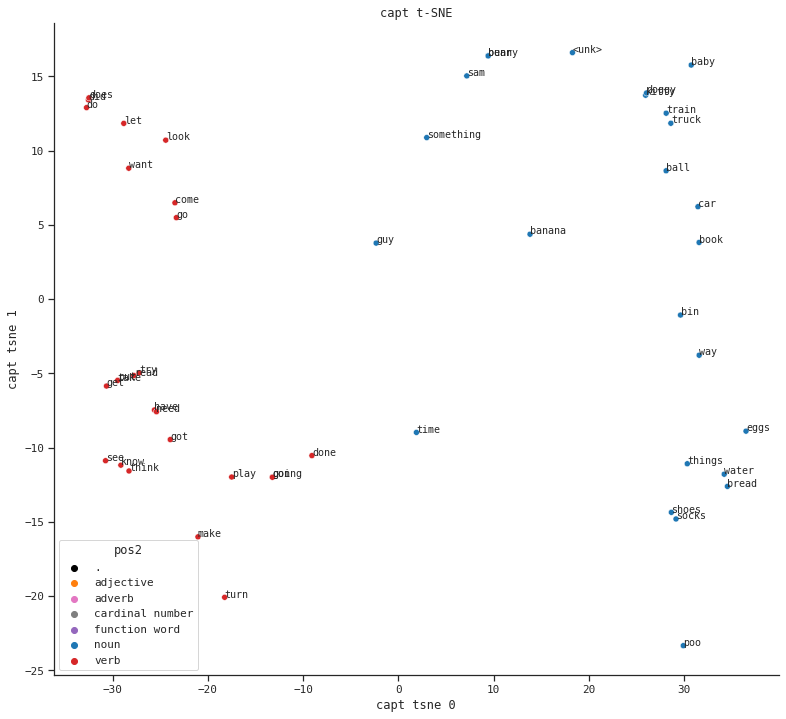

plotting 50/1597 = 3.13% items...


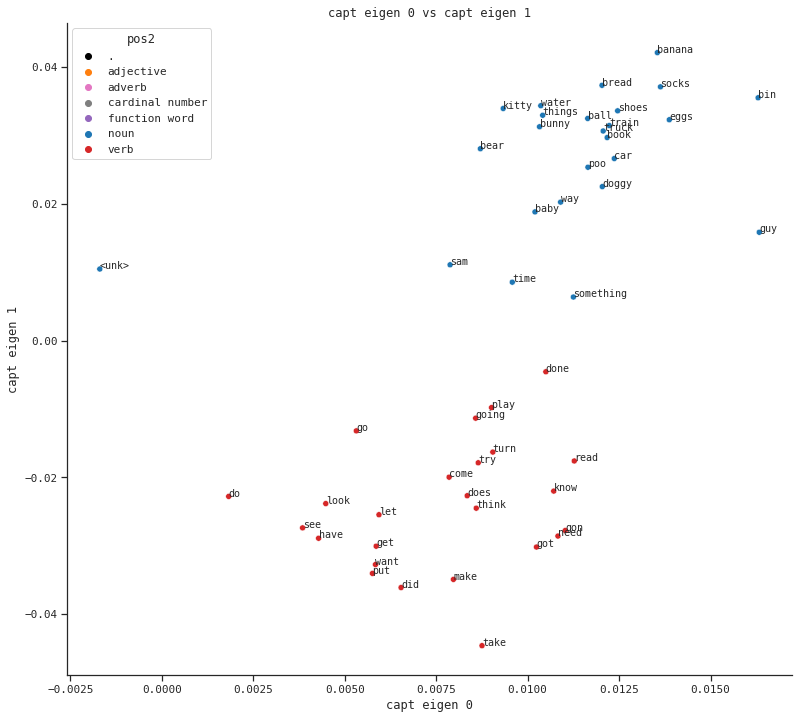

noun:
plotting 48/48 = 100.00% items...


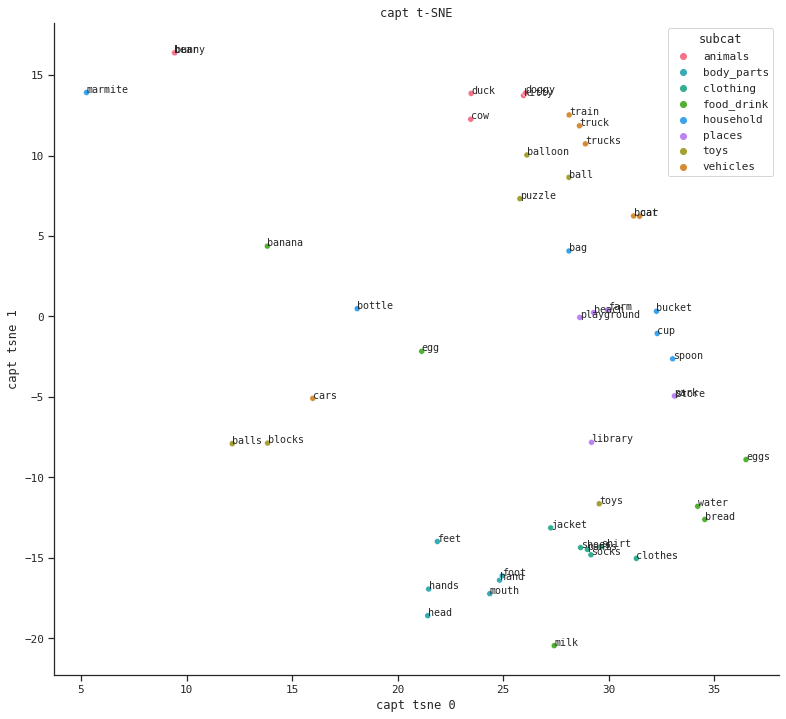

plotting 48/48 = 100.00% items...


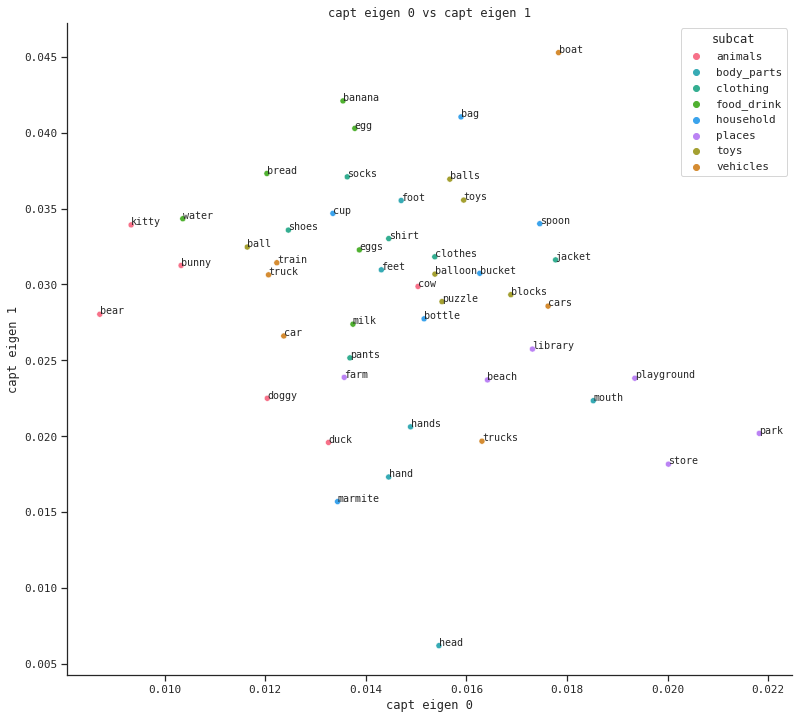

verb:
plotting 60/60 = 100.00% items...


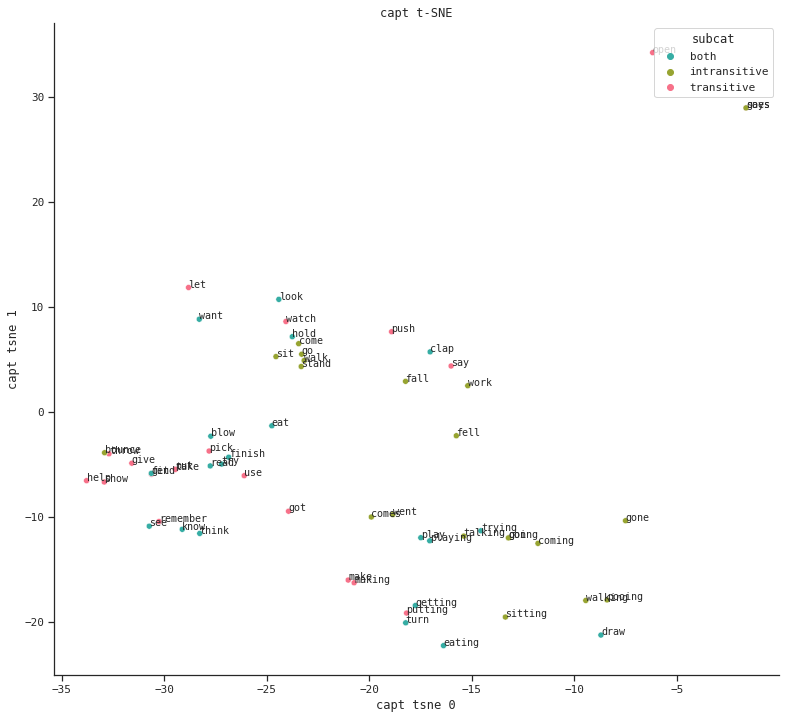

plotting 60/60 = 100.00% items...


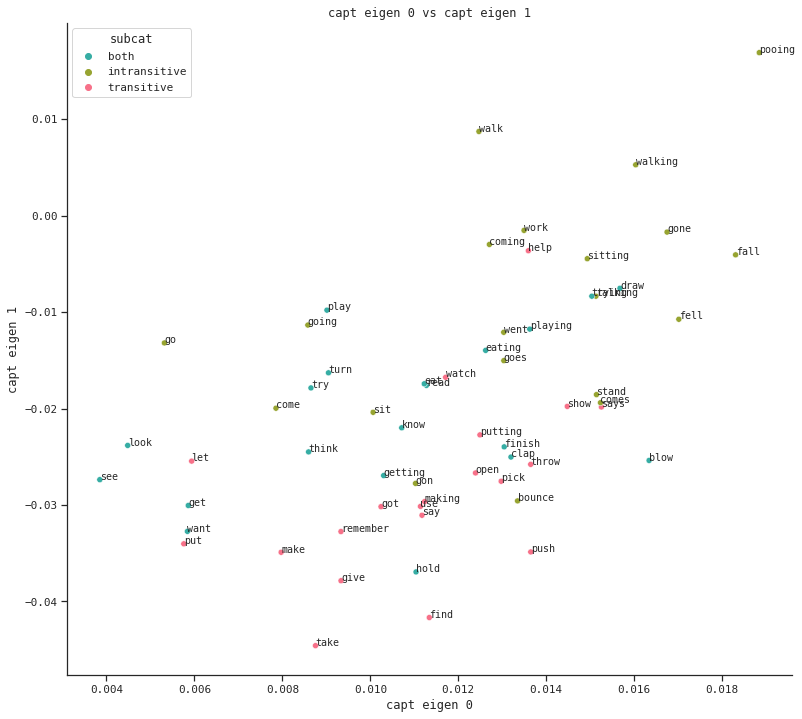

cbow:
noun_verb:
plotting 50/1597 = 3.13% items...


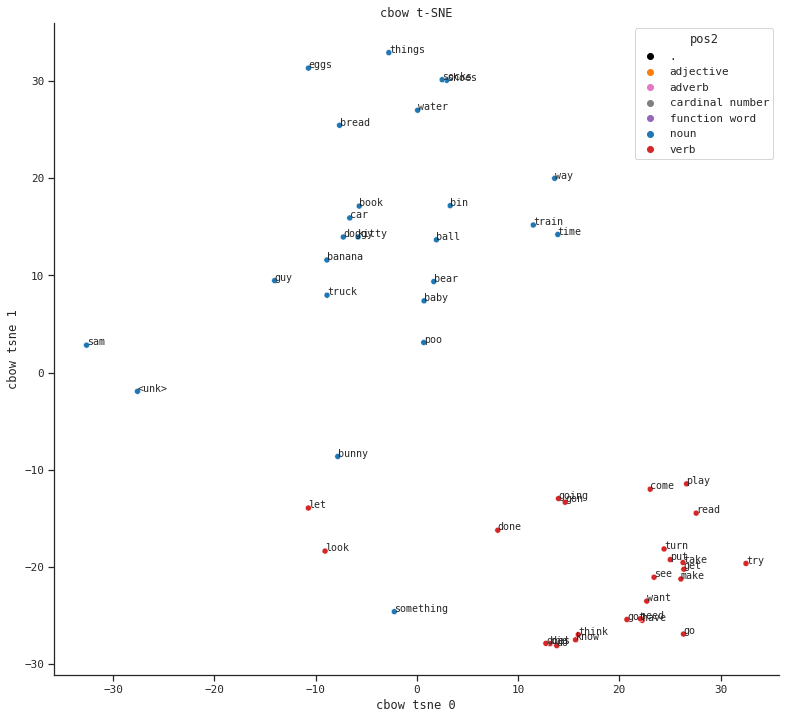

plotting 50/1597 = 3.13% items...


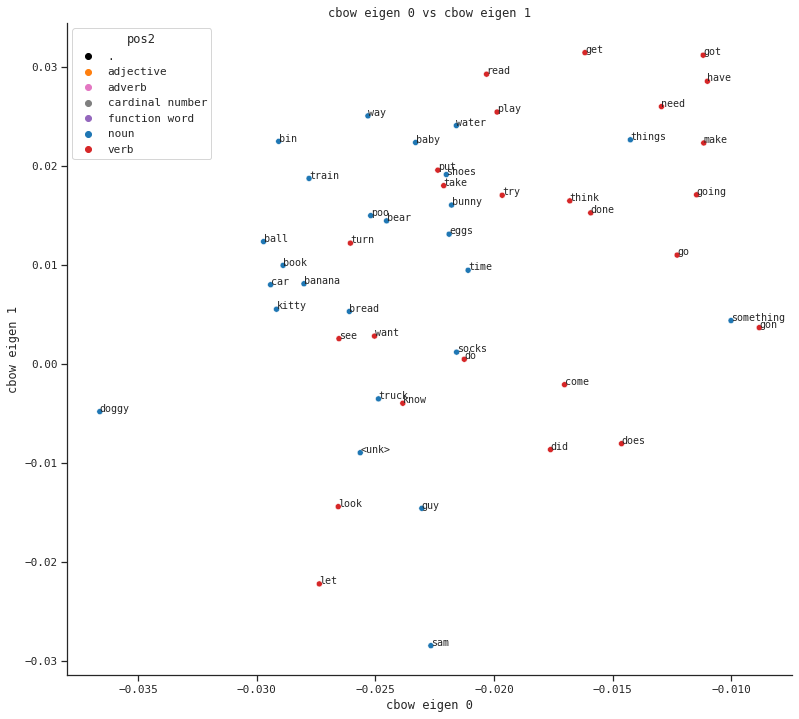

noun:
plotting 48/48 = 100.00% items...


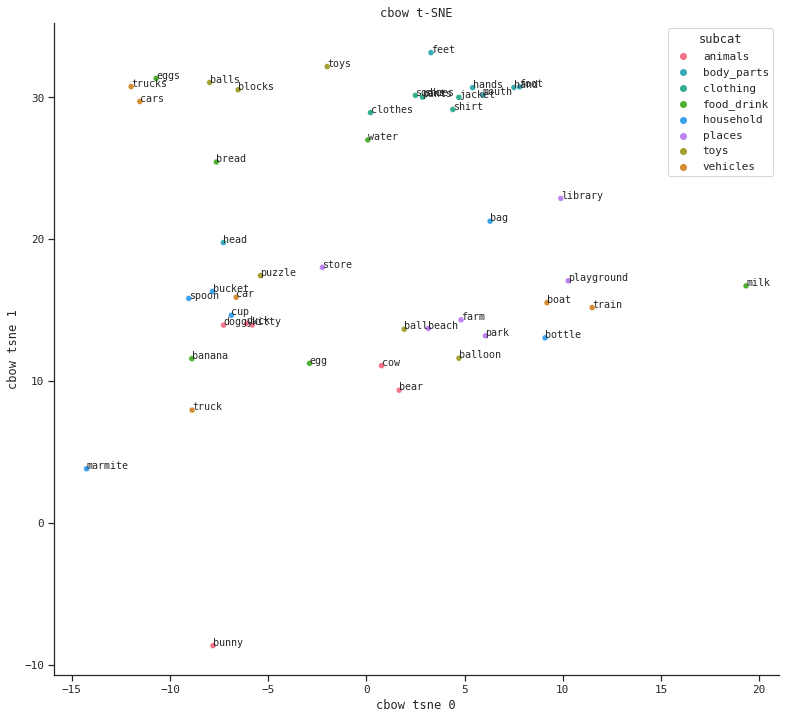

plotting 48/48 = 100.00% items...


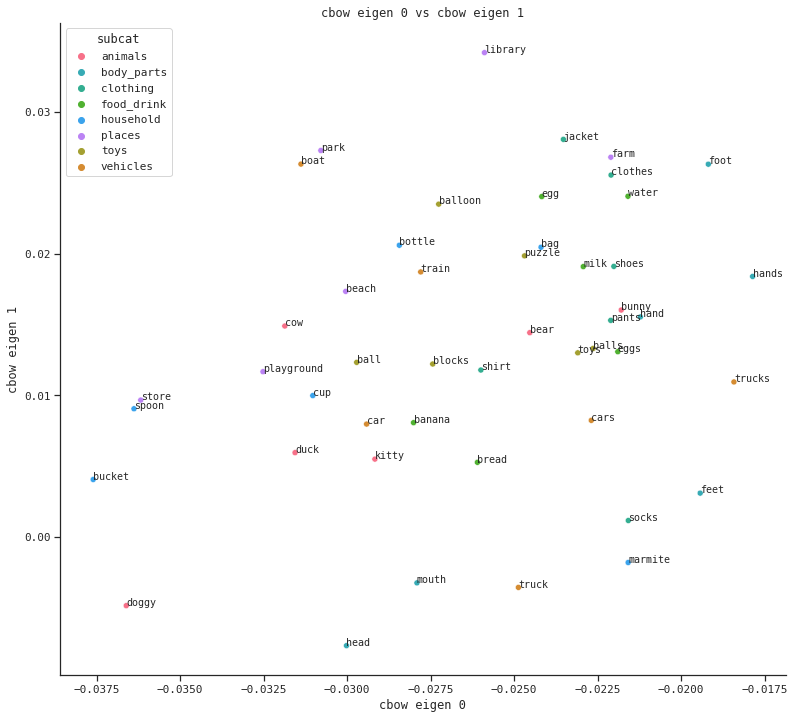

verb:
plotting 60/60 = 100.00% items...


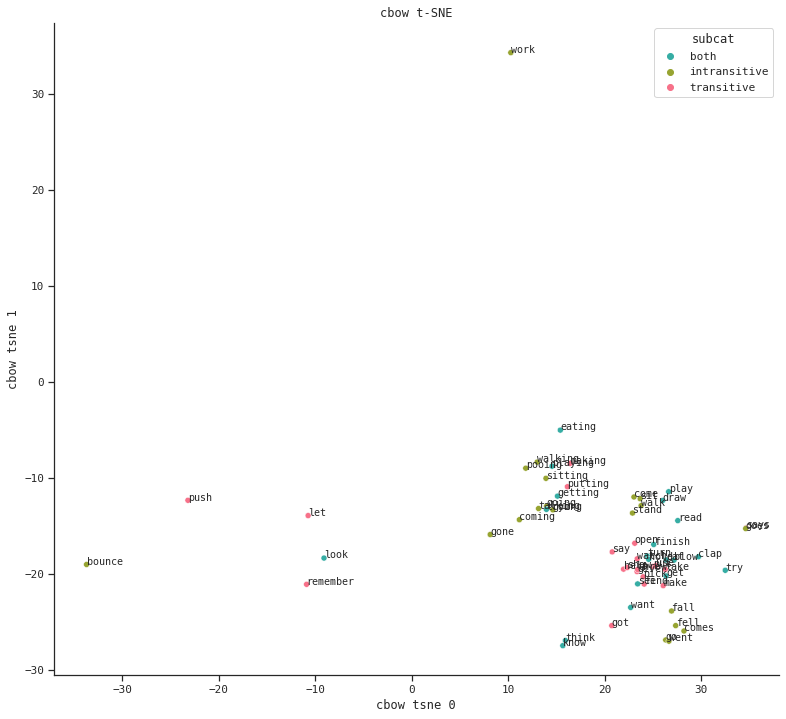

plotting 60/60 = 100.00% items...


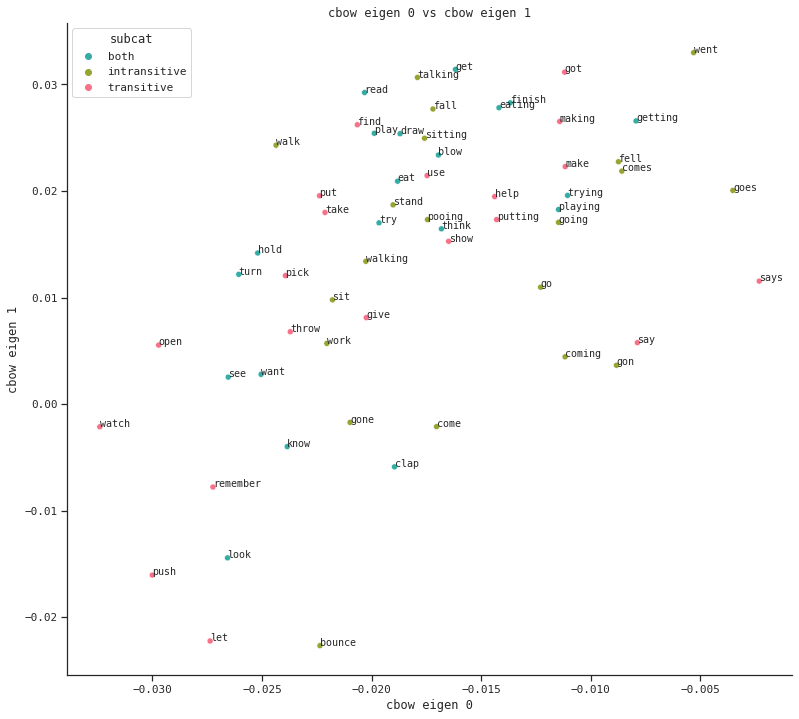

capt:
top:
plotting 224/261 = 85.82% items...


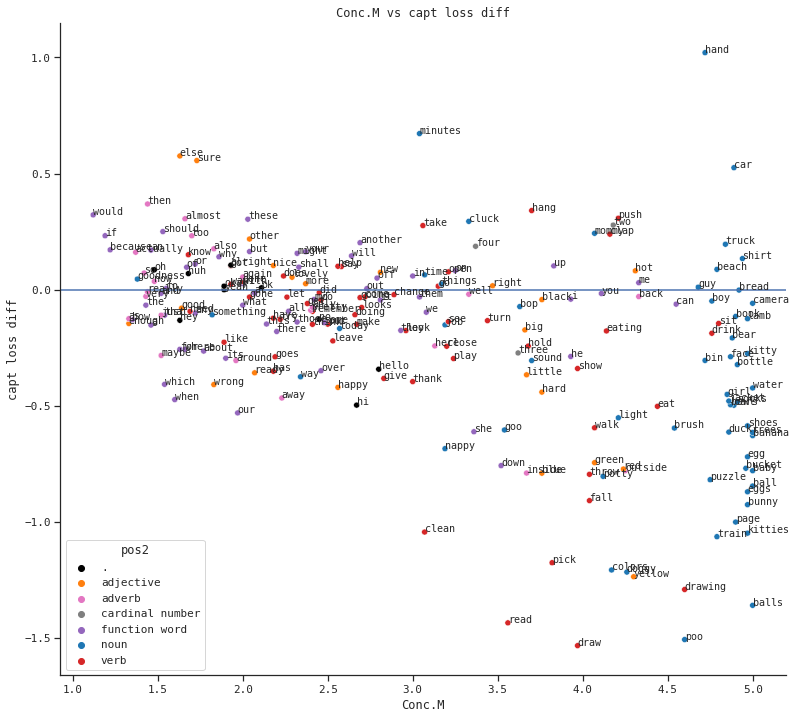

noun:
plotting 28/29 = 96.55% items...


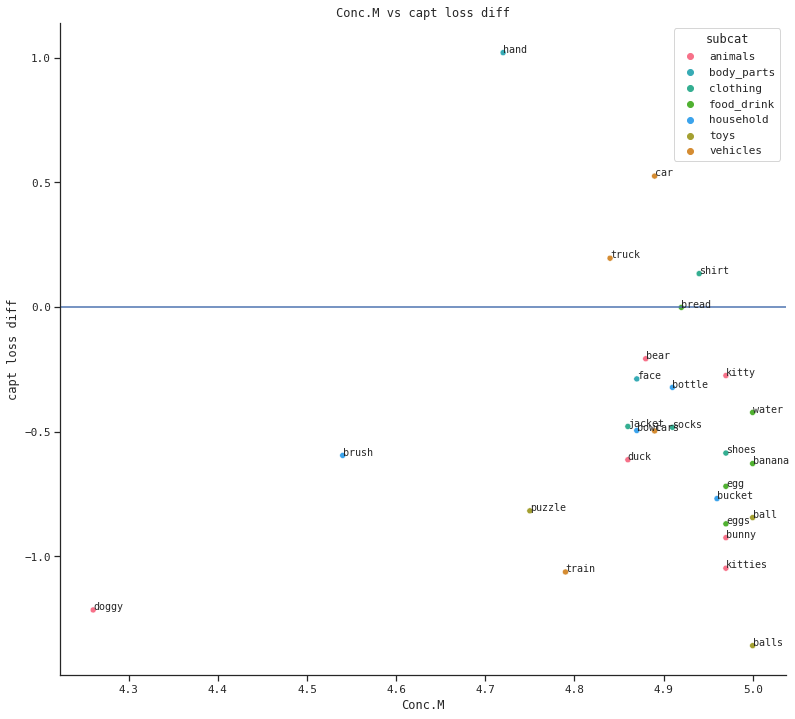

verb:
plotting 44/46 = 95.65% items...


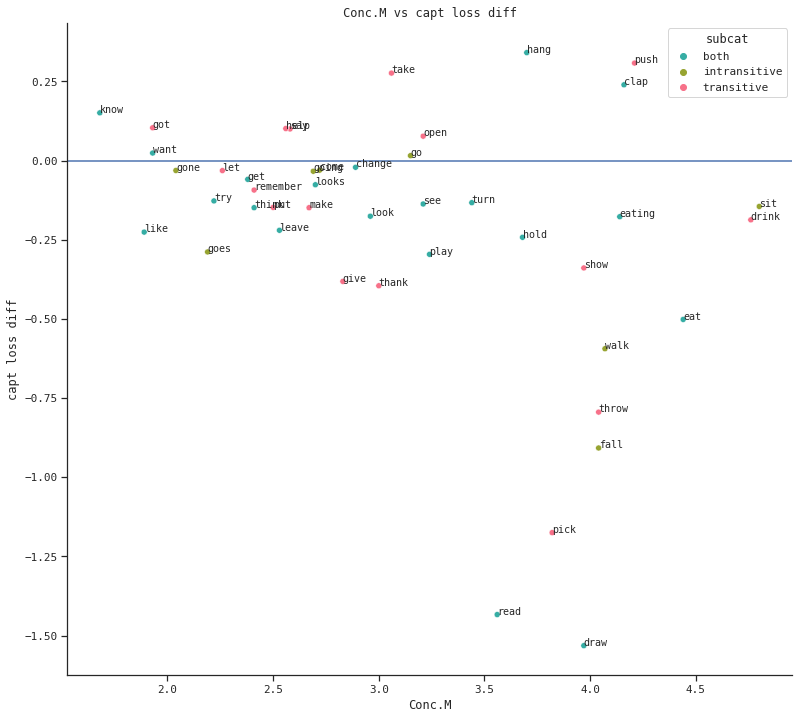

cbow:
top:
plotting 224/261 = 85.82% items...


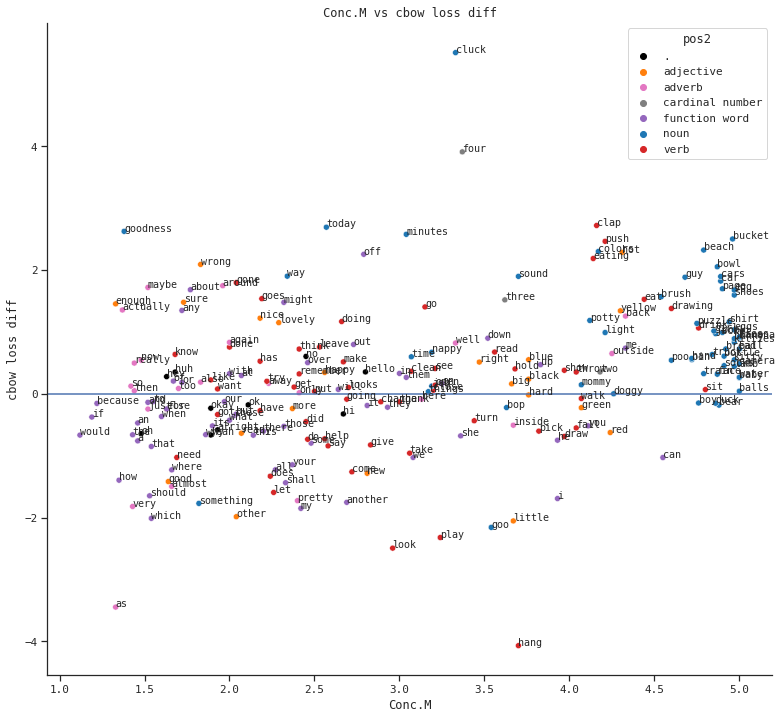

noun:
plotting 28/29 = 96.55% items...


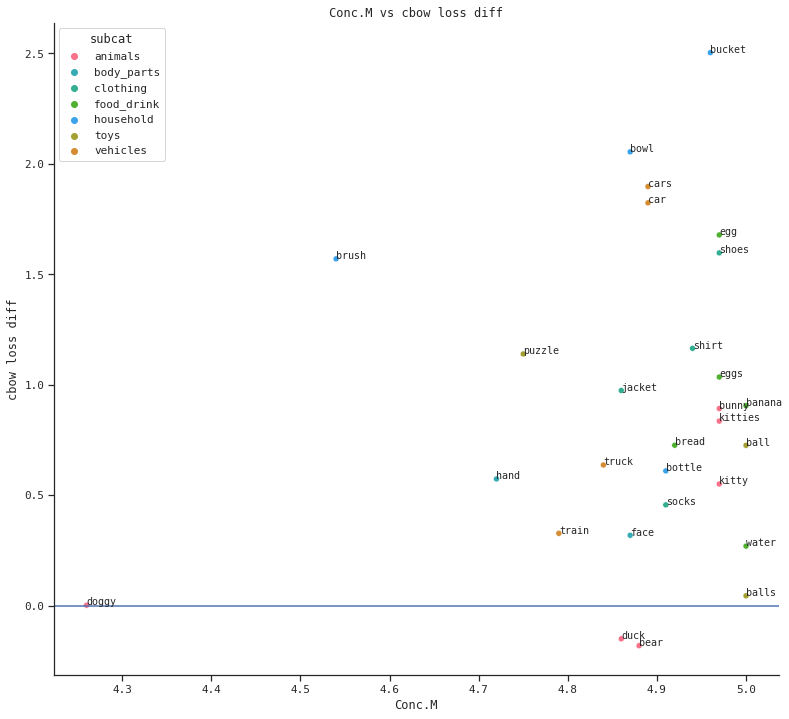

verb:
plotting 44/46 = 95.65% items...


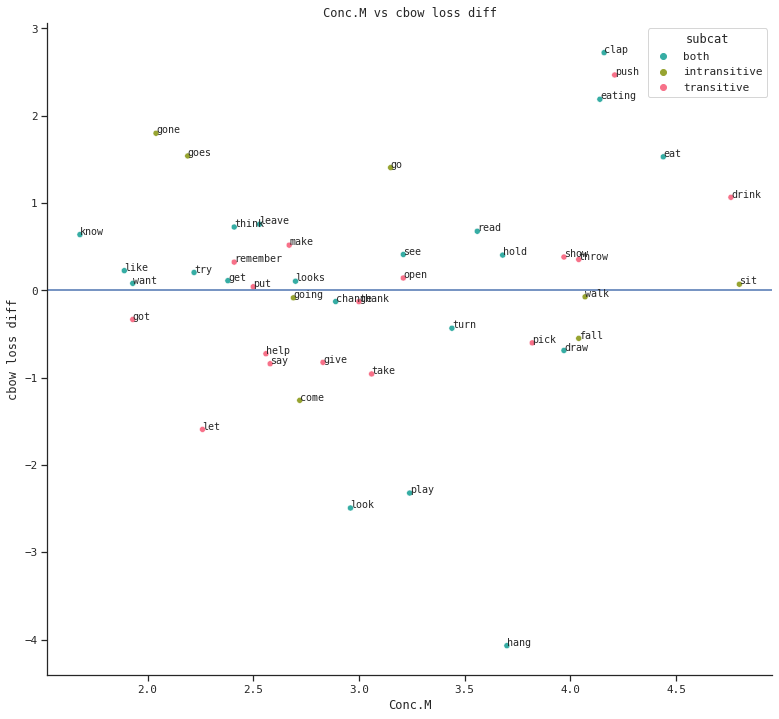

In [15]:
pos_field = "pos2"

baseline_name = names[0]

item_combinations = lambda split: (
    ("all", split_all_pos_items[split], None),
    ("top", split_all_pos_items[split], len(used_poses) * interleaving_step * (25 // interleaving_step)),
    ('noun_verb', split_pos_pos_items[split][('noun', 'verb')], None),
    ('noun_verb', split_pos_pos_items[split][('noun', 'verb')], 2 * interleaving_step * (25 // interleaving_step)),
    ('noun', get_subcat_items(split_pos_items[split]['noun'], 'noun'), 10000),
    ('verb', get_subcat_items(split_pos_items[split]['verb'], 'verb'), 10000),
)

for split in ['train']:
    for name in names:
        print(f'{name}:')
        loss_field = f'{name} loss'
        loss_diff_field = f'{name} loss diff'
        fields = [pos_field, "cnt", "logcnt", conc_field, "AnimPhysical", "AnimMental", "Category", "AoA", loss_field, loss_diff_field]

        for items_name, items, n_items in item_combinations(split)[3:]:
            print(f'{items_name}:')
            token_kwargs = {'fontsize': 'small'} if n_items is not None else None
            pos_hue = subcat_field if items_name in pos_subcats else pos_field

            for hue, x, y, title, plot_reg in [
                (pos_hue, f"{name} tsne 0", f"{name} tsne 1", f"{name} t-SNE", False),
                (pos_hue, f"{name} eigen 0", f"{name} eigen 1", "vs", False),
                (pos_hue, f"{name} eigen 0", conc_field, "vs", True),
            ][:2]:
                plot(sns.scatterplot, items, x=x, y=y, hue=hue, n_items=n_items, token_kwargs=token_kwargs, title=title, figsize=figsize)
                if plot_reg:
                    plot(sns.regplot, items, x=x, y=y, n_items=n_items, token_kwargs=token_kwargs, title=title, figsize=figsize)

for split in ['val']:
    for name in filter(lambda name: name != baseline_name, names):
        print(f'{name}:')
        loss_field = f'{name} loss'
        loss_diff_field = f'{name} loss diff'

        item_combinations_split = item_combinations(split)
        item_combinations_split = item_combinations_split[1:2] + item_combinations_split[4:6]
        for items_name, items, n_items in item_combinations_split:
            print(f'{items_name}:')
            token_kwargs = {'fontsize': 'small'} if n_items is not None else None
            pos_hue = subcat_field if items_name in pos_subcats else pos_field

            loss_diff_items = items.sort_values(loss_diff_field)
            if n_items is not None:
                loss_diff_items = loss_diff_items[loss_diff_items['cnt'] >= 5]
                if n_items * 2 >= len(loss_diff_items):
                    n_items = len(loss_diff_items)
            plot(sns.scatterplot, loss_diff_items, x=conc_field, y=loss_diff_field, hue=pos_hue, n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs", figsize=figsize)
            if n_items is None and False:
                plot(sns.regplot, loss_diff_items, x=conc_field, y=loss_diff_field, n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs", figsize=figsize)
                #plot(sns.catplot, loss_diff_items, x=pos_field, y=loss_diff_field, n_items=n_items, color="b", hlines=[0], title="vs", figsize=figsize,) #kind="violin", inner="stick",
            if n_items is not None and n_items < len(loss_diff_items):
                print('highest:')
                plot(sns.scatterplot, loss_diff_items[::-1], x=conc_field, y=loss_diff_field, hue=pos_hue, n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs", figsize=figsize)